<a href="https://colab.research.google.com/github/dwgb93/TEI_WildfireSpread/blob/main/notebooks/UNET_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The Erd&#337;s Institute Fall Boot Camp - Team Mahogany

We're using data from [this paper](https://arxiv.org/pdf/2112.02447.pdf) to predict where wildfires spread based on 12 features including wind, temperature, humidity, vegetation, and elevation.

This code does the following:


*   Downloads the data from Google Drive
*   Parses and normalizes the data into training, validation, and test sets.
*   Trains a U-Net shaped convolutional neural network until it stops improving
*   Measures the Precision, Recall, and AUC (PR) on new data
*   Plots the metrics and visualizes predictions



Licensed under the Apache License, Version 2.0
# 1. Imports

Import the required libraries.

In [ ]:
import re
from typing import Dict, List, Optional, Text, Tuple
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
import numpy as np
import pandas as pd

Note: This links your Google Drive to Colab. Useful if the data is stored in Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Common functions

These come from the original paper's [GitHub](https://github.com/google-research/google-research/tree/master/simulation_research/next_day_wildfire_spread), and have been modified slightly.

Run the following three cells to define the required library functions for loading the data.

In [ ]:
# Constants for the data reader

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask']

# Data statistics
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, std)
# I recalculated the statistics based on the training set only (uncropped)
DATA_STATS = {
    # 0.1 percentile, 99.9 percentile
    # Elevation
    'elevation' : (0.0, 3536.0, 896.5714, 842.6101),
    # Drought index - this claimed to be pressure, but it's Palmer Drought Severity Index
    # https://en.wikipedia.org/wiki/Palmer_drought_index
    # 0.1 percentile, 99.9 percentile
    'pdsi' : (-6.0559, 6.7432, -0.7729, 2.4407),
    # Normalized Difference Vegetation Index https://gisgeography.com/ndvi-normalized-difference-vegetation-index/
    'NDVI' : (-3826.0, 9282.0, 5350.6865, 2185.2192),
    # Precipitation in mm.
    # Negative values make no sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 19.2422, 0.3234289, 1.5336641),
    # Specific humidity ranges from 0 to 100%.
    'sph': (0., 1., 0.0065263123, 0.003735537), #max changed to 1
    # Wind direction - degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th' : (0.0, 360.0, 146.6468, 3435.0725),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn' : (253.15, 299.6313, 281.85196, 18.4972), #min changed
    # -20 degree C, 99.9 percentile
    'tmmx' : (253.15, 317.3869, 297.71643, 19.4581), #min changed
    # Wind speed.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs' : (0.0, 9.7368, 3.6278, 1.3092),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc' : (0.0, 109.9254, 53.4690, 25.0980),
    # Population
    # min, 99.9 percentile
    'population' : (0.0, 2935.7548828125, 30.4603, 214.20015),
    # We don't want to normalize the FireMasks.
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [ ]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
    num_in_channels: Number of channels in `input_img`.
    num_out_channels: Number of channels in `output_img`.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Calls `tf.image.central_crop` on input and output image tensors.

  Args:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
    sample_size: Side length (square) to crop to.
  Returns:
    input_img: Tensor with dimensions HWC.
    output_img: Tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

_parse_fn was modified to include sample_weights in addition to the inputs and labels.

This is a mask with 0's where the data is unknown (label: -1 No Data) and 1's where the data is known (label: 0 No Fire or 1: Fire)

This tells the neural network to ignore the missing data when calculating loss functions and training

In [ ]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '([a-zA-Z]+)'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'([a-zA-Z]+)', key)
  if match:
    return match.group(1)
  raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))

# Modified 

def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]
  
  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
    
  weights = tf.cast(tf.greater_equal(output_img, tf.zeros_like(output_img)), tf.int32)

  return input_img, output_img, weights


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

Depending on the cutoff, we could report ~100% precision or 100% accuracy, trading one off for the other. 

This function returns the precision and recall that maximize the F1-score, for consistency.

For certain cutoffs, the precision is undefined, so it is recorded as 0.

In [ ]:
def get_metrics(precs, recs):
  f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))
  return precs[np.argmax(f1s)], recs[np.argmax(f1s)]

Define the features in the dataset

In [ ]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

# 3. Load the dataset

Enter the file pattern of the dataset.

If you are running this notebook locally, and your data is not stored in Google Drive, change the file_pattern below to where your data is stored locally.

In [ ]:
file_pattern = '/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Final Project - Mahogany/Data/next_day_wildfire_spread_train*'
#Location within MY GDrive. Might not be the same for you. I don't know if you can link to my drive this way...
val_file_pattern = '/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Final Project - Mahogany/Data/next_day_wildfire_spread_eval*'

test_file_pattern = '/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Final Project - Mahogany/Data/next_day_wildfire_spread_test*'

Get the training, validation, and testing datasets


We randomly crop the training data, so each epoch of the neural network gets a new set of 15,000 fire images to train off of.

We center crop the images for validation and testing.

In [ ]:
one_batch = get_dataset(
      file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=32, #We don't go through the whole dataset at once. It takes 468 loops to do the whole thing.
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

dataset = get_dataset(
      file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=14979,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

valset = get_dataset(
      val_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=1877,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=True)

testset = get_dataset(
      test_file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=1877,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=True)

# 4. UNET-Style Convolutional Neural Network

More imports! Fun!

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU
from keras.layers import BatchNormalization, Activation, MaxPooling2D
from keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

We double the number of filters each layer of the encoder, and halve them for the decoder.
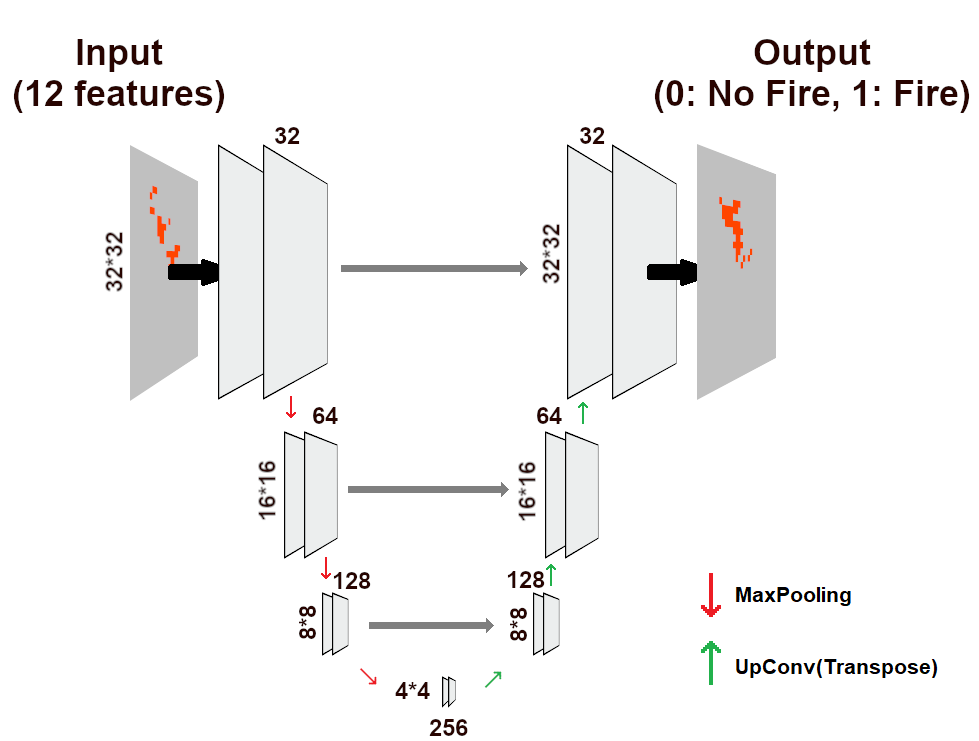

In [ ]:
def conv_block(prev_output, filters, kernel):
    x = Conv2D(filters, kernel, padding = "same")(prev_output) 
    x = layers.BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, kernel, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    return LeakyReLU()(x)

In [ ]:
def up_conv_block(prev_output, filters, kernel):
    x = Conv2D(filters, kernel, padding = "same")(prev_output) 
    x = layers.BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters//2, kernel, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    return LeakyReLU()(x)

In [ ]:
sample_size = dataset.element_spec[0].shape[1]

# Create UNET style model - This first one is the same as the paper
model_input = keras.Input(shape=(sample_size, sample_size, 12), name="original_img") # input is 32*32

#Downsample
block_1_output = conv_block(model_input, 32, 3) 
x = MaxPooling2D(2)(block_1_output) #output is 16 * 16
block_2_output = conv_block(x, 64, 3) 
x = MaxPooling2D(2)(block_2_output) #output is 8*8
block_3_output = conv_block(x, 128, 3) 
x = MaxPooling2D(2)(block_3_output) #output is 4*4

#bottom layer bottleneck
x = conv_block(x, 256, 3) # still 4x4

#upsample
# x = UpSampling2D()(x) #Optional, but you have to change stride = 1 below
x = Conv2DTranspose(128, 3, strides = 2, padding = "same")(x) # output is 8*8
x = layers.BatchNormalization()(x)
first_up_layer = layers.add([block_3_output, x]) 
x = up_conv_block(first_up_layer, 256, 3)
# x = UpSampling2D()(x) #Optional, but you have to change stride = 1 below
x = Conv2DTranspose(64, 3, strides = 2, padding = "same")(x) # output is 16*16
x = layers.BatchNormalization()(x)
second_up_layer = layers.add([block_2_output, x]) 
x = up_conv_block(second_up_layer, 128, 3)
# x = UpSampling2D()(x) #Optional, but you have to change stride = 1 below
x = Conv2DTranspose(32, 3, strides = 2, padding = "same")(x) # output is 32*32
x = layers.BatchNormalization()(x)
third_up_layer = layers.add([block_1_output, x]) 
x = up_conv_block(third_up_layer, 64, 3)

predictions = Conv2D(1, 3, activation = "sigmoid", padding="same")(x) #Force output to be 0,1

# this is the model we will train
model = Model(inputs=model_input, outputs=predictions)

model.summary() # It's not as deep as Inception, but it'll do



# compile the model 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = [tf.keras.metrics.AUC()])
# optimizer changed to adam from rmsprop because it's spoopier

# Save the best model.
checkpoint = ModelCheckpoint('best_default_model.hdf5', monitor='val_loss', save_best_only=True, save_freq=1)

# stop training if it's overfitting # may need to increase regularization
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
CALLBACKS=[checkpoint,early]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 original_img (InputLayer)      [(None, 32, 32, 12)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   3488        ['original_img[0][0]']           
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
# Uncomment and turn sideways to see the beautiful U-shaped architecture.
# keras.utils.plot_model(model, "UNet.png", show_shapes=True)

This randomly crops new 32*32 squares from the data and runs 1 epoch. Then it does it again.

We could have done model.fit with (inputs, labels) representing inputs and outputs to fit, but it would pick the SAME 15,000 inputs and outputs instead of taking advantage of the random cropping.

It shows a lot more data to the model, improving performance

Sometimes this doesn't run. This is a known bug. To fix, restart kernel and run fresh.

Alternatively, you can just use the same 15,000 fires over and over again without random cropping running the code chunk below

In [ ]:
# train the model on the new data for a few epochs
print("Model has started training")
EPOCHS = 25


history = model.fit(one_batch, #tf.data.dataset takes full advantage of the data generator above
          epochs = EPOCHS,
          validation_data = valset,
          callbacks = CALLBACKS)

# If the above code doesn't run, get a batch of inputs and labels, then run the below code:
# inputs, labels, weights = next(iter(dataset))
# history = model.fit(inputs, labels, 
#                     sample_weight = sample_weight,
#                     epochs = EPOCHS,
#                     batch_size = 64,
#                     validation_data = (inputs_val, labels_val))

Model has started training
Epoch 1/25


      1/Unknown - 13s 13s/step - loss: 0.7373 - auc: 0.4888

      3/Unknown - 13s 36ms/step - loss: 0.6643 - auc: 0.5156

      5/Unknown - 13s 35ms/step - loss: 0.6001 - auc: 0.5487

      7/Unknown - 13s 35ms/step - loss: 0.5432 - auc: 0.5281

      9/Unknown - 13s 34ms/step - loss: 0.4899 - auc: 0.4442

     11/Unknown - 13s 36ms/step - loss: 0.4614 - auc: 0.4736

     13/Unknown - 13s 36ms/step - loss: 0.4350 - auc: 0.5050

     15/Unknown - 13s 36ms/step - loss: 0.4129 - auc: 0.5242

     17/Unknown - 13s 37ms/step - loss: 0.3924 - auc: 0.5435

     19/Unknown - 13s 35ms/step - loss: 0.3756 - auc: 0.5541

     21/Unknown - 14s 36ms/step - loss: 0.3610 - auc: 0.5638

     22/Unknown - 14s 37ms/step - loss: 0.3527 - auc: 0.5737

     24/Unknown - 14s 38ms/step - loss: 0.3407 - auc: 0.5746

     26/Unknown - 14s 39ms/step - loss: 0.3271 - auc: 0.5879

     28/Unknown - 14s 39ms/step - loss: 0.3134 - auc: 0.5590

     30/Unknown - 14s 38ms/step - loss: 0.2986 - auc: 0.5401

     32/Unknown - 14s 38ms/step - loss: 0.2874 - auc: 0.5475

     34/Unknown - 14s 38ms/step - loss: 0.2749 - auc: 0.5402

     36/Unknown - 14s 38ms/step - loss: 0.2666 - auc: 0.5532

     38/Unknown - 14s 39ms/step - loss: 0.2603 - auc: 0.5681

     40/Unknown - 14s 38ms/step - loss: 0.2539 - auc: 0.5747

     42/Unknown - 14s 38ms/step - loss: 0.2480 - auc: 0.5841

     44/Unknown - 14s 38ms/step - loss: 0.2422 - auc: 0.5922

     45/Unknown - 15s 39ms/step - loss: 0.2397 - auc: 0.5957

     47/Unknown - 15s 39ms/step - loss: 0.2344 - auc: 0.6032

     48/Unknown - 15s 40ms/step - loss: 0.2323 - auc: 0.6055

     50/Unknown - 15s 40ms/step - loss: 0.2276 - auc: 0.6083

     52/Unknown - 15s 41ms/step - loss: 0.2238 - auc: 0.6097

     53/Unknown - 15s 41ms/step - loss: 0.2210 - auc: 0.5978

     54/Unknown - 15s 42ms/step - loss: 0.2177 - auc: 0.5938

     56/Unknown - 15s 42ms/step - loss: 0.2123 - auc: 0.5694

     57/Unknown - 15s 42ms/step - loss: 0.2105 - auc: 0.5727

     59/Unknown - 15s 42ms/step - loss: 0.2074 - auc: 0.5799

     61/Unknown - 15s 42ms/step - loss: 0.2037 - auc: 0.5877

     63/Unknown - 15s 42ms/step - loss: 0.2008 - auc: 0.5945

     65/Unknown - 15s 42ms/step - loss: 0.1978 - auc: 0.5904

     67/Unknown - 16s 42ms/step - loss: 0.1944 - auc: 0.5945

     69/Unknown - 16s 42ms/step - loss: 0.1920 - auc: 0.5984

     71/Unknown - 16s 42ms/step - loss: 0.1899 - auc: 0.6062

     73/Unknown - 16s 42ms/step - loss: 0.1878 - auc: 0.6112

     75/Unknown - 16s 42ms/step - loss: 0.1855 - auc: 0.6176

     77/Unknown - 16s 42ms/step - loss: 0.1826 - auc: 0.6047

     78/Unknown - 16s 43ms/step - loss: 0.1806 - auc: 0.6006

     79/Unknown - 16s 43ms/step - loss: 0.1787 - auc: 0.5888

     80/Unknown - 16s 43ms/step - loss: 0.1774 - auc: 0.5859

     81/Unknown - 16s 43ms/step - loss: 0.1764 - auc: 0.5882

     83/Unknown - 16s 43ms/step - loss: 0.1751 - auc: 0.5906

     84/Unknown - 16s 43ms/step - loss: 0.1743 - auc: 0.5931

     86/Unknown - 16s 43ms/step - loss: 0.1726 - auc: 0.5965

     87/Unknown - 17s 43ms/step - loss: 0.1719 - auc: 0.5968

     89/Unknown - 17s 43ms/step - loss: 0.1699 - auc: 0.5982

     91/Unknown - 17s 43ms/step - loss: 0.1684 - auc: 0.5992

     93/Unknown - 17s 43ms/step - loss: 0.1672 - auc: 0.6027

     95/Unknown - 17s 43ms/step - loss: 0.1659 - auc: 0.6053

     97/Unknown - 17s 43ms/step - loss: 0.1639 - auc: 0.5893

    100/Unknown - 17s 42ms/step - loss: 0.1624 - auc: 0.5927

    102/Unknown - 17s 42ms/step - loss: 0.1619 - auc: 0.5912

    103/Unknown - 17s 44ms/step - loss: 0.1616 - auc: 0.5937

    104/Unknown - 18s 46ms/step - loss: 0.1614 - auc: 0.5963

    105/Unknown - 18s 47ms/step - loss: 0.1606 - auc: 0.5989

    107/Unknown - 18s 47ms/step - loss: 0.1595 - auc: 0.5933

    108/Unknown - 18s 48ms/step - loss: 0.1595 - auc: 0.5967

    109/Unknown - 19s 55ms/step - loss: 0.1594 - auc: 0.5991

    110/Unknown - 19s 55ms/step - loss: 0.1589 - auc: 0.6009

    111/Unknown - 19s 56ms/step - loss: 0.1587 - auc: 0.6038

    112/Unknown - 19s 56ms/step - loss: 0.1583 - auc: 0.6053

    113/Unknown - 19s 56ms/step - loss: 0.1585 - auc: 0.6079

    114/Unknown - 19s 57ms/step - loss: 0.1582 - auc: 0.6086

    115/Unknown - 19s 57ms/step - loss: 0.1572 - auc: 0.6095

    116/Unknown - 19s 57ms/step - loss: 0.1563 - auc: 0.6090

    117/Unknown - 19s 58ms/step - loss: 0.1557 - auc: 0.6107

    118/Unknown - 20s 58ms/step - loss: 0.1555 - auc: 0.6119

    119/Unknown - 20s 59ms/step - loss: 0.1551 - auc: 0.6121

    120/Unknown - 20s 61ms/step - loss: 0.1547 - auc: 0.6109

    121/Unknown - 20s 63ms/step - loss: 0.1545 - auc: 0.6129

    122/Unknown - 21s 65ms/step - loss: 0.1541 - auc: 0.6142

    123/Unknown - 21s 65ms/step - loss: 0.1538 - auc: 0.6157

    124/Unknown - 21s 68ms/step - loss: 0.1534 - auc: 0.6175

    126/Unknown - 21s 68ms/step - loss: 0.1522 - auc: 0.6176

    127/Unknown - 21s 68ms/step - loss: 0.1517 - auc: 0.6193

    129/Unknown - 21s 67ms/step - loss: 0.1513 - auc: 0.6216

    131/Unknown - 22s 67ms/step - loss: 0.1505 - auc: 0.6246

    133/Unknown - 22s 66ms/step - loss: 0.1485 - auc: 0.6086

    135/Unknown - 22s 66ms/step - loss: 0.1472 - auc: 0.6054

    136/Unknown - 22s 66ms/step - loss: 0.1472 - auc: 0.6064

    137/Unknown - 22s 66ms/step - loss: 0.1467 - auc: 0.6074

    138/Unknown - 22s 66ms/step - loss: 0.1465 - auc: 0.6087

    139/Unknown - 22s 67ms/step - loss: 0.1462 - auc: 0.6095

    140/Unknown - 22s 67ms/step - loss: 0.1459 - auc: 0.6102

    141/Unknown - 22s 67ms/step - loss: 0.1456 - auc: 0.6114

    142/Unknown - 22s 67ms/step - loss: 0.1454 - auc: 0.6131

    143/Unknown - 22s 67ms/step - loss: 0.1451 - auc: 0.6150

    144/Unknown - 22s 67ms/step - loss: 0.1450 - auc: 0.6162

    145/Unknown - 23s 68ms/step - loss: 0.1447 - auc: 0.6179

    146/Unknown - 23s 67ms/step - loss: 0.1445 - auc: 0.6196

    147/Unknown - 23s 68ms/step - loss: 0.1444 - auc: 0.6214

    149/Unknown - 23s 67ms/step - loss: 0.1441 - auc: 0.6218

    150/Unknown - 23s 67ms/step - loss: 0.1438 - auc: 0.6234

    152/Unknown - 23s 67ms/step - loss: 0.1429 - auc: 0.6242

    154/Unknown - 23s 66ms/step - loss: 0.1416 - auc: 0.6184

    156/Unknown - 23s 66ms/step - loss: 0.1408 - auc: 0.6195

    158/Unknown - 23s 66ms/step - loss: 0.1400 - auc: 0.6106

    159/Unknown - 23s 66ms/step - loss: 0.1396 - auc: 0.6113

    160/Unknown - 23s 66ms/step - loss: 0.1394 - auc: 0.6122

    162/Unknown - 23s 66ms/step - loss: 0.1386 - auc: 0.6143

    163/Unknown - 23s 66ms/step - loss: 0.1384 - auc: 0.6146

    164/Unknown - 24s 66ms/step - loss: 0.1378 - auc: 0.6144

    165/Unknown - 24s 67ms/step - loss: 0.1372 - auc: 0.6131

    166/Unknown - 24s 67ms/step - loss: 0.1371 - auc: 0.6133

    167/Unknown - 25s 70ms/step - loss: 0.1369 - auc: 0.6142

    168/Unknown - 25s 70ms/step - loss: 0.1366 - auc: 0.6149

    169/Unknown - 25s 71ms/step - loss: 0.1361 - auc: 0.6157

    170/Unknown - 25s 71ms/step - loss: 0.1357 - auc: 0.6166

    171/Unknown - 25s 71ms/step - loss: 0.1353 - auc: 0.6165

    172/Unknown - 25s 72ms/step - loss: 0.1349 - auc: 0.6173

    173/Unknown - 25s 72ms/step - loss: 0.1343 - auc: 0.6133

    175/Unknown - 25s 71ms/step - loss: 0.1339 - auc: 0.6151

    176/Unknown - 25s 71ms/step - loss: 0.1336 - auc: 0.6163

    177/Unknown - 25s 71ms/step - loss: 0.1333 - auc: 0.6174

    179/Unknown - 25s 71ms/step - loss: 0.1330 - auc: 0.6191

    181/Unknown - 25s 70ms/step - loss: 0.1320 - auc: 0.6157

    183/Unknown - 26s 70ms/step - loss: 0.1314 - auc: 0.6151

    185/Unknown - 26s 70ms/step - loss: 0.1310 - auc: 0.6155

    187/Unknown - 26s 69ms/step - loss: 0.1305 - auc: 0.6171

    189/Unknown - 26s 69ms/step - loss: 0.1297 - auc: 0.6146

    190/Unknown - 26s 69ms/step - loss: 0.1291 - auc: 0.6128

    191/Unknown - 26s 69ms/step - loss: 0.1288 - auc: 0.6136

    192/Unknown - 26s 69ms/step - loss: 0.1287 - auc: 0.6141

    193/Unknown - 26s 69ms/step - loss: 0.1285 - auc: 0.6152

    194/Unknown - 26s 70ms/step - loss: 0.1284 - auc: 0.6163

    195/Unknown - 26s 70ms/step - loss: 0.1281 - auc: 0.6166

    196/Unknown - 26s 70ms/step - loss: 0.1281 - auc: 0.6176

    197/Unknown - 26s 69ms/step - loss: 0.1278 - auc: 0.6184

    198/Unknown - 27s 69ms/step - loss: 0.1276 - auc: 0.6192

    200/Unknown - 27s 69ms/step - loss: 0.1273 - auc: 0.6212

    202/Unknown - 27s 69ms/step - loss: 0.1270 - auc: 0.6233

    203/Unknown - 27s 69ms/step - loss: 0.1269 - auc: 0.6233

    205/Unknown - 27s 69ms/step - loss: 0.1266 - auc: 0.6249

    206/Unknown - 27s 69ms/step - loss: 0.1263 - auc: 0.6255

    207/Unknown - 27s 69ms/step - loss: 0.1259 - auc: 0.6244

    208/Unknown - 27s 69ms/step - loss: 0.1254 - auc: 0.6210

    209/Unknown - 27s 69ms/step - loss: 0.1249 - auc: 0.6200

    210/Unknown - 27s 69ms/step - loss: 0.1248 - auc: 0.6204

    211/Unknown - 27s 69ms/step - loss: 0.1248 - auc: 0.6213

    212/Unknown - 27s 69ms/step - loss: 0.1246 - auc: 0.6221

    213/Unknown - 28s 70ms/step - loss: 0.1245 - auc: 0.6223

    214/Unknown - 28s 70ms/step - loss: 0.1244 - auc: 0.6235

    215/Unknown - 28s 70ms/step - loss: 0.1242 - auc: 0.6241

    216/Unknown - 28s 69ms/step - loss: 0.1241 - auc: 0.6247

    217/Unknown - 28s 69ms/step - loss: 0.1240 - auc: 0.6258

    218/Unknown - 28s 70ms/step - loss: 0.1239 - auc: 0.6266

    219/Unknown - 28s 70ms/step - loss: 0.1238 - auc: 0.6276

    220/Unknown - 28s 70ms/step - loss: 0.1236 - auc: 0.6282

    221/Unknown - 28s 70ms/step - loss: 0.1235 - auc: 0.6292

    222/Unknown - 28s 71ms/step - loss: 0.1234 - auc: 0.6302

    223/Unknown - 29s 75ms/step - loss: 0.1232 - auc: 0.6310

    224/Unknown - 30s 75ms/step - loss: 0.1230 - auc: 0.6316

    225/Unknown - 30s 76ms/step - loss: 0.1228 - auc: 0.6322

    226/Unknown - 30s 76ms/step - loss: 0.1227 - auc: 0.6329

    227/Unknown - 30s 77ms/step - loss: 0.1225 - auc: 0.6333

    228/Unknown - 30s 76ms/step - loss: 0.1223 - auc: 0.6338

    229/Unknown - 30s 77ms/step - loss: 0.1219 - auc: 0.6328

    230/Unknown - 30s 77ms/step - loss: 0.1214 - auc: 0.6300

    231/Unknown - 30s 77ms/step - loss: 0.1210 - auc: 0.6293

    232/Unknown - 31s 77ms/step - loss: 0.1209 - auc: 0.6299

    233/Unknown - 31s 76ms/step - loss: 0.1207 - auc: 0.6308

    235/Unknown - 31s 76ms/step - loss: 0.1205 - auc: 0.6320

    236/Unknown - 31s 76ms/step - loss: 0.1205 - auc: 0.6328

    237/Unknown - 31s 76ms/step - loss: 0.1203 - auc: 0.6331

    238/Unknown - 31s 77ms/step - loss: 0.1202 - auc: 0.6333

    239/Unknown - 31s 76ms/step - loss: 0.1201 - auc: 0.6342

    240/Unknown - 31s 76ms/step - loss: 0.1201 - auc: 0.6348

    242/Unknown - 31s 76ms/step - loss: 0.1198 - auc: 0.6365

    243/Unknown - 31s 76ms/step - loss: 0.1197 - auc: 0.6373

    244/Unknown - 32s 77ms/step - loss: 0.1195 - auc: 0.6378

    245/Unknown - 32s 77ms/step - loss: 0.1194 - auc: 0.6384

    246/Unknown - 32s 77ms/step - loss: 0.1191 - auc: 0.6391

    247/Unknown - 32s 77ms/step - loss: 0.1187 - auc: 0.6344

    248/Unknown - 32s 77ms/step - loss: 0.1183 - auc: 0.6322

    249/Unknown - 32s 77ms/step - loss: 0.1179 - auc: 0.6273

    250/Unknown - 32s 77ms/step - loss: 0.1178 - auc: 0.6277

    252/Unknown - 32s 77ms/step - loss: 0.1175 - auc: 0.6283

    254/Unknown - 32s 77ms/step - loss: 0.1172 - auc: 0.6293

    255/Unknown - 33s 78ms/step - loss: 0.1171 - auc: 0.6301

    256/Unknown - 33s 79ms/step - loss: 0.1168 - auc: 0.6305

    257/Unknown - 33s 79ms/step - loss: 0.1166 - auc: 0.6311

    258/Unknown - 33s 80ms/step - loss: 0.1165 - auc: 0.6318

    259/Unknown - 34s 80ms/step - loss: 0.1163 - auc: 0.6325

    261/Unknown - 34s 80ms/step - loss: 0.1160 - auc: 0.6337

    262/Unknown - 34s 80ms/step - loss: 0.1158 - auc: 0.6343

    263/Unknown - 34s 80ms/step - loss: 0.1157 - auc: 0.6348

    264/Unknown - 34s 80ms/step - loss: 0.1156 - auc: 0.6356

    265/Unknown - 34s 81ms/step - loss: 0.1154 - auc: 0.6356

    266/Unknown - 34s 81ms/step - loss: 0.1150 - auc: 0.6346

    267/Unknown - 34s 81ms/step - loss: 0.1146 - auc: 0.6315

    268/Unknown - 35s 81ms/step - loss: 0.1143 - auc: 0.6296

    270/Unknown - 35s 81ms/step - loss: 0.1141 - auc: 0.6313

    271/Unknown - 35s 81ms/step - loss: 0.1140 - auc: 0.6323

    272/Unknown - 35s 81ms/step - loss: 0.1139 - auc: 0.6332

    273/Unknown - 35s 82ms/step - loss: 0.1137 - auc: 0.6340

    274/Unknown - 35s 82ms/step - loss: 0.1137 - auc: 0.6347

    275/Unknown - 35s 82ms/step - loss: 0.1135 - auc: 0.6354

    276/Unknown - 35s 82ms/step - loss: 0.1134 - auc: 0.6362

    277/Unknown - 36s 83ms/step - loss: 0.1133 - auc: 0.6365

    278/Unknown - 36s 84ms/step - loss: 0.1132 - auc: 0.6369

    279/Unknown - 36s 84ms/step - loss: 0.1131 - auc: 0.6379

    280/Unknown - 36s 84ms/step - loss: 0.1129 - auc: 0.6383

    281/Unknown - 36s 84ms/step - loss: 0.1129 - auc: 0.6390

    283/Unknown - 37s 84ms/step - loss: 0.1127 - auc: 0.6385

    285/Unknown - 37s 84ms/step - loss: 0.1120 - auc: 0.6362

    287/Unknown - 37s 84ms/step - loss: 0.1117 - auc: 0.6359

    288/Unknown - 37s 84ms/step - loss: 0.1116 - auc: 0.6364

    289/Unknown - 37s 84ms/step - loss: 0.1116 - auc: 0.6368

    291/Unknown - 37s 84ms/step - loss: 0.1114 - auc: 0.6381

    292/Unknown - 37s 84ms/step - loss: 0.1113 - auc: 0.6386

    293/Unknown - 37s 84ms/step - loss: 0.1112 - auc: 0.6387

    294/Unknown - 37s 84ms/step - loss: 0.1111 - auc: 0.6392

    295/Unknown - 37s 84ms/step - loss: 0.1111 - auc: 0.6396

    297/Unknown - 38s 84ms/step - loss: 0.1109 - auc: 0.6407

    298/Unknown - 38s 83ms/step - loss: 0.1108 - auc: 0.6409

    300/Unknown - 38s 83ms/step - loss: 0.1107 - auc: 0.6420

    301/Unknown - 38s 84ms/step - loss: 0.1106 - auc: 0.6427

    302/Unknown - 38s 85ms/step - loss: 0.1105 - auc: 0.6434

    303/Unknown - 39s 86ms/step - loss: 0.1102 - auc: 0.6406

    304/Unknown - 39s 86ms/step - loss: 0.1099 - auc: 0.6394

    305/Unknown - 39s 87ms/step - loss: 0.1096 - auc: 0.6385

    306/Unknown - 40s 88ms/step - loss: 0.1094 - auc: 0.6381

    307/Unknown - 40s 89ms/step - loss: 0.1094 - auc: 0.6389

    308/Unknown - 40s 89ms/step - loss: 0.1093 - auc: 0.6393

    309/Unknown - 40s 90ms/step - loss: 0.1092 - auc: 0.6399

    310/Unknown - 41s 90ms/step - loss: 0.1091 - auc: 0.6405

    311/Unknown - 41s 91ms/step - loss: 0.1092 - auc: 0.6409

    312/Unknown - 41s 92ms/step - loss: 0.1091 - auc: 0.6415

    313/Unknown - 41s 92ms/step - loss: 0.1089 - auc: 0.6411

    314/Unknown - 41s 91ms/step - loss: 0.1089 - auc: 0.6413

    315/Unknown - 42s 91ms/step - loss: 0.1089 - auc: 0.6422

    316/Unknown - 42s 91ms/step - loss: 0.1088 - auc: 0.6428

    317/Unknown - 42s 91ms/step - loss: 0.1087 - auc: 0.6431

    319/Unknown - 42s 91ms/step - loss: 0.1085 - auc: 0.6443

    320/Unknown - 42s 91ms/step - loss: 0.1086 - auc: 0.6446

    321/Unknown - 42s 91ms/step - loss: 0.1084 - auc: 0.6423

    323/Unknown - 42s 91ms/step - loss: 0.1081 - auc: 0.6429

    324/Unknown - 42s 91ms/step - loss: 0.1081 - auc: 0.6433

    325/Unknown - 42s 90ms/step - loss: 0.1080 - auc: 0.6439

    326/Unknown - 42s 90ms/step - loss: 0.1079 - auc: 0.6441

    327/Unknown - 42s 90ms/step - loss: 0.1079 - auc: 0.6446

    328/Unknown - 42s 90ms/step - loss: 0.1079 - auc: 0.6445

    329/Unknown - 42s 90ms/step - loss: 0.1078 - auc: 0.6446

    330/Unknown - 43s 91ms/step - loss: 0.1076 - auc: 0.6434

    331/Unknown - 43s 91ms/step - loss: 0.1074 - auc: 0.6436

    332/Unknown - 43s 92ms/step - loss: 0.1073 - auc: 0.6438

    333/Unknown - 43s 92ms/step - loss: 0.1073 - auc: 0.6442

    334/Unknown - 43s 92ms/step - loss: 0.1073 - auc: 0.6446

    335/Unknown - 43s 92ms/step - loss: 0.1072 - auc: 0.6450

    336/Unknown - 44s 92ms/step - loss: 0.1071 - auc: 0.6453

    337/Unknown - 44s 92ms/step - loss: 0.1071 - auc: 0.6457

    338/Unknown - 44s 92ms/step - loss: 0.1069 - auc: 0.6454

    339/Unknown - 44s 92ms/step - loss: 0.1067 - auc: 0.6449

    340/Unknown - 44s 92ms/step - loss: 0.1066 - auc: 0.6452

    342/Unknown - 44s 92ms/step - loss: 0.1064 - auc: 0.6461

    343/Unknown - 44s 92ms/step - loss: 0.1063 - auc: 0.6463

    345/Unknown - 44s 92ms/step - loss: 0.1063 - auc: 0.6472

    346/Unknown - 44s 91ms/step - loss: 0.1063 - auc: 0.6473

    347/Unknown - 44s 91ms/step - loss: 0.1063 - auc: 0.6477

    349/Unknown - 45s 91ms/step - loss: 0.1062 - auc: 0.6488

    351/Unknown - 45s 91ms/step - loss: 0.1062 - auc: 0.6498

    352/Unknown - 45s 91ms/step - loss: 0.1061 - auc: 0.6502

    353/Unknown - 45s 91ms/step - loss: 0.1061 - auc: 0.6505

    354/Unknown - 45s 91ms/step - loss: 0.1059 - auc: 0.6509

    355/Unknown - 45s 91ms/step - loss: 0.1057 - auc: 0.6494

    357/Unknown - 45s 90ms/step - loss: 0.1053 - auc: 0.6468

    359/Unknown - 45s 90ms/step - loss: 0.1053 - auc: 0.6478

    360/Unknown - 45s 91ms/step - loss: 0.1053 - auc: 0.6482

    361/Unknown - 45s 91ms/step - loss: 0.1053 - auc: 0.6488

    362/Unknown - 45s 90ms/step - loss: 0.1052 - auc: 0.6489

    363/Unknown - 46s 91ms/step - loss: 0.1052 - auc: 0.6488

    364/Unknown - 46s 91ms/step - loss: 0.1051 - auc: 0.6489

    366/Unknown - 46s 91ms/step - loss: 0.1051 - auc: 0.6500

    367/Unknown - 46s 91ms/step - loss: 0.1051 - auc: 0.6504

    368/Unknown - 46s 91ms/step - loss: 0.1051 - auc: 0.6507

    369/Unknown - 46s 91ms/step - loss: 0.1050 - auc: 0.6510

    370/Unknown - 47s 91ms/step - loss: 0.1050 - auc: 0.6510

    371/Unknown - 47s 91ms/step - loss: 0.1050 - auc: 0.6514

    372/Unknown - 47s 91ms/step - loss: 0.1049 - auc: 0.6521

    374/Unknown - 47s 91ms/step - loss: 0.1050 - auc: 0.6529

    375/Unknown - 47s 91ms/step - loss: 0.1049 - auc: 0.6532

    376/Unknown - 47s 91ms/step - loss: 0.1049 - auc: 0.6536

    378/Unknown - 47s 91ms/step - loss: 0.1048 - auc: 0.6541

    379/Unknown - 47s 90ms/step - loss: 0.1046 - auc: 0.6531

    381/Unknown - 47s 90ms/step - loss: 0.1042 - auc: 0.6510

    382/Unknown - 47s 90ms/step - loss: 0.1042 - auc: 0.6512

    384/Unknown - 47s 90ms/step - loss: 0.1040 - auc: 0.6517

    386/Unknown - 47s 90ms/step - loss: 0.1040 - auc: 0.6525

    387/Unknown - 47s 89ms/step - loss: 0.1039 - auc: 0.6525

    388/Unknown - 47s 89ms/step - loss: 0.1039 - auc: 0.6530

    389/Unknown - 48s 90ms/step - loss: 0.1039 - auc: 0.6534

    390/Unknown - 48s 90ms/step - loss: 0.1038 - auc: 0.6538

    391/Unknown - 48s 90ms/step - loss: 0.1038 - auc: 0.6542

    392/Unknown - 48s 90ms/step - loss: 0.1038 - auc: 0.6547

    393/Unknown - 48s 90ms/step - loss: 0.1038 - auc: 0.6550

    394/Unknown - 48s 91ms/step - loss: 0.1037 - auc: 0.6553

    395/Unknown - 49s 91ms/step - loss: 0.1036 - auc: 0.6550

    396/Unknown - 49s 91ms/step - loss: 0.1034 - auc: 0.6550

    397/Unknown - 49s 91ms/step - loss: 0.1032 - auc: 0.6549

    399/Unknown - 49s 90ms/step - loss: 0.1032 - auc: 0.6553

    401/Unknown - 49s 90ms/step - loss: 0.1032 - auc: 0.6560

    402/Unknown - 49s 90ms/step - loss: 0.1034 - auc: 0.6563

    403/Unknown - 49s 90ms/step - loss: 0.1035 - auc: 0.6564

    405/Unknown - 49s 90ms/step - loss: 0.1036 - auc: 0.6573

    407/Unknown - 49s 90ms/step - loss: 0.1038 - auc: 0.6580

    408/Unknown - 49s 89ms/step - loss: 0.1039 - auc: 0.6585

    409/Unknown - 49s 90ms/step - loss: 0.1039 - auc: 0.6587

    410/Unknown - 49s 89ms/step - loss: 0.1040 - auc: 0.6591

    411/Unknown - 49s 89ms/step - loss: 0.1041 - auc: 0.6597

    413/Unknown - 50s 89ms/step - loss: 0.1041 - auc: 0.6606

    414/Unknown - 50s 89ms/step - loss: 0.1041 - auc: 0.6605

    416/Unknown - 50s 89ms/step - loss: 0.1043 - auc: 0.6616

    417/Unknown - 50s 89ms/step - loss: 0.1043 - auc: 0.6618

    418/Unknown - 50s 89ms/step - loss: 0.1043 - auc: 0.6621

    419/Unknown - 50s 89ms/step - loss: 0.1043 - auc: 0.6624

    420/Unknown - 50s 89ms/step - loss: 0.1043 - auc: 0.6627

    421/Unknown - 50s 89ms/step - loss: 0.1043 - auc: 0.6626

    422/Unknown - 50s 89ms/step - loss: 0.1041 - auc: 0.6611

    423/Unknown - 50s 89ms/step - loss: 0.1040 - auc: 0.6614

    425/Unknown - 50s 88ms/step - loss: 0.1041 - auc: 0.6624

    426/Unknown - 50s 88ms/step - loss: 0.1041 - auc: 0.6627

    428/Unknown - 50s 88ms/step - loss: 0.1041 - auc: 0.6636

    429/Unknown - 50s 88ms/step - loss: 0.1040 - auc: 0.6639

    430/Unknown - 51s 88ms/step - loss: 0.1040 - auc: 0.6643

    431/Unknown - 51s 88ms/step - loss: 0.1039 - auc: 0.6648

    432/Unknown - 51s 88ms/step - loss: 0.1038 - auc: 0.6636

    434/Unknown - 51s 88ms/step - loss: 0.1038 - auc: 0.6630

    435/Unknown - 51s 87ms/step - loss: 0.1039 - auc: 0.6633

    436/Unknown - 51s 87ms/step - loss: 0.1038 - auc: 0.6636

    437/Unknown - 51s 87ms/step - loss: 0.1038 - auc: 0.6638

    438/Unknown - 51s 87ms/step - loss: 0.1037 - auc: 0.6640

    439/Unknown - 51s 87ms/step - loss: 0.1035 - auc: 0.6638

    441/Unknown - 51s 87ms/step - loss: 0.1033 - auc: 0.6629

    442/Unknown - 51s 87ms/step - loss: 0.1032 - auc: 0.6631

    444/Unknown - 51s 87ms/step - loss: 0.1032 - auc: 0.6640

    445/Unknown - 51s 87ms/step - loss: 0.1031 - auc: 0.6642

    446/Unknown - 51s 87ms/step - loss: 0.1030 - auc: 0.6646

    448/Unknown - 51s 87ms/step - loss: 0.1027 - auc: 0.6627

    449/Unknown - 52s 86ms/step - loss: 0.1026 - auc: 0.6625

    450/Unknown - 52s 86ms/step - loss: 0.1026 - auc: 0.6628

    451/Unknown - 52s 86ms/step - loss: 0.1026 - auc: 0.6631

    453/Unknown - 52s 86ms/step - loss: 0.1024 - auc: 0.6635

    455/Unknown - 52s 86ms/step - loss: 0.1021 - auc: 0.6636

    456/Unknown - 52s 86ms/step - loss: 0.1020 - auc: 0.6637

    457/Unknown - 52s 86ms/step - loss: 0.1020 - auc: 0.6639

    458/Unknown - 52s 86ms/step - loss: 0.1019 - auc: 0.6641

    459/Unknown - 52s 86ms/step - loss: 0.1019 - auc: 0.6646

    460/Unknown - 52s 86ms/step - loss: 0.1018 - auc: 0.6649

    462/Unknown - 52s 86ms/step - loss: 0.1018 - auc: 0.6652

    464/Unknown - 52s 85ms/step - loss: 0.1016 - auc: 0.6647

    466/Unknown - 52s 85ms/step - loss: 0.1015 - auc: 0.6655

    467/Unknown - 53s 86ms/step - loss: 0.1015 - auc: 0.6658

    469/Unknown - 54s 87ms/step - loss: 0.1015 - auc: 0.6662

469/469 [==============================] - 64s 110ms/step - loss: 0.1015 - auc: 0.6662 - val_loss: 0.1608 - val_auc: 0.5844
Epoch 2/25


  1/469 [..............................] - ETA: 51s - loss: 0.0650 - auc: 0.5130

  3/469 [..............................] - ETA: 19s - loss: 0.0436 - auc: 0.4655

  4/469 [..............................] - ETA: 21s - loss: 0.0445 - auc: 0.4855

  6/469 [..............................] - ETA: 21s - loss: 0.0582 - auc: 0.5579

  8/469 [..............................] - ETA: 20s - loss: 0.0639 - auc: 0.6008

 10/469 [..............................] - ETA: 20s - loss: 0.0654 - auc: 0.6275

 12/469 [..............................] - ETA: 20s - loss: 0.0599 - auc: 0.5705

 13/469 [..............................] - ETA: 20s - loss: 0.0620 - auc: 0.5834

 15/469 [..............................] - ETA: 20s - loss: 0.0638 - auc: 0.5981

 17/469 [>.............................] - ETA: 20s - loss: 0.0651 - auc: 0.6248

 18/469 [>.............................] - ETA: 20s - loss: 0.0622 - auc: 0.6338

 20/469 [>.............................] - ETA: 20s - loss: 0.0633 - auc: 0.6388

 22/469 [>.............................] - ETA: 20s - loss: 0.0646 - auc: 0.6517

 24/469 [>.............................] - ETA: 19s - loss: 0.0663 - auc: 0.6569

 26/469 [>.............................] - ETA: 19s - loss: 0.0653 - auc: 0.6499

 28/469 [>.............................] - ETA: 19s - loss: 0.0668 - auc: 0.6587

 30/469 [>.............................] - ETA: 19s - loss: 0.0676 - auc: 0.6690

 31/469 [>.............................] - ETA: 19s - loss: 0.0680 - auc: 0.6713

 33/469 [=>............................] - ETA: 19s - loss: 0.0702 - auc: 0.6676

 35/469 [=>............................] - ETA: 18s - loss: 0.0672 - auc: 0.6635

 37/469 [=>............................] - ETA: 18s - loss: 0.0659 - auc: 0.6590

 39/469 [=>............................] - ETA: 18s - loss: 0.0663 - auc: 0.6623

 41/469 [=>............................] - ETA: 18s - loss: 0.0671 - auc: 0.6679

 42/469 [=>............................] - ETA: 18s - loss: 0.0683 - auc: 0.6710

 43/469 [=>............................] - ETA: 18s - loss: 0.0686 - auc: 0.6704

 45/469 [=>............................] - ETA: 18s - loss: 0.0688 - auc: 0.6702

 47/469 [==>...........................] - ETA: 18s - loss: 0.0700 - auc: 0.6745

 48/469 [==>...........................] - ETA: 18s - loss: 0.0701 - auc: 0.6767

 50/469 [==>...........................] - ETA: 18s - loss: 0.0710 - auc: 0.6759

 52/469 [==>...........................] - ETA: 18s - loss: 0.0716 - auc: 0.6806

 54/469 [==>...........................] - ETA: 17s - loss: 0.0701 - auc: 0.6683

 56/469 [==>...........................] - ETA: 17s - loss: 0.0682 - auc: 0.6562

 58/469 [==>...........................] - ETA: 17s - loss: 0.0688 - auc: 0.6600

 60/469 [==>...........................] - ETA: 17s - loss: 0.0698 - auc: 0.6636

 61/469 [==>...........................] - ETA: 17s - loss: 0.0703 - auc: 0.6653

 63/469 [===>..........................] - ETA: 17s - loss: 0.0713 - auc: 0.6682

 64/469 [===>..........................] - ETA: 17s - loss: 0.0722 - auc: 0.6712

 66/469 [===>..........................] - ETA: 17s - loss: 0.0711 - auc: 0.6655

 68/469 [===>..........................] - ETA: 17s - loss: 0.0727 - auc: 0.6708

 70/469 [===>..........................] - ETA: 17s - loss: 0.0735 - auc: 0.6715

 72/469 [===>..........................] - ETA: 17s - loss: 0.0746 - auc: 0.6749

 74/469 [===>..........................] - ETA: 17s - loss: 0.0750 - auc: 0.6765

 75/469 [===>..........................] - ETA: 17s - loss: 0.0749 - auc: 0.6723

 77/469 [===>..........................] - ETA: 17s - loss: 0.0765 - auc: 0.6738

 79/469 [====>.........................] - ETA: 17s - loss: 0.0776 - auc: 0.6761

 81/469 [====>.........................] - ETA: 17s - loss: 0.0785 - auc: 0.6800

 83/469 [====>.........................] - ETA: 17s - loss: 0.0798 - auc: 0.6857

 84/469 [====>.........................] - ETA: 17s - loss: 0.0793 - auc: 0.6831

 86/469 [====>.........................] - ETA: 16s - loss: 0.0791 - auc: 0.6817

 88/469 [====>.........................] - ETA: 16s - loss: 0.0798 - auc: 0.6824

 90/469 [====>.........................] - ETA: 16s - loss: 0.0802 - auc: 0.6844

 91/469 [====>.........................] - ETA: 16s - loss: 0.0806 - auc: 0.6860

 93/469 [====>.........................] - ETA: 16s - loss: 0.0809 - auc: 0.6867

 94/469 [=====>........................] - ETA: 16s - loss: 0.0806 - auc: 0.6870

 95/469 [=====>........................] - ETA: 16s - loss: 0.0808 - auc: 0.6879

 96/469 [=====>........................] - ETA: 16s - loss: 0.0807 - auc: 0.6883

 97/469 [=====>........................] - ETA: 16s - loss: 0.0807 - auc: 0.6880

 98/469 [=====>........................] - ETA: 16s - loss: 0.0803 - auc: 0.6862

100/469 [=====>........................] - ETA: 16s - loss: 0.0790 - auc: 0.6779

101/469 [=====>........................] - ETA: 16s - loss: 0.0794 - auc: 0.6782

103/469 [=====>........................] - ETA: 16s - loss: 0.0793 - auc: 0.6782

104/469 [=====>........................] - ETA: 16s - loss: 0.0794 - auc: 0.6790

105/469 [=====>........................] - ETA: 17s - loss: 0.0795 - auc: 0.6798

106/469 [=====>........................] - ETA: 17s - loss: 0.0794 - auc: 0.6797

107/469 [=====>........................] - ETA: 17s - loss: 0.0793 - auc: 0.6800

108/469 [=====>........................] - ETA: 17s - loss: 0.0794 - auc: 0.6801

109/469 [=====>........................] - ETA: 17s - loss: 0.0795 - auc: 0.6810

110/469 [======>.......................] - ETA: 17s - loss: 0.0795 - auc: 0.6811

111/469 [======>.......................] - ETA: 17s - loss: 0.0796 - auc: 0.6819

112/469 [======>.......................] - ETA: 17s - loss: 0.0796 - auc: 0.6829

113/469 [======>.......................] - ETA: 17s - loss: 0.0797 - auc: 0.6829

114/469 [======>.......................] - ETA: 17s - loss: 0.0797 - auc: 0.6837

115/469 [======>.......................] - ETA: 17s - loss: 0.0791 - auc: 0.6819

116/469 [======>.......................] - ETA: 17s - loss: 0.0786 - auc: 0.6806

117/469 [======>.......................] - ETA: 17s - loss: 0.0786 - auc: 0.6804

118/469 [======>.......................] - ETA: 17s - loss: 0.0788 - auc: 0.6818

119/469 [======>.......................] - ETA: 17s - loss: 0.0790 - auc: 0.6830

120/469 [======>.......................] - ETA: 17s - loss: 0.0794 - auc: 0.6835

121/469 [======>.......................] - ETA: 17s - loss: 0.0799 - auc: 0.6846

122/469 [======>.......................] - ETA: 17s - loss: 0.0801 - auc: 0.6856

124/469 [======>.......................] - ETA: 17s - loss: 0.0805 - auc: 0.6880

126/469 [=======>......................] - ETA: 17s - loss: 0.0808 - auc: 0.6903

128/469 [=======>......................] - ETA: 17s - loss: 0.0807 - auc: 0.6878

129/469 [=======>......................] - ETA: 17s - loss: 0.0807 - auc: 0.6880

130/469 [=======>......................] - ETA: 17s - loss: 0.0807 - auc: 0.6882

131/469 [=======>......................] - ETA: 17s - loss: 0.0807 - auc: 0.6883

132/469 [=======>......................] - ETA: 17s - loss: 0.0806 - auc: 0.6891

133/469 [=======>......................] - ETA: 17s - loss: 0.0803 - auc: 0.6889

134/469 [=======>......................] - ETA: 17s - loss: 0.0801 - auc: 0.6879

135/469 [=======>......................] - ETA: 17s - loss: 0.0803 - auc: 0.6884

136/469 [=======>......................] - ETA: 17s - loss: 0.0804 - auc: 0.6892

137/469 [=======>......................] - ETA: 17s - loss: 0.0803 - auc: 0.6894

138/469 [=======>......................] - ETA: 17s - loss: 0.0801 - auc: 0.6890

139/469 [=======>......................] - ETA: 17s - loss: 0.0800 - auc: 0.6893

140/469 [=======>......................] - ETA: 17s - loss: 0.0800 - auc: 0.6884

141/469 [========>.....................] - ETA: 17s - loss: 0.0797 - auc: 0.6861

142/469 [========>.....................] - ETA: 17s - loss: 0.0794 - auc: 0.6820

143/469 [========>.....................] - ETA: 17s - loss: 0.0796 - auc: 0.6827

144/469 [========>.....................] - ETA: 17s - loss: 0.0797 - auc: 0.6834

145/469 [========>.....................] - ETA: 17s - loss: 0.0796 - auc: 0.6838

147/469 [========>.....................] - ETA: 17s - loss: 0.0796 - auc: 0.6851

148/469 [========>.....................] - ETA: 17s - loss: 0.0799 - auc: 0.6859

149/469 [========>.....................] - ETA: 17s - loss: 0.0795 - auc: 0.6821

150/469 [========>.....................] - ETA: 17s - loss: 0.0794 - auc: 0.6792

151/469 [========>.....................] - ETA: 17s - loss: 0.0794 - auc: 0.6789

153/469 [========>.....................] - ETA: 17s - loss: 0.0792 - auc: 0.6794

155/469 [========>.....................] - ETA: 17s - loss: 0.0794 - auc: 0.6811

157/469 [=========>....................] - ETA: 16s - loss: 0.0794 - auc: 0.6793

158/469 [=========>....................] - ETA: 16s - loss: 0.0795 - auc: 0.6794

159/469 [=========>....................] - ETA: 16s - loss: 0.0795 - auc: 0.6798

160/469 [=========>....................] - ETA: 16s - loss: 0.0795 - auc: 0.6801

162/469 [=========>....................] - ETA: 16s - loss: 0.0794 - auc: 0.6797

163/469 [=========>....................] - ETA: 16s - loss: 0.0793 - auc: 0.6800

164/469 [=========>....................] - ETA: 16s - loss: 0.0792 - auc: 0.6803

166/469 [=========>....................] - ETA: 16s - loss: 0.0790 - auc: 0.6809

167/469 [=========>....................] - ETA: 16s - loss: 0.0790 - auc: 0.6816

169/469 [=========>....................] - ETA: 16s - loss: 0.0790 - auc: 0.6822

171/469 [=========>....................] - ETA: 16s - loss: 0.0790 - auc: 0.6832

173/469 [==========>...................] - ETA: 15s - loss: 0.0783 - auc: 0.6796

175/469 [==========>...................] - ETA: 15s - loss: 0.0779 - auc: 0.6770

176/469 [==========>...................] - ETA: 15s - loss: 0.0779 - auc: 0.6777

178/469 [==========>...................] - ETA: 15s - loss: 0.0780 - auc: 0.6789

180/469 [==========>...................] - ETA: 15s - loss: 0.0779 - auc: 0.6800

181/469 [==========>...................] - ETA: 15s - loss: 0.0778 - auc: 0.6802

183/469 [==========>...................] - ETA: 15s - loss: 0.0779 - auc: 0.6815

184/469 [==========>...................] - ETA: 15s - loss: 0.0779 - auc: 0.6819

186/469 [==========>...................] - ETA: 15s - loss: 0.0780 - auc: 0.6832

187/469 [==========>...................] - ETA: 14s - loss: 0.0779 - auc: 0.6835

189/469 [===========>..................] - ETA: 14s - loss: 0.0780 - auc: 0.6833

191/469 [===========>..................] - ETA: 14s - loss: 0.0782 - auc: 0.6847

193/469 [===========>..................] - ETA: 14s - loss: 0.0783 - auc: 0.6855

195/469 [===========>..................] - ETA: 14s - loss: 0.0785 - auc: 0.6866

197/469 [===========>..................] - ETA: 14s - loss: 0.0781 - auc: 0.6835

199/469 [===========>..................] - ETA: 14s - loss: 0.0782 - auc: 0.6838

200/469 [===========>..................] - ETA: 14s - loss: 0.0782 - auc: 0.6844

202/469 [===========>..................] - ETA: 14s - loss: 0.0784 - auc: 0.6850

203/469 [===========>..................] - ETA: 13s - loss: 0.0784 - auc: 0.6844

205/469 [============>.................] - ETA: 13s - loss: 0.0781 - auc: 0.6818

206/469 [============>.................] - ETA: 13s - loss: 0.0779 - auc: 0.6817

208/469 [============>.................] - ETA: 13s - loss: 0.0781 - auc: 0.6829

210/469 [============>.................] - ETA: 13s - loss: 0.0781 - auc: 0.6834

212/469 [============>.................] - ETA: 13s - loss: 0.0784 - auc: 0.6840

213/469 [============>.................] - ETA: 13s - loss: 0.0782 - auc: 0.6842

214/469 [============>.................] - ETA: 13s - loss: 0.0780 - auc: 0.6840

216/469 [============>.................] - ETA: 13s - loss: 0.0780 - auc: 0.6849

217/469 [============>.................] - ETA: 13s - loss: 0.0779 - auc: 0.6852

218/469 [============>.................] - ETA: 13s - loss: 0.0779 - auc: 0.6853

219/469 [=============>................] - ETA: 13s - loss: 0.0776 - auc: 0.6845

220/469 [=============>................] - ETA: 13s - loss: 0.0773 - auc: 0.6845

221/469 [=============>................] - ETA: 12s - loss: 0.0770 - auc: 0.6822

222/469 [=============>................] - ETA: 12s - loss: 0.0771 - auc: 0.6827

223/469 [=============>................] - ETA: 12s - loss: 0.0773 - auc: 0.6833

224/469 [=============>................] - ETA: 12s - loss: 0.0775 - auc: 0.6843

225/469 [=============>................] - ETA: 12s - loss: 0.0777 - auc: 0.6853

227/469 [=============>................] - ETA: 12s - loss: 0.0779 - auc: 0.6851

229/469 [=============>................] - ETA: 12s - loss: 0.0782 - auc: 0.6862

231/469 [=============>................] - ETA: 12s - loss: 0.0785 - auc: 0.6873

233/469 [=============>................] - ETA: 12s - loss: 0.0787 - auc: 0.6888

234/469 [=============>................] - ETA: 12s - loss: 0.0788 - auc: 0.6896

236/469 [==============>...............] - ETA: 12s - loss: 0.0791 - auc: 0.6898

237/469 [==============>...............] - ETA: 12s - loss: 0.0792 - auc: 0.6905

238/469 [==============>...............] - ETA: 12s - loss: 0.0794 - auc: 0.6914

239/469 [==============>...............] - ETA: 11s - loss: 0.0796 - auc: 0.6919

240/469 [==============>...............] - ETA: 11s - loss: 0.0794 - auc: 0.6906

241/469 [==============>...............] - ETA: 11s - loss: 0.0792 - auc: 0.6875

242/469 [==============>...............] - ETA: 11s - loss: 0.0789 - auc: 0.6850

243/469 [==============>...............] - ETA: 11s - loss: 0.0790 - auc: 0.6850

244/469 [==============>...............] - ETA: 11s - loss: 0.0791 - auc: 0.6853

245/469 [==============>...............] - ETA: 11s - loss: 0.0792 - auc: 0.6857

246/469 [==============>...............] - ETA: 11s - loss: 0.0793 - auc: 0.6862

247/469 [==============>...............] - ETA: 11s - loss: 0.0792 - auc: 0.6864

248/469 [==============>...............] - ETA: 11s - loss: 0.0793 - auc: 0.6869

249/469 [==============>...............] - ETA: 11s - loss: 0.0793 - auc: 0.6874

251/469 [===============>..............] - ETA: 11s - loss: 0.0792 - auc: 0.6878

252/469 [===============>..............] - ETA: 11s - loss: 0.0789 - auc: 0.6883

253/469 [===============>..............] - ETA: 11s - loss: 0.0788 - auc: 0.6886

254/469 [===============>..............] - ETA: 11s - loss: 0.0789 - auc: 0.6884

255/469 [===============>..............] - ETA: 11s - loss: 0.0789 - auc: 0.6883

256/469 [===============>..............] - ETA: 11s - loss: 0.0789 - auc: 0.6890

258/469 [===============>..............] - ETA: 11s - loss: 0.0790 - auc: 0.6898

259/469 [===============>..............] - ETA: 11s - loss: 0.0791 - auc: 0.6901

260/469 [===============>..............] - ETA: 11s - loss: 0.0791 - auc: 0.6903

261/469 [===============>..............] - ETA: 11s - loss: 0.0792 - auc: 0.6907

262/469 [===============>..............] - ETA: 10s - loss: 0.0792 - auc: 0.6909

263/469 [===============>..............] - ETA: 10s - loss: 0.0793 - auc: 0.6914

264/469 [===============>..............] - ETA: 10s - loss: 0.0793 - auc: 0.6919

265/469 [===============>..............] - ETA: 10s - loss: 0.0794 - auc: 0.6917

266/469 [================>.............] - ETA: 10s - loss: 0.0794 - auc: 0.6918

267/469 [================>.............] - ETA: 10s - loss: 0.0795 - auc: 0.6920

268/469 [================>.............] - ETA: 10s - loss: 0.0795 - auc: 0.6922

269/469 [================>.............] - ETA: 10s - loss: 0.0794 - auc: 0.6923

270/469 [================>.............] - ETA: 10s - loss: 0.0792 - auc: 0.6912

271/469 [================>.............] - ETA: 10s - loss: 0.0790 - auc: 0.6899

272/469 [================>.............] - ETA: 10s - loss: 0.0788 - auc: 0.6896

273/469 [================>.............] - ETA: 10s - loss: 0.0790 - auc: 0.6899

274/469 [================>.............] - ETA: 10s - loss: 0.0792 - auc: 0.6901

275/469 [================>.............] - ETA: 10s - loss: 0.0793 - auc: 0.6904

277/469 [================>.............] - ETA: 10s - loss: 0.0794 - auc: 0.6904

279/469 [================>.............] - ETA: 10s - loss: 0.0795 - auc: 0.6912

280/469 [================>.............] - ETA: 10s - loss: 0.0796 - auc: 0.6915

281/469 [================>.............] - ETA: 10s - loss: 0.0798 - auc: 0.6917

282/469 [=================>............] - ETA: 10s - loss: 0.0799 - auc: 0.6921

283/469 [=================>............] - ETA: 10s - loss: 0.0800 - auc: 0.6924

284/469 [=================>............] - ETA: 9s - loss: 0.0800 - auc: 0.6926 

285/469 [=================>............] - ETA: 9s - loss: 0.0801 - auc: 0.6931

287/469 [=================>............] - ETA: 9s - loss: 0.0802 - auc: 0.6930

288/469 [=================>............] - ETA: 9s - loss: 0.0800 - auc: 0.6910

289/469 [=================>............] - ETA: 9s - loss: 0.0798 - auc: 0.6892

290/469 [=================>............] - ETA: 9s - loss: 0.0796 - auc: 0.6887

292/469 [=================>............] - ETA: 9s - loss: 0.0799 - auc: 0.6885

293/469 [=================>............] - ETA: 9s - loss: 0.0799 - auc: 0.6886

294/469 [=================>............] - ETA: 9s - loss: 0.0799 - auc: 0.6887

295/469 [=================>............] - ETA: 9s - loss: 0.0800 - auc: 0.6893

296/469 [=================>............] - ETA: 9s - loss: 0.0801 - auc: 0.6895

297/469 [=================>............] - ETA: 9s - loss: 0.0802 - auc: 0.6897

299/469 [==================>...........] - ETA: 9s - loss: 0.0803 - auc: 0.6902

301/469 [==================>...........] - ETA: 9s - loss: 0.0805 - auc: 0.6908

302/469 [==================>...........] - ETA: 8s - loss: 0.0806 - auc: 0.6914

304/469 [==================>...........] - ETA: 8s - loss: 0.0807 - auc: 0.6911

306/469 [==================>...........] - ETA: 8s - loss: 0.0810 - auc: 0.6920

307/469 [==================>...........] - ETA: 8s - loss: 0.0811 - auc: 0.6927

309/469 [==================>...........] - ETA: 8s - loss: 0.0807 - auc: 0.6897

310/469 [==================>...........] - ETA: 8s - loss: 0.0805 - auc: 0.6890

312/469 [==================>...........] - ETA: 8s - loss: 0.0806 - auc: 0.6893

314/469 [===================>..........] - ETA: 8s - loss: 0.0807 - auc: 0.6897

316/469 [===================>..........] - ETA: 8s - loss: 0.0810 - auc: 0.6901

317/469 [===================>..........] - ETA: 8s - loss: 0.0809 - auc: 0.6903

318/469 [===================>..........] - ETA: 8s - loss: 0.0809 - auc: 0.6906

319/469 [===================>..........] - ETA: 8s - loss: 0.0810 - auc: 0.6908

321/469 [===================>..........] - ETA: 7s - loss: 0.0811 - auc: 0.6910

323/469 [===================>..........] - ETA: 7s - loss: 0.0808 - auc: 0.6897

324/469 [===================>..........] - ETA: 7s - loss: 0.0806 - auc: 0.6884

325/469 [===================>..........] - ETA: 7s - loss: 0.0804 - auc: 0.6887

326/469 [===================>..........] - ETA: 7s - loss: 0.0805 - auc: 0.6890

328/469 [===================>..........] - ETA: 7s - loss: 0.0804 - auc: 0.6895

330/469 [====================>.........] - ETA: 7s - loss: 0.0805 - auc: 0.6900

331/469 [====================>.........] - ETA: 7s - loss: 0.0805 - auc: 0.6900

333/469 [====================>.........] - ETA: 7s - loss: 0.0807 - auc: 0.6909

334/469 [====================>.........] - ETA: 7s - loss: 0.0807 - auc: 0.6910

336/469 [====================>.........] - ETA: 7s - loss: 0.0807 - auc: 0.6920

337/469 [====================>.........] - ETA: 7s - loss: 0.0807 - auc: 0.6921

338/469 [====================>.........] - ETA: 6s - loss: 0.0807 - auc: 0.6924

339/469 [====================>.........] - ETA: 6s - loss: 0.0808 - auc: 0.6927

340/469 [====================>.........] - ETA: 6s - loss: 0.0806 - auc: 0.6924

341/469 [====================>.........] - ETA: 6s - loss: 0.0804 - auc: 0.6911

342/469 [====================>.........] - ETA: 6s - loss: 0.0802 - auc: 0.6883

343/469 [====================>.........] - ETA: 6s - loss: 0.0801 - auc: 0.6872

344/469 [=====================>........] - ETA: 6s - loss: 0.0801 - auc: 0.6875

345/469 [=====================>........] - ETA: 6s - loss: 0.0804 - auc: 0.6879

347/469 [=====================>........] - ETA: 6s - loss: 0.0805 - auc: 0.6882

349/469 [=====================>........] - ETA: 6s - loss: 0.0808 - auc: 0.6893

351/469 [=====================>........] - ETA: 6s - loss: 0.0809 - auc: 0.6897

352/469 [=====================>........] - ETA: 6s - loss: 0.0810 - auc: 0.6899

353/469 [=====================>........] - ETA: 6s - loss: 0.0812 - auc: 0.6905

354/469 [=====================>........] - ETA: 6s - loss: 0.0813 - auc: 0.6910

355/469 [=====================>........] - ETA: 6s - loss: 0.0814 - auc: 0.6914

356/469 [=====================>........] - ETA: 6s - loss: 0.0815 - auc: 0.6917

357/469 [=====================>........] - ETA: 6s - loss: 0.0816 - auc: 0.6919

358/469 [=====================>........] - ETA: 6s - loss: 0.0817 - auc: 0.6922

359/469 [=====================>........] - ETA: 5s - loss: 0.0815 - auc: 0.6910

360/469 [======================>.......] - ETA: 5s - loss: 0.0814 - auc: 0.6909

361/469 [======================>.......] - ETA: 5s - loss: 0.0815 - auc: 0.6912

363/469 [======================>.......] - ETA: 5s - loss: 0.0817 - auc: 0.6922

364/469 [======================>.......] - ETA: 5s - loss: 0.0816 - auc: 0.6924

365/469 [======================>.......] - ETA: 5s - loss: 0.0817 - auc: 0.6926

366/469 [======================>.......] - ETA: 5s - loss: 0.0818 - auc: 0.6928

368/469 [======================>.......] - ETA: 5s - loss: 0.0818 - auc: 0.6932

369/469 [======================>.......] - ETA: 5s - loss: 0.0817 - auc: 0.6916

370/469 [======================>.......] - ETA: 5s - loss: 0.0818 - auc: 0.6915

371/469 [======================>.......] - ETA: 5s - loss: 0.0818 - auc: 0.6916

372/469 [======================>.......] - ETA: 5s - loss: 0.0819 - auc: 0.6918

373/469 [======================>.......] - ETA: 5s - loss: 0.0820 - auc: 0.6918

374/469 [======================>.......] - ETA: 5s - loss: 0.0821 - auc: 0.6920

375/469 [======================>.......] - ETA: 5s - loss: 0.0821 - auc: 0.6924

376/469 [=======================>......] - ETA: 5s - loss: 0.0822 - auc: 0.6929

377/469 [=======================>......] - ETA: 5s - loss: 0.0822 - auc: 0.6931

378/469 [=======================>......] - ETA: 4s - loss: 0.0823 - auc: 0.6933

379/469 [=======================>......] - ETA: 4s - loss: 0.0824 - auc: 0.6939

380/469 [=======================>......] - ETA: 4s - loss: 0.0825 - auc: 0.6941

381/469 [=======================>......] - ETA: 4s - loss: 0.0825 - auc: 0.6940

383/469 [=======================>......] - ETA: 4s - loss: 0.0821 - auc: 0.6927

384/469 [=======================>......] - ETA: 4s - loss: 0.0821 - auc: 0.6929

385/469 [=======================>......] - ETA: 4s - loss: 0.0824 - auc: 0.6931

386/469 [=======================>......] - ETA: 4s - loss: 0.0825 - auc: 0.6934

387/469 [=======================>......] - ETA: 4s - loss: 0.0825 - auc: 0.6937

388/469 [=======================>......] - ETA: 4s - loss: 0.0826 - auc: 0.6940

389/469 [=======================>......] - ETA: 4s - loss: 0.0828 - auc: 0.6944

390/469 [=======================>......] - ETA: 4s - loss: 0.0828 - auc: 0.6947

391/469 [========================>.....] - ETA: 4s - loss: 0.0829 - auc: 0.6950

392/469 [========================>.....] - ETA: 4s - loss: 0.0829 - auc: 0.6951

393/469 [========================>.....] - ETA: 4s - loss: 0.0830 - auc: 0.6955

394/469 [========================>.....] - ETA: 4s - loss: 0.0832 - auc: 0.6957

396/469 [========================>.....] - ETA: 3s - loss: 0.0833 - auc: 0.6961

398/469 [========================>.....] - ETA: 3s - loss: 0.0835 - auc: 0.6966

399/469 [========================>.....] - ETA: 3s - loss: 0.0836 - auc: 0.6969

400/469 [========================>.....] - ETA: 3s - loss: 0.0836 - auc: 0.6970

402/469 [========================>.....] - ETA: 3s - loss: 0.0836 - auc: 0.6965

404/469 [========================>.....] - ETA: 3s - loss: 0.0833 - auc: 0.6963

406/469 [========================>.....] - ETA: 3s - loss: 0.0833 - auc: 0.6964

408/469 [=========================>....] - ETA: 3s - loss: 0.0834 - auc: 0.6966

409/469 [=========================>....] - ETA: 3s - loss: 0.0834 - auc: 0.6967

411/469 [=========================>....] - ETA: 3s - loss: 0.0834 - auc: 0.6967

412/469 [=========================>....] - ETA: 3s - loss: 0.0835 - auc: 0.6969

413/469 [=========================>....] - ETA: 3s - loss: 0.0836 - auc: 0.6971

414/469 [=========================>....] - ETA: 3s - loss: 0.0836 - auc: 0.6973

415/469 [=========================>....] - ETA: 2s - loss: 0.0836 - auc: 0.6975

417/469 [=========================>....] - ETA: 2s - loss: 0.0835 - auc: 0.6973

419/469 [=========================>....] - ETA: 2s - loss: 0.0832 - auc: 0.6971

420/469 [=========================>....] - ETA: 2s - loss: 0.0833 - auc: 0.6974

421/469 [=========================>....] - ETA: 2s - loss: 0.0833 - auc: 0.6976

422/469 [=========================>....] - ETA: 2s - loss: 0.0833 - auc: 0.6978

424/469 [==========================>...] - ETA: 2s - loss: 0.0835 - auc: 0.6982

425/469 [==========================>...] - ETA: 2s - loss: 0.0835 - auc: 0.6983

426/469 [==========================>...] - ETA: 2s - loss: 0.0835 - auc: 0.6985

428/469 [==========================>...] - ETA: 2s - loss: 0.0836 - auc: 0.6988

429/469 [==========================>...] - ETA: 2s - loss: 0.0838 - auc: 0.6990

430/469 [==========================>...] - ETA: 2s - loss: 0.0839 - auc: 0.6993

431/469 [==========================>...] - ETA: 2s - loss: 0.0839 - auc: 0.6994

432/469 [==========================>...] - ETA: 2s - loss: 0.0840 - auc: 0.6996

433/469 [==========================>...] - ETA: 1s - loss: 0.0840 - auc: 0.6996

434/469 [==========================>...] - ETA: 1s - loss: 0.0840 - auc: 0.6999

435/469 [==========================>...] - ETA: 1s - loss: 0.0840 - auc: 0.7000

436/469 [==========================>...] - ETA: 1s - loss: 0.0841 - auc: 0.7002

437/469 [==========================>...] - ETA: 1s - loss: 0.0840 - auc: 0.7003

439/469 [===========================>..] - ETA: 1s - loss: 0.0841 - auc: 0.7006

440/469 [===========================>..] - ETA: 1s - loss: 0.0841 - auc: 0.7007

441/469 [===========================>..] - ETA: 1s - loss: 0.0841 - auc: 0.7007

442/469 [===========================>..] - ETA: 1s - loss: 0.0841 - auc: 0.7010

444/469 [===========================>..] - ETA: 1s - loss: 0.0842 - auc: 0.7011

445/469 [===========================>..] - ETA: 1s - loss: 0.0843 - auc: 0.7014

447/469 [===========================>..] - ETA: 1s - loss: 0.0844 - auc: 0.7018

448/469 [===========================>..] - ETA: 1s - loss: 0.0845 - auc: 0.7020

450/469 [===========================>..] - ETA: 1s - loss: 0.0844 - auc: 0.7023

451/469 [===========================>..] - ETA: 0s - loss: 0.0844 - auc: 0.7011

453/469 [===========================>..] - ETA: 0s - loss: 0.0841 - auc: 0.6987

454/469 [============================>.] - ETA: 0s - loss: 0.0840 - auc: 0.6972

455/469 [============================>.] - ETA: 0s - loss: 0.0840 - auc: 0.6973

456/469 [============================>.] - ETA: 0s - loss: 0.0840 - auc: 0.6974

458/469 [============================>.] - ETA: 0s - loss: 0.0841 - auc: 0.6978

460/469 [============================>.] - ETA: 0s - loss: 0.0841 - auc: 0.6981

463/469 [============================>.] - ETA: 0s - loss: 0.0842 - auc: 0.6984

465/469 [============================>.] - ETA: 0s - loss: 0.0842 - auc: 0.6985

467/469 [============================>.] - ETA: 0s - loss: 0.0843 - auc: 0.6984

469/469 [==============================] - 27s 57ms/step - loss: 0.0843 - auc: 0.6986 - val_loss: 0.1455 - val_auc: 0.6517
Epoch 3/25


  1/469 [..............................] - ETA: 56s - loss: 0.1300 - auc: 0.7911

  3/469 [..............................] - ETA: 20s - loss: 0.1119 - auc: 0.7718

  5/469 [..............................] - ETA: 21s - loss: 0.1168 - auc: 0.7953

  6/469 [..............................] - ETA: 23s - loss: 0.1150 - auc: 0.7954

  7/469 [..............................] - ETA: 24s - loss: 0.1004 - auc: 0.6719

  9/469 [..............................] - ETA: 23s - loss: 0.0826 - auc: 0.6301

 10/469 [..............................] - ETA: 23s - loss: 0.0833 - auc: 0.6345

 11/469 [..............................] - ETA: 23s - loss: 0.0869 - auc: 0.6448

 13/469 [..............................] - ETA: 22s - loss: 0.0848 - auc: 0.6525

 15/469 [..............................] - ETA: 22s - loss: 0.0886 - auc: 0.6685

 16/469 [>.............................] - ETA: 22s - loss: 0.0889 - auc: 0.6751

 18/469 [>.............................] - ETA: 21s - loss: 0.0898 - auc: 0.6885

 20/469 [>.............................] - ETA: 21s - loss: 0.0906 - auc: 0.6947

 22/469 [>.............................] - ETA: 21s - loss: 0.0924 - auc: 0.7089

 23/469 [>.............................] - ETA: 22s - loss: 0.0926 - auc: 0.7065

 25/469 [>.............................] - ETA: 22s - loss: 0.0934 - auc: 0.7123

 27/469 [>.............................] - ETA: 21s - loss: 0.0923 - auc: 0.7130

 29/469 [>.............................] - ETA: 21s - loss: 0.0870 - auc: 0.6959

 31/469 [>.............................] - ETA: 21s - loss: 0.0860 - auc: 0.6915

 32/469 [=>............................] - ETA: 21s - loss: 0.0851 - auc: 0.6887

 33/469 [=>............................] - ETA: 21s - loss: 0.0836 - auc: 0.6797

 34/469 [=>............................] - ETA: 21s - loss: 0.0832 - auc: 0.6780

 35/469 [=>............................] - ETA: 21s - loss: 0.0834 - auc: 0.6799

 37/469 [=>............................] - ETA: 21s - loss: 0.0827 - auc: 0.6810

 38/469 [=>............................] - ETA: 21s - loss: 0.0829 - auc: 0.6823

 39/469 [=>............................] - ETA: 21s - loss: 0.0817 - auc: 0.6807

 40/469 [=>............................] - ETA: 21s - loss: 0.0803 - auc: 0.6785

 41/469 [=>............................] - ETA: 22s - loss: 0.0808 - auc: 0.6771

 42/469 [=>............................] - ETA: 22s - loss: 0.0811 - auc: 0.6795

 44/469 [=>............................] - ETA: 22s - loss: 0.0804 - auc: 0.6830

 46/469 [=>............................] - ETA: 21s - loss: 0.0798 - auc: 0.6851

 48/469 [==>...........................] - ETA: 21s - loss: 0.0782 - auc: 0.6854

 49/469 [==>...........................] - ETA: 21s - loss: 0.0789 - auc: 0.6865

 50/469 [==>...........................] - ETA: 21s - loss: 0.0791 - auc: 0.6894

 51/469 [==>...........................] - ETA: 21s - loss: 0.0790 - auc: 0.6914

 53/469 [==>...........................] - ETA: 21s - loss: 0.0792 - auc: 0.6932

 54/469 [==>...........................] - ETA: 21s - loss: 0.0798 - auc: 0.6953

 56/469 [==>...........................] - ETA: 21s - loss: 0.0783 - auc: 0.6869

 57/469 [==>...........................] - ETA: 21s - loss: 0.0786 - auc: 0.6883

 58/469 [==>...........................] - ETA: 21s - loss: 0.0784 - auc: 0.6857

 60/469 [==>...........................] - ETA: 21s - loss: 0.0785 - auc: 0.6868

 61/469 [==>...........................] - ETA: 21s - loss: 0.0784 - auc: 0.6886

 63/469 [===>..........................] - ETA: 21s - loss: 0.0789 - auc: 0.6871

 65/469 [===>..........................] - ETA: 20s - loss: 0.0798 - auc: 0.6918

 66/469 [===>..........................] - ETA: 20s - loss: 0.0799 - auc: 0.6924

 67/469 [===>..........................] - ETA: 20s - loss: 0.0804 - auc: 0.6910

 69/469 [===>..........................] - ETA: 20s - loss: 0.0810 - auc: 0.6939

 71/469 [===>..........................] - ETA: 20s - loss: 0.0812 - auc: 0.6956

 73/469 [===>..........................] - ETA: 20s - loss: 0.0809 - auc: 0.6982

 75/469 [===>..........................] - ETA: 20s - loss: 0.0792 - auc: 0.6938

 77/469 [===>..........................] - ETA: 19s - loss: 0.0797 - auc: 0.6966

 78/469 [===>..........................] - ETA: 19s - loss: 0.0800 - auc: 0.6979

 80/469 [====>.........................] - ETA: 19s - loss: 0.0807 - auc: 0.6991

 81/469 [====>.........................] - ETA: 19s - loss: 0.0805 - auc: 0.6999

 82/469 [====>.........................] - ETA: 19s - loss: 0.0806 - auc: 0.6998

 83/469 [====>.........................] - ETA: 19s - loss: 0.0808 - auc: 0.7001

 84/469 [====>.........................] - ETA: 19s - loss: 0.0808 - auc: 0.7002

 85/469 [====>.........................] - ETA: 19s - loss: 0.0813 - auc: 0.7018

 86/469 [====>.........................] - ETA: 19s - loss: 0.0819 - auc: 0.7033

 87/469 [====>.........................] - ETA: 19s - loss: 0.0818 - auc: 0.7036

 89/469 [====>.........................] - ETA: 19s - loss: 0.0821 - auc: 0.7046

 90/469 [====>.........................] - ETA: 19s - loss: 0.0821 - auc: 0.7054

 92/469 [====>.........................] - ETA: 19s - loss: 0.0824 - auc: 0.7066

 94/469 [=====>........................] - ETA: 19s - loss: 0.0822 - auc: 0.7058

 96/469 [=====>........................] - ETA: 19s - loss: 0.0829 - auc: 0.7086

 98/469 [=====>........................] - ETA: 18s - loss: 0.0829 - auc: 0.7091

100/469 [=====>........................] - ETA: 18s - loss: 0.0831 - auc: 0.7114

101/469 [=====>........................] - ETA: 18s - loss: 0.0839 - auc: 0.7097

102/469 [=====>........................] - ETA: 18s - loss: 0.0834 - auc: 0.7082

104/469 [=====>........................] - ETA: 18s - loss: 0.0829 - auc: 0.7083

105/469 [=====>........................] - ETA: 18s - loss: 0.0830 - auc: 0.7089

107/469 [=====>........................] - ETA: 18s - loss: 0.0830 - auc: 0.7090

109/469 [=====>........................] - ETA: 18s - loss: 0.0829 - auc: 0.7098

110/469 [======>.......................] - ETA: 18s - loss: 0.0831 - auc: 0.7103

112/469 [======>.......................] - ETA: 18s - loss: 0.0819 - auc: 0.7075

113/469 [======>.......................] - ETA: 18s - loss: 0.0820 - auc: 0.7079

115/469 [======>.......................] - ETA: 17s - loss: 0.0822 - auc: 0.7094

117/469 [======>.......................] - ETA: 17s - loss: 0.0825 - auc: 0.7099

118/469 [======>.......................] - ETA: 17s - loss: 0.0826 - auc: 0.7107

119/469 [======>.......................] - ETA: 17s - loss: 0.0822 - auc: 0.7096

120/469 [======>.......................] - ETA: 17s - loss: 0.0818 - auc: 0.7083

121/469 [======>.......................] - ETA: 17s - loss: 0.0817 - auc: 0.7086

123/469 [======>.......................] - ETA: 17s - loss: 0.0816 - auc: 0.7097

125/469 [======>.......................] - ETA: 17s - loss: 0.0814 - auc: 0.7102

127/469 [=======>......................] - ETA: 17s - loss: 0.0814 - auc: 0.7096

129/469 [=======>......................] - ETA: 17s - loss: 0.0812 - auc: 0.7093

131/469 [=======>......................] - ETA: 16s - loss: 0.0810 - auc: 0.7099

132/469 [=======>......................] - ETA: 16s - loss: 0.0808 - auc: 0.7099

133/469 [=======>......................] - ETA: 16s - loss: 0.0808 - auc: 0.7104

135/469 [=======>......................] - ETA: 16s - loss: 0.0807 - auc: 0.7118

137/469 [=======>......................] - ETA: 16s - loss: 0.0805 - auc: 0.7125

139/469 [=======>......................] - ETA: 16s - loss: 0.0805 - auc: 0.7136

140/469 [=======>......................] - ETA: 16s - loss: 0.0805 - auc: 0.7131

141/469 [========>.....................] - ETA: 16s - loss: 0.0800 - auc: 0.7109

143/469 [========>.....................] - ETA: 16s - loss: 0.0792 - auc: 0.7031

144/469 [========>.....................] - ETA: 16s - loss: 0.0792 - auc: 0.7041

145/469 [========>.....................] - ETA: 16s - loss: 0.0793 - auc: 0.7049

146/469 [========>.....................] - ETA: 16s - loss: 0.0794 - auc: 0.7061

148/469 [========>.....................] - ETA: 16s - loss: 0.0792 - auc: 0.7074

149/469 [========>.....................] - ETA: 16s - loss: 0.0794 - auc: 0.7086

151/469 [========>.....................] - ETA: 15s - loss: 0.0793 - auc: 0.7101

152/469 [========>.....................] - ETA: 15s - loss: 0.0794 - auc: 0.7105

154/469 [========>.....................] - ETA: 15s - loss: 0.0796 - auc: 0.7121

155/469 [========>.....................] - ETA: 15s - loss: 0.0794 - auc: 0.7115

157/469 [=========>....................] - ETA: 15s - loss: 0.0797 - auc: 0.7130

159/469 [=========>....................] - ETA: 15s - loss: 0.0799 - auc: 0.7144

160/469 [=========>....................] - ETA: 15s - loss: 0.0800 - auc: 0.7154

162/469 [=========>....................] - ETA: 15s - loss: 0.0804 - auc: 0.7168

164/469 [=========>....................] - ETA: 15s - loss: 0.0795 - auc: 0.7104

166/469 [=========>....................] - ETA: 15s - loss: 0.0801 - auc: 0.7102

167/469 [=========>....................] - ETA: 15s - loss: 0.0805 - auc: 0.7110

169/469 [=========>....................] - ETA: 15s - loss: 0.0809 - auc: 0.7120

171/469 [=========>....................] - ETA: 14s - loss: 0.0814 - auc: 0.7128

172/469 [==========>...................] - ETA: 14s - loss: 0.0815 - auc: 0.7120

173/469 [==========>...................] - ETA: 14s - loss: 0.0815 - auc: 0.7121

174/469 [==========>...................] - ETA: 14s - loss: 0.0820 - auc: 0.7129

176/469 [==========>...................] - ETA: 14s - loss: 0.0826 - auc: 0.7140

178/469 [==========>...................] - ETA: 14s - loss: 0.0828 - auc: 0.7148

180/469 [==========>...................] - ETA: 14s - loss: 0.0833 - auc: 0.7167

182/469 [==========>...................] - ETA: 14s - loss: 0.0834 - auc: 0.7173

184/469 [==========>...................] - ETA: 14s - loss: 0.0831 - auc: 0.7154

186/469 [==========>...................] - ETA: 14s - loss: 0.0826 - auc: 0.7137

187/469 [==========>...................] - ETA: 14s - loss: 0.0826 - auc: 0.7139

188/469 [===========>..................] - ETA: 14s - loss: 0.0827 - auc: 0.7146

189/469 [===========>..................] - ETA: 14s - loss: 0.0827 - auc: 0.7150

190/469 [===========>..................] - ETA: 14s - loss: 0.0827 - auc: 0.7149

192/469 [===========>..................] - ETA: 13s - loss: 0.0828 - auc: 0.7148

193/469 [===========>..................] - ETA: 13s - loss: 0.0827 - auc: 0.7151

195/469 [===========>..................] - ETA: 13s - loss: 0.0830 - auc: 0.7162

197/469 [===========>..................] - ETA: 13s - loss: 0.0831 - auc: 0.7171

199/469 [===========>..................] - ETA: 13s - loss: 0.0833 - auc: 0.7175

201/469 [===========>..................] - ETA: 13s - loss: 0.0831 - auc: 0.7148

202/469 [===========>..................] - ETA: 13s - loss: 0.0827 - auc: 0.7120

203/469 [===========>..................] - ETA: 13s - loss: 0.0824 - auc: 0.7089

205/469 [============>.................] - ETA: 13s - loss: 0.0823 - auc: 0.7060

207/469 [============>.................] - ETA: 13s - loss: 0.0824 - auc: 0.7064

208/469 [============>.................] - ETA: 13s - loss: 0.0825 - auc: 0.7071

209/469 [============>.................] - ETA: 13s - loss: 0.0825 - auc: 0.7074

211/469 [============>.................] - ETA: 12s - loss: 0.0827 - auc: 0.7076

213/469 [============>.................] - ETA: 12s - loss: 0.0827 - auc: 0.7081

215/469 [============>.................] - ETA: 12s - loss: 0.0828 - auc: 0.7083

216/469 [============>.................] - ETA: 12s - loss: 0.0829 - auc: 0.7079

217/469 [============>.................] - ETA: 12s - loss: 0.0829 - auc: 0.7082

218/469 [============>.................] - ETA: 12s - loss: 0.0830 - auc: 0.7088

219/469 [=============>................] - ETA: 12s - loss: 0.0829 - auc: 0.7089

220/469 [=============>................] - ETA: 12s - loss: 0.0828 - auc: 0.7087

222/469 [=============>................] - ETA: 12s - loss: 0.0824 - auc: 0.7080

224/469 [=============>................] - ETA: 12s - loss: 0.0825 - auc: 0.7086

226/469 [=============>................] - ETA: 12s - loss: 0.0825 - auc: 0.7096

227/469 [=============>................] - ETA: 12s - loss: 0.0824 - auc: 0.7099

228/469 [=============>................] - ETA: 12s - loss: 0.0823 - auc: 0.7094

230/469 [=============>................] - ETA: 11s - loss: 0.0819 - auc: 0.7065

232/469 [=============>................] - ETA: 11s - loss: 0.0820 - auc: 0.7073

233/469 [=============>................] - ETA: 11s - loss: 0.0819 - auc: 0.7073

235/469 [==============>...............] - ETA: 11s - loss: 0.0818 - auc: 0.7081

236/469 [==============>...............] - ETA: 11s - loss: 0.0815 - auc: 0.7077

238/469 [==============>...............] - ETA: 11s - loss: 0.0815 - auc: 0.7080

239/469 [==============>...............] - ETA: 11s - loss: 0.0816 - auc: 0.7082

241/469 [==============>...............] - ETA: 11s - loss: 0.0816 - auc: 0.7090

243/469 [==============>...............] - ETA: 11s - loss: 0.0817 - auc: 0.7094

245/469 [==============>...............] - ETA: 11s - loss: 0.0813 - auc: 0.7079

246/469 [==============>...............] - ETA: 11s - loss: 0.0814 - auc: 0.7083

247/469 [==============>...............] - ETA: 11s - loss: 0.0814 - auc: 0.7089

248/469 [==============>...............] - ETA: 11s - loss: 0.0814 - auc: 0.7094

249/469 [==============>...............] - ETA: 11s - loss: 0.0814 - auc: 0.7097

250/469 [==============>...............] - ETA: 11s - loss: 0.0814 - auc: 0.7097

251/469 [===============>..............] - ETA: 10s - loss: 0.0816 - auc: 0.7106

253/469 [===============>..............] - ETA: 10s - loss: 0.0813 - auc: 0.7037

254/469 [===============>..............] - ETA: 10s - loss: 0.0813 - auc: 0.7041

255/469 [===============>..............] - ETA: 10s - loss: 0.0815 - auc: 0.7044

256/469 [===============>..............] - ETA: 10s - loss: 0.0816 - auc: 0.7040

257/469 [===============>..............] - ETA: 10s - loss: 0.0817 - auc: 0.7042

259/469 [===============>..............] - ETA: 10s - loss: 0.0819 - auc: 0.7048

260/469 [===============>..............] - ETA: 10s - loss: 0.0820 - auc: 0.7055

261/469 [===============>..............] - ETA: 10s - loss: 0.0819 - auc: 0.7056

263/469 [===============>..............] - ETA: 10s - loss: 0.0821 - auc: 0.7042

265/469 [===============>..............] - ETA: 10s - loss: 0.0824 - auc: 0.7052

267/469 [================>.............] - ETA: 10s - loss: 0.0825 - auc: 0.7061

268/469 [================>.............] - ETA: 10s - loss: 0.0827 - auc: 0.7069

269/469 [================>.............] - ETA: 10s - loss: 0.0830 - auc: 0.7080

271/469 [================>.............] - ETA: 10s - loss: 0.0828 - auc: 0.7071

273/469 [================>.............] - ETA: 9s - loss: 0.0827 - auc: 0.7066 

275/469 [================>.............] - ETA: 9s - loss: 0.0829 - auc: 0.7064

276/469 [================>.............] - ETA: 9s - loss: 0.0830 - auc: 0.7069

277/469 [================>.............] - ETA: 9s - loss: 0.0831 - auc: 0.7072

278/469 [================>.............] - ETA: 9s - loss: 0.0832 - auc: 0.7075

279/469 [================>.............] - ETA: 9s - loss: 0.0834 - auc: 0.7080

281/469 [================>.............] - ETA: 9s - loss: 0.0832 - auc: 0.7080

283/469 [=================>............] - ETA: 9s - loss: 0.0832 - auc: 0.7088

284/469 [=================>............] - ETA: 9s - loss: 0.0832 - auc: 0.7090

286/469 [=================>............] - ETA: 9s - loss: 0.0828 - auc: 0.7068

287/469 [=================>............] - ETA: 9s - loss: 0.0826 - auc: 0.7063

288/469 [=================>............] - ETA: 9s - loss: 0.0827 - auc: 0.7064

290/469 [=================>............] - ETA: 9s - loss: 0.0826 - auc: 0.7062

292/469 [=================>............] - ETA: 8s - loss: 0.0827 - auc: 0.7069

294/469 [=================>............] - ETA: 8s - loss: 0.0827 - auc: 0.7068

296/469 [=================>............] - ETA: 8s - loss: 0.0827 - auc: 0.7070

298/469 [==================>...........] - ETA: 8s - loss: 0.0828 - auc: 0.7076

300/469 [==================>...........] - ETA: 8s - loss: 0.0829 - auc: 0.7081

301/469 [==================>...........] - ETA: 8s - loss: 0.0828 - auc: 0.7084

302/469 [==================>...........] - ETA: 8s - loss: 0.0826 - auc: 0.7081

304/469 [==================>...........] - ETA: 8s - loss: 0.0824 - auc: 0.7075

305/469 [==================>...........] - ETA: 8s - loss: 0.0824 - auc: 0.7078

307/469 [==================>...........] - ETA: 8s - loss: 0.0825 - auc: 0.7076

308/469 [==================>...........] - ETA: 8s - loss: 0.0827 - auc: 0.7078

309/469 [==================>...........] - ETA: 8s - loss: 0.0828 - auc: 0.7083

310/469 [==================>...........] - ETA: 8s - loss: 0.0828 - auc: 0.7087

311/469 [==================>...........] - ETA: 8s - loss: 0.0829 - auc: 0.7093

312/469 [==================>...........] - ETA: 7s - loss: 0.0831 - auc: 0.7099

314/469 [===================>..........] - ETA: 7s - loss: 0.0830 - auc: 0.7102

315/469 [===================>..........] - ETA: 7s - loss: 0.0831 - auc: 0.7104

317/469 [===================>..........] - ETA: 7s - loss: 0.0831 - auc: 0.7104

318/469 [===================>..........] - ETA: 7s - loss: 0.0831 - auc: 0.7105

319/469 [===================>..........] - ETA: 7s - loss: 0.0831 - auc: 0.7106

320/469 [===================>..........] - ETA: 7s - loss: 0.0831 - auc: 0.7105

322/469 [===================>..........] - ETA: 7s - loss: 0.0830 - auc: 0.7106

323/469 [===================>..........] - ETA: 7s - loss: 0.0828 - auc: 0.7096

325/469 [===================>..........] - ETA: 7s - loss: 0.0824 - auc: 0.7082

326/469 [===================>..........] - ETA: 7s - loss: 0.0824 - auc: 0.7084

328/469 [===================>..........] - ETA: 7s - loss: 0.0824 - auc: 0.7088

329/469 [====================>.........] - ETA: 7s - loss: 0.0824 - auc: 0.7091

331/469 [====================>.........] - ETA: 7s - loss: 0.0824 - auc: 0.7093

333/469 [====================>.........] - ETA: 6s - loss: 0.0825 - auc: 0.7101

334/469 [====================>.........] - ETA: 6s - loss: 0.0825 - auc: 0.7104

336/469 [====================>.........] - ETA: 6s - loss: 0.0826 - auc: 0.7112

337/469 [====================>.........] - ETA: 6s - loss: 0.0825 - auc: 0.7113

339/469 [====================>.........] - ETA: 6s - loss: 0.0826 - auc: 0.7119

340/469 [====================>.........] - ETA: 6s - loss: 0.0825 - auc: 0.7114

341/469 [====================>.........] - ETA: 6s - loss: 0.0823 - auc: 0.7081

342/469 [====================>.........] - ETA: 6s - loss: 0.0821 - auc: 0.7049

343/469 [====================>.........] - ETA: 6s - loss: 0.0819 - auc: 0.7037

344/469 [=====================>........] - ETA: 6s - loss: 0.0817 - auc: 0.7036

346/469 [=====================>........] - ETA: 6s - loss: 0.0813 - auc: 0.7008

347/469 [=====================>........] - ETA: 6s - loss: 0.0814 - auc: 0.7012

348/469 [=====================>........] - ETA: 6s - loss: 0.0816 - auc: 0.7016

349/469 [=====================>........] - ETA: 6s - loss: 0.0817 - auc: 0.7021

350/469 [=====================>........] - ETA: 6s - loss: 0.0818 - auc: 0.7026

351/469 [=====================>........] - ETA: 6s - loss: 0.0819 - auc: 0.7023

352/469 [=====================>........] - ETA: 6s - loss: 0.0820 - auc: 0.7027

353/469 [=====================>........] - ETA: 5s - loss: 0.0822 - auc: 0.7028

355/469 [=====================>........] - ETA: 5s - loss: 0.0824 - auc: 0.7033

357/469 [=====================>........] - ETA: 5s - loss: 0.0825 - auc: 0.7036

359/469 [=====================>........] - ETA: 5s - loss: 0.0826 - auc: 0.7042

360/469 [======================>.......] - ETA: 5s - loss: 0.0827 - auc: 0.7046

361/469 [======================>.......] - ETA: 5s - loss: 0.0827 - auc: 0.7049

363/469 [======================>.......] - ETA: 5s - loss: 0.0829 - auc: 0.7059

364/469 [======================>.......] - ETA: 5s - loss: 0.0830 - auc: 0.7062

365/469 [======================>.......] - ETA: 5s - loss: 0.0828 - auc: 0.7056

367/469 [======================>.......] - ETA: 5s - loss: 0.0825 - auc: 0.7032

368/469 [======================>.......] - ETA: 5s - loss: 0.0824 - auc: 0.7032

369/469 [======================>.......] - ETA: 5s - loss: 0.0825 - auc: 0.7035

371/469 [======================>.......] - ETA: 5s - loss: 0.0826 - auc: 0.7040

372/469 [======================>.......] - ETA: 5s - loss: 0.0825 - auc: 0.7042

373/469 [======================>.......] - ETA: 4s - loss: 0.0825 - auc: 0.7043

374/469 [======================>.......] - ETA: 4s - loss: 0.0825 - auc: 0.7046

375/469 [======================>.......] - ETA: 4s - loss: 0.0826 - auc: 0.7049

376/469 [=======================>......] - ETA: 4s - loss: 0.0824 - auc: 0.7036

377/469 [=======================>......] - ETA: 4s - loss: 0.0822 - auc: 0.7033

379/469 [=======================>......] - ETA: 4s - loss: 0.0822 - auc: 0.7027

380/469 [=======================>......] - ETA: 4s - loss: 0.0822 - auc: 0.7029

381/469 [=======================>......] - ETA: 4s - loss: 0.0822 - auc: 0.7033

382/469 [=======================>......] - ETA: 4s - loss: 0.0822 - auc: 0.7034

384/469 [=======================>......] - ETA: 4s - loss: 0.0822 - auc: 0.7037

385/469 [=======================>......] - ETA: 4s - loss: 0.0822 - auc: 0.7039

386/469 [=======================>......] - ETA: 4s - loss: 0.0822 - auc: 0.7041

387/469 [=======================>......] - ETA: 4s - loss: 0.0822 - auc: 0.7043

388/469 [=======================>......] - ETA: 4s - loss: 0.0822 - auc: 0.7045

390/469 [=======================>......] - ETA: 4s - loss: 0.0823 - auc: 0.7047

391/469 [========================>.....] - ETA: 4s - loss: 0.0823 - auc: 0.7047

392/469 [========================>.....] - ETA: 4s - loss: 0.0823 - auc: 0.7049

393/469 [========================>.....] - ETA: 3s - loss: 0.0823 - auc: 0.7052

395/469 [========================>.....] - ETA: 3s - loss: 0.0821 - auc: 0.7040

396/469 [========================>.....] - ETA: 3s - loss: 0.0820 - auc: 0.7020

397/469 [========================>.....] - ETA: 3s - loss: 0.0819 - auc: 0.7009

399/469 [========================>.....] - ETA: 3s - loss: 0.0820 - auc: 0.7014

401/469 [========================>.....] - ETA: 3s - loss: 0.0821 - auc: 0.7016

403/469 [========================>.....] - ETA: 3s - loss: 0.0821 - auc: 0.7021

405/469 [========================>.....] - ETA: 3s - loss: 0.0822 - auc: 0.7027

407/469 [=========================>....] - ETA: 3s - loss: 0.0823 - auc: 0.7027

408/469 [=========================>....] - ETA: 3s - loss: 0.0822 - auc: 0.7028

410/469 [=========================>....] - ETA: 3s - loss: 0.0819 - auc: 0.7015

411/469 [=========================>....] - ETA: 3s - loss: 0.0818 - auc: 0.7009

412/469 [=========================>....] - ETA: 2s - loss: 0.0818 - auc: 0.7011

414/469 [=========================>....] - ETA: 2s - loss: 0.0818 - auc: 0.7015

415/469 [=========================>....] - ETA: 2s - loss: 0.0817 - auc: 0.7016

416/469 [=========================>....] - ETA: 2s - loss: 0.0818 - auc: 0.7018

417/469 [=========================>....] - ETA: 2s - loss: 0.0818 - auc: 0.7017

419/469 [=========================>....] - ETA: 2s - loss: 0.0819 - auc: 0.7018

420/469 [=========================>....] - ETA: 2s - loss: 0.0819 - auc: 0.7020

421/469 [=========================>....] - ETA: 2s - loss: 0.0819 - auc: 0.7022

422/469 [=========================>....] - ETA: 2s - loss: 0.0819 - auc: 0.7025

424/469 [==========================>...] - ETA: 2s - loss: 0.0818 - auc: 0.7029

425/469 [==========================>...] - ETA: 2s - loss: 0.0819 - auc: 0.7031

427/469 [==========================>...] - ETA: 2s - loss: 0.0819 - auc: 0.7038

428/469 [==========================>...] - ETA: 2s - loss: 0.0817 - auc: 0.7023

429/469 [==========================>...] - ETA: 2s - loss: 0.0816 - auc: 0.7015

431/469 [==========================>...] - ETA: 1s - loss: 0.0814 - auc: 0.7002

432/469 [==========================>...] - ETA: 1s - loss: 0.0814 - auc: 0.7003

433/469 [==========================>...] - ETA: 1s - loss: 0.0813 - auc: 0.7006

434/469 [==========================>...] - ETA: 1s - loss: 0.0815 - auc: 0.7004

435/469 [==========================>...] - ETA: 1s - loss: 0.0814 - auc: 0.7005

436/469 [==========================>...] - ETA: 1s - loss: 0.0815 - auc: 0.7008

437/469 [==========================>...] - ETA: 1s - loss: 0.0815 - auc: 0.7011

438/469 [===========================>..] - ETA: 1s - loss: 0.0817 - auc: 0.7014

439/469 [===========================>..] - ETA: 1s - loss: 0.0818 - auc: 0.7017

441/469 [===========================>..] - ETA: 1s - loss: 0.0819 - auc: 0.7020

443/469 [===========================>..] - ETA: 1s - loss: 0.0820 - auc: 0.7025

445/469 [===========================>..] - ETA: 1s - loss: 0.0820 - auc: 0.7027

447/469 [===========================>..] - ETA: 1s - loss: 0.0823 - auc: 0.7033

448/469 [===========================>..] - ETA: 1s - loss: 0.0824 - auc: 0.7037

450/469 [===========================>..] - ETA: 0s - loss: 0.0825 - auc: 0.7042

451/469 [===========================>..] - ETA: 0s - loss: 0.0825 - auc: 0.7044

453/469 [===========================>..] - ETA: 0s - loss: 0.0825 - auc: 0.7042

455/469 [============================>.] - ETA: 0s - loss: 0.0825 - auc: 0.7044

457/469 [============================>.] - ETA: 0s - loss: 0.0826 - auc: 0.7050

459/469 [============================>.] - ETA: 0s - loss: 0.0826 - auc: 0.7055

461/469 [============================>.] - ETA: 0s - loss: 0.0827 - auc: 0.7058

463/469 [============================>.] - ETA: 0s - loss: 0.0826 - auc: 0.7043

466/469 [============================>.] - ETA: 0s - loss: 0.0828 - auc: 0.7037

469/469 [==============================] - ETA: 0s - loss: 0.0828 - auc: 0.7042

469/469 [==============================] - 27s 56ms/step - loss: 0.0828 - auc: 0.7042 - val_loss: 0.1429 - val_auc: 0.6159
Epoch 4/25


  1/469 [..............................] - ETA: 47s - loss: 0.0515 - auc: 0.5022

  2/469 [..............................] - ETA: 27s - loss: 0.0717 - auc: 0.6081

  3/469 [..............................] - ETA: 26s - loss: 0.0778 - auc: 0.6652

  4/469 [..............................] - ETA: 30s - loss: 0.0781 - auc: 0.6943

  6/469 [..............................] - ETA: 24s - loss: 0.0813 - auc: 0.7183

  7/469 [..............................] - ETA: 25s - loss: 0.0835 - auc: 0.7320

  9/469 [..............................] - ETA: 24s - loss: 0.0839 - auc: 0.6462

 10/469 [..............................] - ETA: 24s - loss: 0.0808 - auc: 0.6523

 12/469 [..............................] - ETA: 23s - loss: 0.0815 - auc: 0.6608

 13/469 [..............................] - ETA: 24s - loss: 0.0810 - auc: 0.6690

 15/469 [..............................] - ETA: 23s - loss: 0.0827 - auc: 0.6806

 17/469 [>.............................] - ETA: 22s - loss: 0.0836 - auc: 0.6758

 19/469 [>.............................] - ETA: 22s - loss: 0.0772 - auc: 0.6574

 20/469 [>.............................] - ETA: 22s - loss: 0.0776 - auc: 0.6617

 22/469 [>.............................] - ETA: 22s - loss: 0.0782 - auc: 0.6708

 24/469 [>.............................] - ETA: 22s - loss: 0.0798 - auc: 0.6728

 26/469 [>.............................] - ETA: 22s - loss: 0.0784 - auc: 0.6789

 28/469 [>.............................] - ETA: 21s - loss: 0.0763 - auc: 0.6826

 30/469 [>.............................] - ETA: 21s - loss: 0.0763 - auc: 0.6878

 31/469 [>.............................] - ETA: 22s - loss: 0.0759 - auc: 0.6891

 32/469 [=>............................] - ETA: 22s - loss: 0.0765 - auc: 0.6915

 33/469 [=>............................] - ETA: 22s - loss: 0.0796 - auc: 0.6949

 34/469 [=>............................] - ETA: 22s - loss: 0.0805 - auc: 0.7004

 35/469 [=>............................] - ETA: 22s - loss: 0.0809 - auc: 0.7024

 36/469 [=>............................] - ETA: 22s - loss: 0.0816 - auc: 0.7075

 38/469 [=>............................] - ETA: 22s - loss: 0.0838 - auc: 0.7152

 39/469 [=>............................] - ETA: 22s - loss: 0.0841 - auc: 0.7184

 40/469 [=>............................] - ETA: 22s - loss: 0.0844 - auc: 0.7206

 42/469 [=>............................] - ETA: 22s - loss: 0.0864 - auc: 0.7274

 43/469 [=>............................] - ETA: 22s - loss: 0.0870 - auc: 0.7315

 45/469 [=>............................] - ETA: 22s - loss: 0.0882 - auc: 0.7343

 47/469 [==>...........................] - ETA: 21s - loss: 0.0879 - auc: 0.7310

 49/469 [==>...........................] - ETA: 21s - loss: 0.0870 - auc: 0.7301

 51/469 [==>...........................] - ETA: 21s - loss: 0.0880 - auc: 0.7350

 53/469 [==>...........................] - ETA: 21s - loss: 0.0877 - auc: 0.7374

 55/469 [==>...........................] - ETA: 20s - loss: 0.0884 - auc: 0.7398

 57/469 [==>...........................] - ETA: 20s - loss: 0.0871 - auc: 0.7305

 58/469 [==>...........................] - ETA: 21s - loss: 0.0873 - auc: 0.7275

 59/469 [==>...........................] - ETA: 21s - loss: 0.0875 - auc: 0.7222

 60/469 [==>...........................] - ETA: 21s - loss: 0.0875 - auc: 0.7223

 61/469 [==>...........................] - ETA: 21s - loss: 0.0885 - auc: 0.7191

 62/469 [==>...........................] - ETA: 21s - loss: 0.0887 - auc: 0.7204

 63/469 [===>..........................] - ETA: 21s - loss: 0.0886 - auc: 0.7216

 64/469 [===>..........................] - ETA: 21s - loss: 0.0883 - auc: 0.7196

 65/469 [===>..........................] - ETA: 21s - loss: 0.0882 - auc: 0.7210

 66/469 [===>..........................] - ETA: 21s - loss: 0.0880 - auc: 0.7207

 68/469 [===>..........................] - ETA: 21s - loss: 0.0876 - auc: 0.7220

 69/469 [===>..........................] - ETA: 21s - loss: 0.0871 - auc: 0.7200

 70/469 [===>..........................] - ETA: 21s - loss: 0.0866 - auc: 0.7204

 71/469 [===>..........................] - ETA: 21s - loss: 0.0864 - auc: 0.7215

 73/469 [===>..........................] - ETA: 21s - loss: 0.0859 - auc: 0.7231

 74/469 [===>..........................] - ETA: 21s - loss: 0.0858 - auc: 0.7244

 75/469 [===>..........................] - ETA: 21s - loss: 0.0854 - auc: 0.7249

 76/469 [===>..........................] - ETA: 21s - loss: 0.0853 - auc: 0.7264

 77/469 [===>..........................] - ETA: 21s - loss: 0.0852 - auc: 0.7277

 79/469 [====>.........................] - ETA: 21s - loss: 0.0842 - auc: 0.7286

 80/469 [====>.........................] - ETA: 21s - loss: 0.0833 - auc: 0.7187

 81/469 [====>.........................] - ETA: 21s - loss: 0.0825 - auc: 0.7098

 82/469 [====>.........................] - ETA: 21s - loss: 0.0826 - auc: 0.7114

 83/469 [====>.........................] - ETA: 21s - loss: 0.0824 - auc: 0.7122

 84/469 [====>.........................] - ETA: 21s - loss: 0.0826 - auc: 0.7142

 85/469 [====>.........................] - ETA: 21s - loss: 0.0824 - auc: 0.7154

 86/469 [====>.........................] - ETA: 21s - loss: 0.0822 - auc: 0.7161

 87/469 [====>.........................] - ETA: 21s - loss: 0.0823 - auc: 0.7173

 88/469 [====>.........................] - ETA: 21s - loss: 0.0820 - auc: 0.7183

 89/469 [====>.........................] - ETA: 21s - loss: 0.0818 - auc: 0.7196

 90/469 [====>.........................] - ETA: 21s - loss: 0.0818 - auc: 0.7207

 91/469 [====>.........................] - ETA: 21s - loss: 0.0819 - auc: 0.7221

 92/469 [====>.........................] - ETA: 21s - loss: 0.0820 - auc: 0.7241

 93/469 [====>.........................] - ETA: 21s - loss: 0.0818 - auc: 0.7221

 94/469 [=====>........................] - ETA: 21s - loss: 0.0818 - auc: 0.7212

 95/469 [=====>........................] - ETA: 21s - loss: 0.0818 - auc: 0.7225

 96/469 [=====>........................] - ETA: 21s - loss: 0.0820 - auc: 0.7227

 97/469 [=====>........................] - ETA: 21s - loss: 0.0820 - auc: 0.7237

 99/469 [=====>........................] - ETA: 21s - loss: 0.0824 - auc: 0.7244

100/469 [=====>........................] - ETA: 20s - loss: 0.0822 - auc: 0.7252

101/469 [=====>........................] - ETA: 20s - loss: 0.0823 - auc: 0.7260

102/469 [=====>........................] - ETA: 20s - loss: 0.0822 - auc: 0.7265

103/469 [=====>........................] - ETA: 20s - loss: 0.0823 - auc: 0.7269

104/469 [=====>........................] - ETA: 20s - loss: 0.0819 - auc: 0.7264

106/469 [=====>........................] - ETA: 20s - loss: 0.0805 - auc: 0.7215

107/469 [=====>........................] - ETA: 20s - loss: 0.0803 - auc: 0.7216

108/469 [=====>........................] - ETA: 20s - loss: 0.0803 - auc: 0.7228

109/469 [=====>........................] - ETA: 20s - loss: 0.0803 - auc: 0.7246

110/469 [======>.......................] - ETA: 20s - loss: 0.0803 - auc: 0.7250

111/469 [======>.......................] - ETA: 20s - loss: 0.0802 - auc: 0.7258

112/469 [======>.......................] - ETA: 20s - loss: 0.0805 - auc: 0.7266

113/469 [======>.......................] - ETA: 20s - loss: 0.0805 - auc: 0.7270

114/469 [======>.......................] - ETA: 20s - loss: 0.0808 - auc: 0.7282

115/469 [======>.......................] - ETA: 20s - loss: 0.0810 - auc: 0.7291

116/469 [======>.......................] - ETA: 20s - loss: 0.0809 - auc: 0.7299

117/469 [======>.......................] - ETA: 20s - loss: 0.0810 - auc: 0.7311

118/469 [======>.......................] - ETA: 20s - loss: 0.0810 - auc: 0.7327

119/469 [======>.......................] - ETA: 20s - loss: 0.0809 - auc: 0.7335

120/469 [======>.......................] - ETA: 20s - loss: 0.0809 - auc: 0.7345

121/469 [======>.......................] - ETA: 20s - loss: 0.0810 - auc: 0.7355

122/469 [======>.......................] - ETA: 20s - loss: 0.0805 - auc: 0.7323

123/469 [======>.......................] - ETA: 20s - loss: 0.0799 - auc: 0.7233

124/469 [======>.......................] - ETA: 20s - loss: 0.0794 - auc: 0.7136

125/469 [======>.......................] - ETA: 20s - loss: 0.0792 - auc: 0.7093

126/469 [=======>......................] - ETA: 20s - loss: 0.0790 - auc: 0.7095

127/469 [=======>......................] - ETA: 20s - loss: 0.0787 - auc: 0.7072

128/469 [=======>......................] - ETA: 20s - loss: 0.0783 - auc: 0.7034

129/469 [=======>......................] - ETA: 20s - loss: 0.0780 - auc: 0.7034

130/469 [=======>......................] - ETA: 20s - loss: 0.0781 - auc: 0.7046

131/469 [=======>......................] - ETA: 20s - loss: 0.0782 - auc: 0.7055

132/469 [=======>......................] - ETA: 20s - loss: 0.0783 - auc: 0.7071

133/469 [=======>......................] - ETA: 20s - loss: 0.0783 - auc: 0.7075

134/469 [=======>......................] - ETA: 20s - loss: 0.0783 - auc: 0.7084

135/469 [=======>......................] - ETA: 20s - loss: 0.0781 - auc: 0.7077

136/469 [=======>......................] - ETA: 20s - loss: 0.0777 - auc: 0.7041

138/469 [=======>......................] - ETA: 19s - loss: 0.0775 - auc: 0.7029

139/469 [=======>......................] - ETA: 19s - loss: 0.0775 - auc: 0.7036

140/469 [=======>......................] - ETA: 19s - loss: 0.0775 - auc: 0.7027

141/469 [========>.....................] - ETA: 19s - loss: 0.0776 - auc: 0.7040

142/469 [========>.....................] - ETA: 19s - loss: 0.0774 - auc: 0.7044

143/469 [========>.....................] - ETA: 19s - loss: 0.0770 - auc: 0.7013

145/469 [========>.....................] - ETA: 19s - loss: 0.0766 - auc: 0.7022

146/469 [========>.....................] - ETA: 19s - loss: 0.0767 - auc: 0.7028

148/469 [========>.....................] - ETA: 19s - loss: 0.0767 - auc: 0.7040

150/469 [========>.....................] - ETA: 19s - loss: 0.0768 - auc: 0.7048

151/469 [========>.....................] - ETA: 19s - loss: 0.0764 - auc: 0.7025

152/469 [========>.....................] - ETA: 19s - loss: 0.0763 - auc: 0.7015

153/469 [========>.....................] - ETA: 19s - loss: 0.0766 - auc: 0.7025

154/469 [========>.....................] - ETA: 19s - loss: 0.0766 - auc: 0.7033

155/469 [========>.....................] - ETA: 19s - loss: 0.0765 - auc: 0.7039

156/469 [========>.....................] - ETA: 19s - loss: 0.0765 - auc: 0.7045

157/469 [=========>....................] - ETA: 18s - loss: 0.0762 - auc: 0.7039

158/469 [=========>....................] - ETA: 18s - loss: 0.0758 - auc: 0.7035

159/469 [=========>....................] - ETA: 18s - loss: 0.0754 - auc: 0.6978

160/469 [=========>....................] - ETA: 18s - loss: 0.0752 - auc: 0.6982

161/469 [=========>....................] - ETA: 18s - loss: 0.0754 - auc: 0.6996

162/469 [=========>....................] - ETA: 18s - loss: 0.0757 - auc: 0.7006

163/469 [=========>....................] - ETA: 18s - loss: 0.0761 - auc: 0.7020

164/469 [=========>....................] - ETA: 18s - loss: 0.0763 - auc: 0.7022

165/469 [=========>....................] - ETA: 18s - loss: 0.0764 - auc: 0.7027

166/469 [=========>....................] - ETA: 18s - loss: 0.0768 - auc: 0.7040

167/469 [=========>....................] - ETA: 18s - loss: 0.0770 - auc: 0.7047

168/469 [=========>....................] - ETA: 18s - loss: 0.0772 - auc: 0.7055

169/469 [=========>....................] - ETA: 18s - loss: 0.0773 - auc: 0.7059

170/469 [=========>....................] - ETA: 18s - loss: 0.0774 - auc: 0.7063

171/469 [=========>....................] - ETA: 18s - loss: 0.0775 - auc: 0.7073

172/469 [==========>...................] - ETA: 18s - loss: 0.0776 - auc: 0.7077

173/469 [==========>...................] - ETA: 18s - loss: 0.0777 - auc: 0.7081

174/469 [==========>...................] - ETA: 18s - loss: 0.0779 - auc: 0.7089

175/469 [==========>...................] - ETA: 17s - loss: 0.0779 - auc: 0.7085

176/469 [==========>...................] - ETA: 17s - loss: 0.0782 - auc: 0.7092

177/469 [==========>...................] - ETA: 17s - loss: 0.0785 - auc: 0.7099

179/469 [==========>...................] - ETA: 17s - loss: 0.0781 - auc: 0.7065

180/469 [==========>...................] - ETA: 17s - loss: 0.0777 - auc: 0.7033

181/469 [==========>...................] - ETA: 17s - loss: 0.0776 - auc: 0.7025

182/469 [==========>...................] - ETA: 17s - loss: 0.0777 - auc: 0.7030

183/469 [==========>...................] - ETA: 17s - loss: 0.0779 - auc: 0.7037

184/469 [==========>...................] - ETA: 17s - loss: 0.0779 - auc: 0.7044

185/469 [==========>...................] - ETA: 17s - loss: 0.0779 - auc: 0.7047

186/469 [==========>...................] - ETA: 17s - loss: 0.0778 - auc: 0.7052

187/469 [==========>...................] - ETA: 17s - loss: 0.0779 - auc: 0.7060

188/469 [===========>..................] - ETA: 17s - loss: 0.0780 - auc: 0.7067

190/469 [===========>..................] - ETA: 17s - loss: 0.0774 - auc: 0.7041

191/469 [===========>..................] - ETA: 17s - loss: 0.0772 - auc: 0.7027

192/469 [===========>..................] - ETA: 17s - loss: 0.0773 - auc: 0.7033

193/469 [===========>..................] - ETA: 16s - loss: 0.0774 - auc: 0.7037

194/469 [===========>..................] - ETA: 16s - loss: 0.0774 - auc: 0.7039

195/469 [===========>..................] - ETA: 16s - loss: 0.0775 - auc: 0.7044

196/469 [===========>..................] - ETA: 16s - loss: 0.0775 - auc: 0.7048

197/469 [===========>..................] - ETA: 16s - loss: 0.0777 - auc: 0.7054

198/469 [===========>..................] - ETA: 16s - loss: 0.0777 - auc: 0.7058

200/469 [===========>..................] - ETA: 16s - loss: 0.0778 - auc: 0.7066

202/469 [===========>..................] - ETA: 16s - loss: 0.0780 - auc: 0.7076

203/469 [===========>..................] - ETA: 16s - loss: 0.0780 - auc: 0.7072

204/469 [============>.................] - ETA: 16s - loss: 0.0781 - auc: 0.7073

205/469 [============>.................] - ETA: 16s - loss: 0.0781 - auc: 0.7076

206/469 [============>.................] - ETA: 16s - loss: 0.0782 - auc: 0.7080

207/469 [============>.................] - ETA: 16s - loss: 0.0782 - auc: 0.7082

208/469 [============>.................] - ETA: 16s - loss: 0.0779 - auc: 0.7044

210/469 [============>.................] - ETA: 15s - loss: 0.0773 - auc: 0.6990

211/469 [============>.................] - ETA: 15s - loss: 0.0774 - auc: 0.6993

212/469 [============>.................] - ETA: 15s - loss: 0.0775 - auc: 0.6998

213/469 [============>.................] - ETA: 15s - loss: 0.0777 - auc: 0.7003

214/469 [============>.................] - ETA: 15s - loss: 0.0778 - auc: 0.7002

215/469 [============>.................] - ETA: 15s - loss: 0.0779 - auc: 0.7008

216/469 [============>.................] - ETA: 15s - loss: 0.0780 - auc: 0.7015

217/469 [============>.................] - ETA: 15s - loss: 0.0781 - auc: 0.7021

218/469 [============>.................] - ETA: 15s - loss: 0.0781 - auc: 0.7023

219/469 [=============>................] - ETA: 15s - loss: 0.0782 - auc: 0.7027

220/469 [=============>................] - ETA: 15s - loss: 0.0783 - auc: 0.7028

222/469 [=============>................] - ETA: 15s - loss: 0.0780 - auc: 0.7022

223/469 [=============>................] - ETA: 15s - loss: 0.0777 - auc: 0.7014

224/469 [=============>................] - ETA: 15s - loss: 0.0776 - auc: 0.7001

225/469 [=============>................] - ETA: 15s - loss: 0.0776 - auc: 0.7002

227/469 [=============>................] - ETA: 14s - loss: 0.0777 - auc: 0.7006

228/469 [=============>................] - ETA: 14s - loss: 0.0777 - auc: 0.7008

229/469 [=============>................] - ETA: 14s - loss: 0.0777 - auc: 0.7012

230/469 [=============>................] - ETA: 14s - loss: 0.0776 - auc: 0.7016

231/469 [=============>................] - ETA: 14s - loss: 0.0777 - auc: 0.7015

232/469 [=============>................] - ETA: 14s - loss: 0.0777 - auc: 0.7015

233/469 [=============>................] - ETA: 14s - loss: 0.0777 - auc: 0.7017

234/469 [=============>................] - ETA: 14s - loss: 0.0778 - auc: 0.7021

235/469 [==============>...............] - ETA: 14s - loss: 0.0778 - auc: 0.7025

236/469 [==============>...............] - ETA: 14s - loss: 0.0777 - auc: 0.7022

237/469 [==============>...............] - ETA: 14s - loss: 0.0777 - auc: 0.7024

238/469 [==============>...............] - ETA: 14s - loss: 0.0778 - auc: 0.7028

239/469 [==============>...............] - ETA: 14s - loss: 0.0778 - auc: 0.7033

241/469 [==============>...............] - ETA: 14s - loss: 0.0776 - auc: 0.7012

243/469 [==============>...............] - ETA: 13s - loss: 0.0771 - auc: 0.6975

245/469 [==============>...............] - ETA: 13s - loss: 0.0770 - auc: 0.6969

246/469 [==============>...............] - ETA: 13s - loss: 0.0770 - auc: 0.6971

247/469 [==============>...............] - ETA: 13s - loss: 0.0771 - auc: 0.6974

248/469 [==============>...............] - ETA: 13s - loss: 0.0771 - auc: 0.6977

249/469 [==============>...............] - ETA: 13s - loss: 0.0772 - auc: 0.6981

251/469 [===============>..............] - ETA: 13s - loss: 0.0774 - auc: 0.6986

252/469 [===============>..............] - ETA: 13s - loss: 0.0774 - auc: 0.6968

253/469 [===============>..............] - ETA: 13s - loss: 0.0772 - auc: 0.6947

255/469 [===============>..............] - ETA: 13s - loss: 0.0773 - auc: 0.6953

257/469 [===============>..............] - ETA: 12s - loss: 0.0774 - auc: 0.6950

259/469 [===============>..............] - ETA: 12s - loss: 0.0778 - auc: 0.6963

260/469 [===============>..............] - ETA: 12s - loss: 0.0779 - auc: 0.6971

261/469 [===============>..............] - ETA: 12s - loss: 0.0780 - auc: 0.6978

263/469 [===============>..............] - ETA: 12s - loss: 0.0778 - auc: 0.6962

265/469 [===============>..............] - ETA: 12s - loss: 0.0782 - auc: 0.6974

266/469 [================>.............] - ETA: 12s - loss: 0.0783 - auc: 0.6977

267/469 [================>.............] - ETA: 12s - loss: 0.0783 - auc: 0.6983

269/469 [================>.............] - ETA: 12s - loss: 0.0788 - auc: 0.7002

271/469 [================>.............] - ETA: 11s - loss: 0.0789 - auc: 0.7001

272/469 [================>.............] - ETA: 11s - loss: 0.0787 - auc: 0.6987

274/469 [================>.............] - ETA: 11s - loss: 0.0788 - auc: 0.6994

276/469 [================>.............] - ETA: 11s - loss: 0.0789 - auc: 0.6994

278/469 [================>.............] - ETA: 11s - loss: 0.0791 - auc: 0.7004

279/469 [================>.............] - ETA: 11s - loss: 0.0793 - auc: 0.7010

280/469 [================>.............] - ETA: 11s - loss: 0.0794 - auc: 0.7013

281/469 [================>.............] - ETA: 11s - loss: 0.0792 - auc: 0.7008

283/469 [=================>............] - ETA: 11s - loss: 0.0794 - auc: 0.7016

284/469 [=================>............] - ETA: 11s - loss: 0.0794 - auc: 0.7018

285/469 [=================>............] - ETA: 11s - loss: 0.0795 - auc: 0.7021

286/469 [=================>............] - ETA: 10s - loss: 0.0795 - auc: 0.7025

288/469 [=================>............] - ETA: 10s - loss: 0.0796 - auc: 0.7032

289/469 [=================>............] - ETA: 10s - loss: 0.0797 - auc: 0.7035

290/469 [=================>............] - ETA: 10s - loss: 0.0796 - auc: 0.7036

291/469 [=================>............] - ETA: 10s - loss: 0.0797 - auc: 0.7038

292/469 [=================>............] - ETA: 10s - loss: 0.0797 - auc: 0.7040

294/469 [=================>............] - ETA: 10s - loss: 0.0793 - auc: 0.7007

296/469 [=================>............] - ETA: 10s - loss: 0.0792 - auc: 0.6987

298/469 [==================>...........] - ETA: 10s - loss: 0.0793 - auc: 0.6994

299/469 [==================>...........] - ETA: 10s - loss: 0.0794 - auc: 0.6999

300/469 [==================>...........] - ETA: 10s - loss: 0.0794 - auc: 0.7000

301/469 [==================>...........] - ETA: 9s - loss: 0.0795 - auc: 0.7003 

302/469 [==================>...........] - ETA: 9s - loss: 0.0795 - auc: 0.7002

303/469 [==================>...........] - ETA: 9s - loss: 0.0795 - auc: 0.7004

304/469 [==================>...........] - ETA: 9s - loss: 0.0796 - auc: 0.7009

305/469 [==================>...........] - ETA: 9s - loss: 0.0797 - auc: 0.7014

306/469 [==================>...........] - ETA: 9s - loss: 0.0798 - auc: 0.7020

308/469 [==================>...........] - ETA: 9s - loss: 0.0799 - auc: 0.7024

309/469 [==================>...........] - ETA: 9s - loss: 0.0800 - auc: 0.7029

311/469 [==================>...........] - ETA: 9s - loss: 0.0800 - auc: 0.7036

312/469 [==================>...........] - ETA: 9s - loss: 0.0801 - auc: 0.7039

313/469 [===================>..........] - ETA: 9s - loss: 0.0802 - auc: 0.7038

315/469 [===================>..........] - ETA: 9s - loss: 0.0804 - auc: 0.7038

316/469 [===================>..........] - ETA: 9s - loss: 0.0805 - auc: 0.7042

317/469 [===================>..........] - ETA: 9s - loss: 0.0805 - auc: 0.7046

318/469 [===================>..........] - ETA: 9s - loss: 0.0807 - auc: 0.7048

320/469 [===================>..........] - ETA: 8s - loss: 0.0803 - auc: 0.7023

321/469 [===================>..........] - ETA: 8s - loss: 0.0801 - auc: 0.7003

323/469 [===================>..........] - ETA: 8s - loss: 0.0801 - auc: 0.7001

325/469 [===================>..........] - ETA: 8s - loss: 0.0802 - auc: 0.7003

327/469 [===================>..........] - ETA: 8s - loss: 0.0804 - auc: 0.7011

329/469 [====================>.........] - ETA: 8s - loss: 0.0804 - auc: 0.7014

330/469 [====================>.........] - ETA: 8s - loss: 0.0805 - auc: 0.7017

331/469 [====================>.........] - ETA: 8s - loss: 0.0805 - auc: 0.7018

332/469 [====================>.........] - ETA: 8s - loss: 0.0806 - auc: 0.7022

334/469 [====================>.........] - ETA: 8s - loss: 0.0807 - auc: 0.7030

336/469 [====================>.........] - ETA: 7s - loss: 0.0808 - auc: 0.7034

338/469 [====================>.........] - ETA: 7s - loss: 0.0810 - auc: 0.7041

339/469 [====================>.........] - ETA: 7s - loss: 0.0810 - auc: 0.7046

340/469 [====================>.........] - ETA: 7s - loss: 0.0808 - auc: 0.7032

341/469 [====================>.........] - ETA: 7s - loss: 0.0806 - auc: 0.7024

342/469 [====================>.........] - ETA: 7s - loss: 0.0804 - auc: 0.7019

343/469 [====================>.........] - ETA: 7s - loss: 0.0804 - auc: 0.7021

344/469 [=====================>........] - ETA: 7s - loss: 0.0804 - auc: 0.7026

345/469 [=====================>........] - ETA: 7s - loss: 0.0803 - auc: 0.7028

346/469 [=====================>........] - ETA: 7s - loss: 0.0802 - auc: 0.7029

348/469 [=====================>........] - ETA: 7s - loss: 0.0802 - auc: 0.7028

349/469 [=====================>........] - ETA: 7s - loss: 0.0802 - auc: 0.7030

350/469 [=====================>........] - ETA: 7s - loss: 0.0801 - auc: 0.7031

351/469 [=====================>........] - ETA: 6s - loss: 0.0801 - auc: 0.7032

352/469 [=====================>........] - ETA: 6s - loss: 0.0799 - auc: 0.7031

353/469 [=====================>........] - ETA: 6s - loss: 0.0799 - auc: 0.7024

354/469 [=====================>........] - ETA: 6s - loss: 0.0799 - auc: 0.7026

355/469 [=====================>........] - ETA: 6s - loss: 0.0799 - auc: 0.7028

356/469 [=====================>........] - ETA: 6s - loss: 0.0798 - auc: 0.7030

357/469 [=====================>........] - ETA: 6s - loss: 0.0798 - auc: 0.7032

358/469 [=====================>........] - ETA: 6s - loss: 0.0797 - auc: 0.7031

359/469 [=====================>........] - ETA: 6s - loss: 0.0797 - auc: 0.7034

360/469 [======================>.......] - ETA: 6s - loss: 0.0796 - auc: 0.7033

361/469 [======================>.......] - ETA: 6s - loss: 0.0795 - auc: 0.7028

362/469 [======================>.......] - ETA: 6s - loss: 0.0796 - auc: 0.7032

363/469 [======================>.......] - ETA: 6s - loss: 0.0795 - auc: 0.7034

364/469 [======================>.......] - ETA: 6s - loss: 0.0795 - auc: 0.7037

365/469 [======================>.......] - ETA: 6s - loss: 0.0795 - auc: 0.7037

366/469 [======================>.......] - ETA: 6s - loss: 0.0795 - auc: 0.7040

367/469 [======================>.......] - ETA: 6s - loss: 0.0795 - auc: 0.7034

368/469 [======================>.......] - ETA: 5s - loss: 0.0794 - auc: 0.7025

370/469 [======================>.......] - ETA: 5s - loss: 0.0793 - auc: 0.7020

371/469 [======================>.......] - ETA: 5s - loss: 0.0793 - auc: 0.7021

372/469 [======================>.......] - ETA: 5s - loss: 0.0793 - auc: 0.7019

374/469 [======================>.......] - ETA: 5s - loss: 0.0793 - auc: 0.7022

376/469 [=======================>......] - ETA: 5s - loss: 0.0794 - auc: 0.7016

378/469 [=======================>......] - ETA: 5s - loss: 0.0794 - auc: 0.7014

379/469 [=======================>......] - ETA: 5s - loss: 0.0794 - auc: 0.7016

380/469 [=======================>......] - ETA: 5s - loss: 0.0795 - auc: 0.7019

381/469 [=======================>......] - ETA: 5s - loss: 0.0795 - auc: 0.7020

382/469 [=======================>......] - ETA: 5s - loss: 0.0796 - auc: 0.7023

383/469 [=======================>......] - ETA: 5s - loss: 0.0797 - auc: 0.7028

385/469 [=======================>......] - ETA: 4s - loss: 0.0798 - auc: 0.7033

386/469 [=======================>......] - ETA: 4s - loss: 0.0798 - auc: 0.7036

388/469 [=======================>......] - ETA: 4s - loss: 0.0798 - auc: 0.7037

389/469 [=======================>......] - ETA: 4s - loss: 0.0797 - auc: 0.7017

390/469 [=======================>......] - ETA: 4s - loss: 0.0795 - auc: 0.7000

391/469 [========================>.....] - ETA: 4s - loss: 0.0793 - auc: 0.6989

392/469 [========================>.....] - ETA: 4s - loss: 0.0793 - auc: 0.6984

393/469 [========================>.....] - ETA: 4s - loss: 0.0794 - auc: 0.6987

395/469 [========================>.....] - ETA: 4s - loss: 0.0795 - auc: 0.6990

396/469 [========================>.....] - ETA: 4s - loss: 0.0795 - auc: 0.6993

397/469 [========================>.....] - ETA: 4s - loss: 0.0795 - auc: 0.6995

398/469 [========================>.....] - ETA: 4s - loss: 0.0796 - auc: 0.6998

399/469 [========================>.....] - ETA: 4s - loss: 0.0797 - auc: 0.6996

400/469 [========================>.....] - ETA: 4s - loss: 0.0797 - auc: 0.6997

401/469 [========================>.....] - ETA: 3s - loss: 0.0797 - auc: 0.6997

402/469 [========================>.....] - ETA: 3s - loss: 0.0797 - auc: 0.6998

403/469 [========================>.....] - ETA: 3s - loss: 0.0797 - auc: 0.6994

404/469 [========================>.....] - ETA: 3s - loss: 0.0797 - auc: 0.6995

405/469 [========================>.....] - ETA: 3s - loss: 0.0797 - auc: 0.6998

406/469 [========================>.....] - ETA: 3s - loss: 0.0798 - auc: 0.6999

407/469 [=========================>....] - ETA: 3s - loss: 0.0798 - auc: 0.7003

408/469 [=========================>....] - ETA: 3s - loss: 0.0799 - auc: 0.7005

409/469 [=========================>....] - ETA: 3s - loss: 0.0799 - auc: 0.7007

410/469 [=========================>....] - ETA: 3s - loss: 0.0800 - auc: 0.7011

411/469 [=========================>....] - ETA: 3s - loss: 0.0801 - auc: 0.7012

412/469 [=========================>....] - ETA: 3s - loss: 0.0801 - auc: 0.7015

413/469 [=========================>....] - ETA: 3s - loss: 0.0799 - auc: 0.6998

414/469 [=========================>....] - ETA: 3s - loss: 0.0797 - auc: 0.6990

415/469 [=========================>....] - ETA: 3s - loss: 0.0797 - auc: 0.6992

416/469 [=========================>....] - ETA: 3s - loss: 0.0798 - auc: 0.6993

417/469 [=========================>....] - ETA: 3s - loss: 0.0799 - auc: 0.6995

418/469 [=========================>....] - ETA: 2s - loss: 0.0800 - auc: 0.6999

419/469 [=========================>....] - ETA: 2s - loss: 0.0801 - auc: 0.7002

421/469 [=========================>....] - ETA: 2s - loss: 0.0803 - auc: 0.7007

423/469 [==========================>...] - ETA: 2s - loss: 0.0804 - auc: 0.7010

424/469 [==========================>...] - ETA: 2s - loss: 0.0805 - auc: 0.7012

426/469 [==========================>...] - ETA: 2s - loss: 0.0808 - auc: 0.7018

428/469 [==========================>...] - ETA: 2s - loss: 0.0809 - auc: 0.7023

429/469 [==========================>...] - ETA: 2s - loss: 0.0810 - auc: 0.7026

430/469 [==========================>...] - ETA: 2s - loss: 0.0811 - auc: 0.7029

431/469 [==========================>...] - ETA: 2s - loss: 0.0811 - auc: 0.7030

432/469 [==========================>...] - ETA: 2s - loss: 0.0812 - auc: 0.7033

434/469 [==========================>...] - ETA: 2s - loss: 0.0811 - auc: 0.7029

436/469 [==========================>...] - ETA: 1s - loss: 0.0809 - auc: 0.7031

437/469 [==========================>...] - ETA: 1s - loss: 0.0809 - auc: 0.7032

438/469 [===========================>..] - ETA: 1s - loss: 0.0809 - auc: 0.7033

440/469 [===========================>..] - ETA: 1s - loss: 0.0809 - auc: 0.7036

441/469 [===========================>..] - ETA: 1s - loss: 0.0809 - auc: 0.7035

442/469 [===========================>..] - ETA: 1s - loss: 0.0807 - auc: 0.7027

443/469 [===========================>..] - ETA: 1s - loss: 0.0805 - auc: 0.7026

444/469 [===========================>..] - ETA: 1s - loss: 0.0806 - auc: 0.7025

445/469 [===========================>..] - ETA: 1s - loss: 0.0806 - auc: 0.7024

447/469 [===========================>..] - ETA: 1s - loss: 0.0806 - auc: 0.7023

448/469 [===========================>..] - ETA: 1s - loss: 0.0805 - auc: 0.7024

449/469 [===========================>..] - ETA: 1s - loss: 0.0805 - auc: 0.7025

450/469 [===========================>..] - ETA: 1s - loss: 0.0805 - auc: 0.7026

452/469 [===========================>..] - ETA: 0s - loss: 0.0805 - auc: 0.7029

453/469 [===========================>..] - ETA: 0s - loss: 0.0805 - auc: 0.7028

455/469 [============================>.] - ETA: 0s - loss: 0.0806 - auc: 0.7033

456/469 [============================>.] - ETA: 0s - loss: 0.0806 - auc: 0.7034

457/469 [============================>.] - ETA: 0s - loss: 0.0806 - auc: 0.7037

458/469 [============================>.] - ETA: 0s - loss: 0.0805 - auc: 0.7029

459/469 [============================>.] - ETA: 0s - loss: 0.0803 - auc: 0.7030

460/469 [============================>.] - ETA: 0s - loss: 0.0802 - auc: 0.7022

461/469 [============================>.] - ETA: 0s - loss: 0.0803 - auc: 0.7025

462/469 [============================>.] - ETA: 0s - loss: 0.0803 - auc: 0.7027

463/469 [============================>.] - ETA: 0s - loss: 0.0804 - auc: 0.7028

464/469 [============================>.] - ETA: 0s - loss: 0.0805 - auc: 0.7031

466/469 [============================>.] - ETA: 0s - loss: 0.0807 - auc: 0.7037

468/469 [============================>.] - ETA: 0s - loss: 0.0807 - auc: 0.7042

469/469 [==============================] - 30s 63ms/step - loss: 0.0808 - auc: 0.7043 - val_loss: 0.1348 - val_auc: 0.7033
Epoch 5/25


  1/469 [..............................] - ETA: 57s - loss: 0.0352 - auc: 0.8056

  2/469 [..............................] - ETA: 42s - loss: 0.0453 - auc: 0.7511

  4/469 [..............................] - ETA: 31s - loss: 0.0659 - auc: 0.7083

  5/469 [..............................] - ETA: 29s - loss: 0.0698 - auc: 0.6982

  7/469 [..............................] - ETA: 25s - loss: 0.0748 - auc: 0.6938

  8/469 [..............................] - ETA: 26s - loss: 0.0704 - auc: 0.6754

  9/469 [..............................] - ETA: 26s - loss: 0.0688 - auc: 0.6624

 10/469 [..............................] - ETA: 27s - loss: 0.0722 - auc: 0.6739

 12/469 [..............................] - ETA: 26s - loss: 0.0721 - auc: 0.6929

 13/469 [..............................] - ETA: 26s - loss: 0.0711 - auc: 0.6975

 14/469 [..............................] - ETA: 25s - loss: 0.0702 - auc: 0.7038

 15/469 [..............................] - ETA: 25s - loss: 0.0701 - auc: 0.6931

 16/469 [>.............................] - ETA: 26s - loss: 0.0680 - auc: 0.6894

 17/469 [>.............................] - ETA: 25s - loss: 0.0668 - auc: 0.6713

 18/469 [>.............................] - ETA: 25s - loss: 0.0686 - auc: 0.6801

 19/469 [>.............................] - ETA: 26s - loss: 0.0686 - auc: 0.6896

 20/469 [>.............................] - ETA: 25s - loss: 0.0689 - auc: 0.6956

 21/469 [>.............................] - ETA: 26s - loss: 0.0694 - auc: 0.6981

 22/469 [>.............................] - ETA: 26s - loss: 0.0700 - auc: 0.7028

 23/469 [>.............................] - ETA: 26s - loss: 0.0721 - auc: 0.7082

 25/469 [>.............................] - ETA: 25s - loss: 0.0690 - auc: 0.6727

 27/469 [>.............................] - ETA: 25s - loss: 0.0700 - auc: 0.6737

 29/469 [>.............................] - ETA: 25s - loss: 0.0707 - auc: 0.6728

 31/469 [>.............................] - ETA: 24s - loss: 0.0717 - auc: 0.6711

 33/469 [=>............................] - ETA: 23s - loss: 0.0742 - auc: 0.6795

 35/469 [=>............................] - ETA: 23s - loss: 0.0760 - auc: 0.6891

 37/469 [=>............................] - ETA: 23s - loss: 0.0766 - auc: 0.6864

 39/469 [=>............................] - ETA: 22s - loss: 0.0736 - auc: 0.6380

 40/469 [=>............................] - ETA: 22s - loss: 0.0728 - auc: 0.6312

 41/469 [=>............................] - ETA: 22s - loss: 0.0732 - auc: 0.6323

 42/469 [=>............................] - ETA: 22s - loss: 0.0741 - auc: 0.6342

 44/469 [=>............................] - ETA: 22s - loss: 0.0747 - auc: 0.6380

 46/469 [=>............................] - ETA: 22s - loss: 0.0761 - auc: 0.6439

 47/469 [==>...........................] - ETA: 22s - loss: 0.0764 - auc: 0.6474

 49/469 [==>...........................] - ETA: 22s - loss: 0.0772 - auc: 0.6530

 50/469 [==>...........................] - ETA: 22s - loss: 0.0777 - auc: 0.6556

 51/469 [==>...........................] - ETA: 22s - loss: 0.0778 - auc: 0.6583

 52/469 [==>...........................] - ETA: 22s - loss: 0.0782 - auc: 0.6620

 53/469 [==>...........................] - ETA: 22s - loss: 0.0786 - auc: 0.6654

 55/469 [==>...........................] - ETA: 22s - loss: 0.0798 - auc: 0.6674

 57/469 [==>...........................] - ETA: 21s - loss: 0.0811 - auc: 0.6745

 58/469 [==>...........................] - ETA: 21s - loss: 0.0800 - auc: 0.6631

 59/469 [==>...........................] - ETA: 21s - loss: 0.0789 - auc: 0.6581

 60/469 [==>...........................] - ETA: 21s - loss: 0.0779 - auc: 0.6537

 61/469 [==>...........................] - ETA: 21s - loss: 0.0783 - auc: 0.6552

 62/469 [==>...........................] - ETA: 21s - loss: 0.0784 - auc: 0.6558

 63/469 [===>..........................] - ETA: 21s - loss: 0.0790 - auc: 0.6567

 64/469 [===>..........................] - ETA: 21s - loss: 0.0787 - auc: 0.6535

 66/469 [===>..........................] - ETA: 21s - loss: 0.0780 - auc: 0.6492

 68/469 [===>..........................] - ETA: 21s - loss: 0.0790 - auc: 0.6540

 70/469 [===>..........................] - ETA: 21s - loss: 0.0803 - auc: 0.6572

 72/469 [===>..........................] - ETA: 21s - loss: 0.0810 - auc: 0.6608

 74/469 [===>..........................] - ETA: 20s - loss: 0.0812 - auc: 0.6630

 75/469 [===>..........................] - ETA: 20s - loss: 0.0814 - auc: 0.6613

 76/469 [===>..........................] - ETA: 20s - loss: 0.0821 - auc: 0.6633

 77/469 [===>..........................] - ETA: 20s - loss: 0.0829 - auc: 0.6660

 78/469 [===>..........................] - ETA: 20s - loss: 0.0828 - auc: 0.6666

 79/469 [====>.........................] - ETA: 20s - loss: 0.0831 - auc: 0.6688

 80/469 [====>.........................] - ETA: 20s - loss: 0.0834 - auc: 0.6703

 81/469 [====>.........................] - ETA: 20s - loss: 0.0847 - auc: 0.6739

 82/469 [====>.........................] - ETA: 20s - loss: 0.0859 - auc: 0.6781

 83/469 [====>.........................] - ETA: 20s - loss: 0.0851 - auc: 0.6768

 84/469 [====>.........................] - ETA: 20s - loss: 0.0845 - auc: 0.6748

 85/469 [====>.........................] - ETA: 20s - loss: 0.0844 - auc: 0.6756

 86/469 [====>.........................] - ETA: 20s - loss: 0.0844 - auc: 0.6758

 87/469 [====>.........................] - ETA: 20s - loss: 0.0844 - auc: 0.6764

 88/469 [====>.........................] - ETA: 20s - loss: 0.0846 - auc: 0.6771

 89/469 [====>.........................] - ETA: 20s - loss: 0.0849 - auc: 0.6791

 90/469 [====>.........................] - ETA: 20s - loss: 0.0852 - auc: 0.6804

 92/469 [====>.........................] - ETA: 20s - loss: 0.0859 - auc: 0.6824

 93/469 [====>.........................] - ETA: 20s - loss: 0.0854 - auc: 0.6827

 94/469 [=====>........................] - ETA: 20s - loss: 0.0854 - auc: 0.6840

 95/469 [=====>........................] - ETA: 20s - loss: 0.0855 - auc: 0.6851

 96/469 [=====>........................] - ETA: 20s - loss: 0.0855 - auc: 0.6861

 97/469 [=====>........................] - ETA: 20s - loss: 0.0854 - auc: 0.6868

 98/469 [=====>........................] - ETA: 20s - loss: 0.0847 - auc: 0.6795

 99/469 [=====>........................] - ETA: 20s - loss: 0.0840 - auc: 0.6792

100/469 [=====>........................] - ETA: 19s - loss: 0.0837 - auc: 0.6781

101/469 [=====>........................] - ETA: 19s - loss: 0.0839 - auc: 0.6779

102/469 [=====>........................] - ETA: 19s - loss: 0.0836 - auc: 0.6767

103/469 [=====>........................] - ETA: 19s - loss: 0.0838 - auc: 0.6773

104/469 [=====>........................] - ETA: 19s - loss: 0.0841 - auc: 0.6782

106/469 [=====>........................] - ETA: 19s - loss: 0.0839 - auc: 0.6794

108/469 [=====>........................] - ETA: 19s - loss: 0.0841 - auc: 0.6813

110/469 [======>.......................] - ETA: 19s - loss: 0.0843 - auc: 0.6833

112/469 [======>.......................] - ETA: 19s - loss: 0.0844 - auc: 0.6849

113/469 [======>.......................] - ETA: 19s - loss: 0.0846 - auc: 0.6860

115/469 [======>.......................] - ETA: 19s - loss: 0.0834 - auc: 0.6813

116/469 [======>.......................] - ETA: 19s - loss: 0.0829 - auc: 0.6802

118/469 [======>.......................] - ETA: 18s - loss: 0.0834 - auc: 0.6827

119/469 [======>.......................] - ETA: 18s - loss: 0.0835 - auc: 0.6833

121/469 [======>.......................] - ETA: 18s - loss: 0.0845 - auc: 0.6859

122/469 [======>.......................] - ETA: 18s - loss: 0.0847 - auc: 0.6872

123/469 [======>.......................] - ETA: 18s - loss: 0.0847 - auc: 0.6881

125/469 [======>.......................] - ETA: 18s - loss: 0.0852 - auc: 0.6906

126/469 [=======>......................] - ETA: 18s - loss: 0.0852 - auc: 0.6909

127/469 [=======>......................] - ETA: 18s - loss: 0.0853 - auc: 0.6908

129/469 [=======>......................] - ETA: 18s - loss: 0.0853 - auc: 0.6902

130/469 [=======>......................] - ETA: 18s - loss: 0.0854 - auc: 0.6906

131/469 [=======>......................] - ETA: 18s - loss: 0.0855 - auc: 0.6905

132/469 [=======>......................] - ETA: 18s - loss: 0.0857 - auc: 0.6908

133/469 [=======>......................] - ETA: 18s - loss: 0.0858 - auc: 0.6918

135/469 [=======>......................] - ETA: 18s - loss: 0.0861 - auc: 0.6927

136/469 [=======>......................] - ETA: 18s - loss: 0.0860 - auc: 0.6929

137/469 [=======>......................] - ETA: 18s - loss: 0.0861 - auc: 0.6934

138/469 [=======>......................] - ETA: 18s - loss: 0.0861 - auc: 0.6928

139/469 [=======>......................] - ETA: 18s - loss: 0.0856 - auc: 0.6895

140/469 [=======>......................] - ETA: 17s - loss: 0.0851 - auc: 0.6849

141/469 [========>.....................] - ETA: 17s - loss: 0.0846 - auc: 0.6838

143/469 [========>.....................] - ETA: 17s - loss: 0.0845 - auc: 0.6830

144/469 [========>.....................] - ETA: 17s - loss: 0.0846 - auc: 0.6836

146/469 [========>.....................] - ETA: 17s - loss: 0.0849 - auc: 0.6853

148/469 [========>.....................] - ETA: 17s - loss: 0.0851 - auc: 0.6868

149/469 [========>.....................] - ETA: 17s - loss: 0.0853 - auc: 0.6869

150/469 [========>.....................] - ETA: 17s - loss: 0.0853 - auc: 0.6874

152/469 [========>.....................] - ETA: 17s - loss: 0.0852 - auc: 0.6882

153/469 [========>.....................] - ETA: 17s - loss: 0.0853 - auc: 0.6875

154/469 [========>.....................] - ETA: 17s - loss: 0.0853 - auc: 0.6880

155/469 [========>.....................] - ETA: 17s - loss: 0.0854 - auc: 0.6882

156/469 [========>.....................] - ETA: 17s - loss: 0.0855 - auc: 0.6891

157/469 [=========>....................] - ETA: 17s - loss: 0.0853 - auc: 0.6871

158/469 [=========>....................] - ETA: 17s - loss: 0.0854 - auc: 0.6877

160/469 [=========>....................] - ETA: 16s - loss: 0.0855 - auc: 0.6890

161/469 [=========>....................] - ETA: 16s - loss: 0.0856 - auc: 0.6894

162/469 [=========>....................] - ETA: 16s - loss: 0.0857 - auc: 0.6899

163/469 [=========>....................] - ETA: 16s - loss: 0.0859 - auc: 0.6904

164/469 [=========>....................] - ETA: 16s - loss: 0.0860 - auc: 0.6906

165/469 [=========>....................] - ETA: 16s - loss: 0.0856 - auc: 0.6885

166/469 [=========>....................] - ETA: 16s - loss: 0.0855 - auc: 0.6886

167/469 [=========>....................] - ETA: 16s - loss: 0.0855 - auc: 0.6891

169/469 [=========>....................] - ETA: 16s - loss: 0.0854 - auc: 0.6898

171/469 [=========>....................] - ETA: 16s - loss: 0.0854 - auc: 0.6900

173/469 [==========>...................] - ETA: 16s - loss: 0.0852 - auc: 0.6874

174/469 [==========>...................] - ETA: 16s - loss: 0.0848 - auc: 0.6869

175/469 [==========>...................] - ETA: 16s - loss: 0.0846 - auc: 0.6871

177/469 [==========>...................] - ETA: 16s - loss: 0.0846 - auc: 0.6881

178/469 [==========>...................] - ETA: 15s - loss: 0.0847 - auc: 0.6885

179/469 [==========>...................] - ETA: 15s - loss: 0.0846 - auc: 0.6887

180/469 [==========>...................] - ETA: 15s - loss: 0.0848 - auc: 0.6892

181/469 [==========>...................] - ETA: 15s - loss: 0.0847 - auc: 0.6896

182/469 [==========>...................] - ETA: 15s - loss: 0.0844 - auc: 0.6895

183/469 [==========>...................] - ETA: 15s - loss: 0.0842 - auc: 0.6893

184/469 [==========>...................] - ETA: 15s - loss: 0.0842 - auc: 0.6897

186/469 [==========>...................] - ETA: 15s - loss: 0.0839 - auc: 0.6904

187/469 [==========>...................] - ETA: 15s - loss: 0.0839 - auc: 0.6901

188/469 [===========>..................] - ETA: 15s - loss: 0.0837 - auc: 0.6902

189/469 [===========>..................] - ETA: 15s - loss: 0.0834 - auc: 0.6891

190/469 [===========>..................] - ETA: 15s - loss: 0.0831 - auc: 0.6875

191/469 [===========>..................] - ETA: 15s - loss: 0.0830 - auc: 0.6879

192/469 [===========>..................] - ETA: 15s - loss: 0.0830 - auc: 0.6882

193/469 [===========>..................] - ETA: 15s - loss: 0.0830 - auc: 0.6890

194/469 [===========>..................] - ETA: 15s - loss: 0.0830 - auc: 0.6898

196/469 [===========>..................] - ETA: 15s - loss: 0.0829 - auc: 0.6903

198/469 [===========>..................] - ETA: 14s - loss: 0.0824 - auc: 0.6884

200/469 [===========>..................] - ETA: 14s - loss: 0.0823 - auc: 0.6880

201/469 [===========>..................] - ETA: 14s - loss: 0.0823 - auc: 0.6884

202/469 [===========>..................] - ETA: 14s - loss: 0.0822 - auc: 0.6887

203/469 [===========>..................] - ETA: 14s - loss: 0.0821 - auc: 0.6893

204/469 [============>.................] - ETA: 14s - loss: 0.0820 - auc: 0.6898

205/469 [============>.................] - ETA: 14s - loss: 0.0816 - auc: 0.6883

206/469 [============>.................] - ETA: 14s - loss: 0.0815 - auc: 0.6885

207/469 [============>.................] - ETA: 14s - loss: 0.0816 - auc: 0.6887

208/469 [============>.................] - ETA: 14s - loss: 0.0815 - auc: 0.6892

209/469 [============>.................] - ETA: 14s - loss: 0.0815 - auc: 0.6898

211/469 [============>.................] - ETA: 14s - loss: 0.0816 - auc: 0.6904

213/469 [============>.................] - ETA: 14s - loss: 0.0812 - auc: 0.6907

215/469 [============>.................] - ETA: 14s - loss: 0.0814 - auc: 0.6922

216/469 [============>.................] - ETA: 13s - loss: 0.0814 - auc: 0.6929

218/469 [============>.................] - ETA: 13s - loss: 0.0814 - auc: 0.6941

219/469 [=============>................] - ETA: 13s - loss: 0.0815 - auc: 0.6946

221/469 [=============>................] - ETA: 13s - loss: 0.0813 - auc: 0.6948

222/469 [=============>................] - ETA: 13s - loss: 0.0810 - auc: 0.6937

224/469 [=============>................] - ETA: 13s - loss: 0.0805 - auc: 0.6924

225/469 [=============>................] - ETA: 13s - loss: 0.0805 - auc: 0.6929

227/469 [=============>................] - ETA: 13s - loss: 0.0805 - auc: 0.6934

229/469 [=============>................] - ETA: 13s - loss: 0.0805 - auc: 0.6946

230/469 [=============>................] - ETA: 13s - loss: 0.0804 - auc: 0.6942

232/469 [=============>................] - ETA: 12s - loss: 0.0803 - auc: 0.6944

234/469 [=============>................] - ETA: 12s - loss: 0.0805 - auc: 0.6952

235/469 [==============>...............] - ETA: 12s - loss: 0.0804 - auc: 0.6956

236/469 [==============>...............] - ETA: 12s - loss: 0.0804 - auc: 0.6960

238/469 [==============>...............] - ETA: 12s - loss: 0.0805 - auc: 0.6970

240/469 [==============>...............] - ETA: 12s - loss: 0.0804 - auc: 0.6962

241/469 [==============>...............] - ETA: 12s - loss: 0.0801 - auc: 0.6934

242/469 [==============>...............] - ETA: 12s - loss: 0.0798 - auc: 0.6927

244/469 [==============>...............] - ETA: 12s - loss: 0.0797 - auc: 0.6924

245/469 [==============>...............] - ETA: 12s - loss: 0.0796 - auc: 0.6927

246/469 [==============>...............] - ETA: 12s - loss: 0.0797 - auc: 0.6932

247/469 [==============>...............] - ETA: 12s - loss: 0.0797 - auc: 0.6930

248/469 [==============>...............] - ETA: 11s - loss: 0.0797 - auc: 0.6934

250/469 [==============>...............] - ETA: 11s - loss: 0.0798 - auc: 0.6938

252/469 [===============>..............] - ETA: 11s - loss: 0.0800 - auc: 0.6943

253/469 [===============>..............] - ETA: 11s - loss: 0.0801 - auc: 0.6947

254/469 [===============>..............] - ETA: 11s - loss: 0.0800 - auc: 0.6949

255/469 [===============>..............] - ETA: 11s - loss: 0.0801 - auc: 0.6954

257/469 [===============>..............] - ETA: 11s - loss: 0.0803 - auc: 0.6961

259/469 [===============>..............] - ETA: 11s - loss: 0.0804 - auc: 0.6965

260/469 [===============>..............] - ETA: 11s - loss: 0.0804 - auc: 0.6967

261/469 [===============>..............] - ETA: 11s - loss: 0.0801 - auc: 0.6927

262/469 [===============>..............] - ETA: 11s - loss: 0.0799 - auc: 0.6927

264/469 [===============>..............] - ETA: 11s - loss: 0.0798 - auc: 0.6926

266/469 [================>.............] - ETA: 10s - loss: 0.0799 - auc: 0.6934

267/469 [================>.............] - ETA: 10s - loss: 0.0799 - auc: 0.6939

269/469 [================>.............] - ETA: 10s - loss: 0.0800 - auc: 0.6941

271/469 [================>.............] - ETA: 10s - loss: 0.0801 - auc: 0.6943

272/469 [================>.............] - ETA: 10s - loss: 0.0801 - auc: 0.6946

273/469 [================>.............] - ETA: 10s - loss: 0.0802 - auc: 0.6950

274/469 [================>.............] - ETA: 10s - loss: 0.0803 - auc: 0.6954

275/469 [================>.............] - ETA: 10s - loss: 0.0803 - auc: 0.6956

277/469 [================>.............] - ETA: 10s - loss: 0.0804 - auc: 0.6958

279/469 [================>.............] - ETA: 10s - loss: 0.0804 - auc: 0.6966

280/469 [================>.............] - ETA: 10s - loss: 0.0805 - auc: 0.6970

282/469 [=================>............] - ETA: 10s - loss: 0.0807 - auc: 0.6976

283/469 [=================>............] - ETA: 9s - loss: 0.0808 - auc: 0.6980 

284/469 [=================>............] - ETA: 9s - loss: 0.0809 - auc: 0.6983

285/469 [=================>............] - ETA: 9s - loss: 0.0809 - auc: 0.6988

287/469 [=================>............] - ETA: 9s - loss: 0.0813 - auc: 0.6999

288/469 [=================>............] - ETA: 9s - loss: 0.0813 - auc: 0.7003

289/469 [=================>............] - ETA: 9s - loss: 0.0813 - auc: 0.7005

291/469 [=================>............] - ETA: 9s - loss: 0.0816 - auc: 0.7018

292/469 [=================>............] - ETA: 9s - loss: 0.0816 - auc: 0.7021

293/469 [=================>............] - ETA: 9s - loss: 0.0817 - auc: 0.7024

295/469 [=================>............] - ETA: 9s - loss: 0.0819 - auc: 0.7033

296/469 [=================>............] - ETA: 9s - loss: 0.0819 - auc: 0.7028

297/469 [=================>............] - ETA: 9s - loss: 0.0817 - auc: 0.7015

298/469 [==================>...........] - ETA: 9s - loss: 0.0816 - auc: 0.7017

300/469 [==================>...........] - ETA: 9s - loss: 0.0818 - auc: 0.7027

301/469 [==================>...........] - ETA: 8s - loss: 0.0818 - auc: 0.7029

302/469 [==================>...........] - ETA: 8s - loss: 0.0818 - auc: 0.7032

303/469 [==================>...........] - ETA: 8s - loss: 0.0818 - auc: 0.7037

304/469 [==================>...........] - ETA: 8s - loss: 0.0818 - auc: 0.7040

305/469 [==================>...........] - ETA: 8s - loss: 0.0818 - auc: 0.7042

306/469 [==================>...........] - ETA: 8s - loss: 0.0816 - auc: 0.7039

307/469 [==================>...........] - ETA: 8s - loss: 0.0816 - auc: 0.7027

308/469 [==================>...........] - ETA: 8s - loss: 0.0817 - auc: 0.7027

310/469 [==================>...........] - ETA: 8s - loss: 0.0818 - auc: 0.7028

312/469 [==================>...........] - ETA: 8s - loss: 0.0819 - auc: 0.7033

313/469 [===================>..........] - ETA: 8s - loss: 0.0819 - auc: 0.7028

315/469 [===================>..........] - ETA: 8s - loss: 0.0819 - auc: 0.7033

316/469 [===================>..........] - ETA: 8s - loss: 0.0819 - auc: 0.7035

317/469 [===================>..........] - ETA: 8s - loss: 0.0818 - auc: 0.7036

319/469 [===================>..........] - ETA: 8s - loss: 0.0817 - auc: 0.7034

321/469 [===================>..........] - ETA: 7s - loss: 0.0816 - auc: 0.7035

322/469 [===================>..........] - ETA: 7s - loss: 0.0816 - auc: 0.7037

323/469 [===================>..........] - ETA: 7s - loss: 0.0815 - auc: 0.7040

325/469 [===================>..........] - ETA: 7s - loss: 0.0815 - auc: 0.7042

326/469 [===================>..........] - ETA: 7s - loss: 0.0815 - auc: 0.7044

328/469 [===================>..........] - ETA: 7s - loss: 0.0813 - auc: 0.7045

329/469 [====================>.........] - ETA: 7s - loss: 0.0811 - auc: 0.7028

331/469 [====================>.........] - ETA: 7s - loss: 0.0809 - auc: 0.7014

332/469 [====================>.........] - ETA: 7s - loss: 0.0808 - auc: 0.7016

333/469 [====================>.........] - ETA: 7s - loss: 0.0808 - auc: 0.7019

334/469 [====================>.........] - ETA: 7s - loss: 0.0809 - auc: 0.7022

335/469 [====================>.........] - ETA: 7s - loss: 0.0808 - auc: 0.7025

337/469 [====================>.........] - ETA: 7s - loss: 0.0808 - auc: 0.7030

338/469 [====================>.........] - ETA: 7s - loss: 0.0807 - auc: 0.7033

339/469 [====================>.........] - ETA: 7s - loss: 0.0808 - auc: 0.7037

341/469 [====================>.........] - ETA: 6s - loss: 0.0808 - auc: 0.7041

342/469 [====================>.........] - ETA: 6s - loss: 0.0808 - auc: 0.7046

343/469 [====================>.........] - ETA: 6s - loss: 0.0807 - auc: 0.7042

344/469 [=====================>........] - ETA: 6s - loss: 0.0808 - auc: 0.7045

346/469 [=====================>........] - ETA: 6s - loss: 0.0809 - auc: 0.7056

347/469 [=====================>........] - ETA: 6s - loss: 0.0810 - auc: 0.7061

349/469 [=====================>........] - ETA: 6s - loss: 0.0810 - auc: 0.7068

351/469 [=====================>........] - ETA: 6s - loss: 0.0807 - auc: 0.7038

353/469 [=====================>........] - ETA: 6s - loss: 0.0806 - auc: 0.7028

354/469 [=====================>........] - ETA: 6s - loss: 0.0809 - auc: 0.7030

355/469 [=====================>........] - ETA: 6s - loss: 0.0809 - auc: 0.7033

357/469 [=====================>........] - ETA: 6s - loss: 0.0809 - auc: 0.7039

358/469 [=====================>........] - ETA: 5s - loss: 0.0811 - auc: 0.7042

360/469 [======================>.......] - ETA: 5s - loss: 0.0812 - auc: 0.7047

362/469 [======================>.......] - ETA: 5s - loss: 0.0813 - auc: 0.7052

364/469 [======================>.......] - ETA: 5s - loss: 0.0816 - auc: 0.7059

365/469 [======================>.......] - ETA: 5s - loss: 0.0816 - auc: 0.7061

367/469 [======================>.......] - ETA: 5s - loss: 0.0819 - auc: 0.7069

369/469 [======================>.......] - ETA: 5s - loss: 0.0819 - auc: 0.7074

370/469 [======================>.......] - ETA: 5s - loss: 0.0820 - auc: 0.7076

371/469 [======================>.......] - ETA: 5s - loss: 0.0819 - auc: 0.7067

372/469 [======================>.......] - ETA: 5s - loss: 0.0817 - auc: 0.7064

374/469 [======================>.......] - ETA: 5s - loss: 0.0816 - auc: 0.7065

375/469 [======================>.......] - ETA: 5s - loss: 0.0815 - auc: 0.7063

377/469 [=======================>......] - ETA: 4s - loss: 0.0811 - auc: 0.7043

378/469 [=======================>......] - ETA: 4s - loss: 0.0811 - auc: 0.7041

379/469 [=======================>......] - ETA: 4s - loss: 0.0812 - auc: 0.7045

380/469 [=======================>......] - ETA: 4s - loss: 0.0813 - auc: 0.7049

382/469 [=======================>......] - ETA: 4s - loss: 0.0814 - auc: 0.7055

383/469 [=======================>......] - ETA: 4s - loss: 0.0815 - auc: 0.7058

385/469 [=======================>......] - ETA: 4s - loss: 0.0817 - auc: 0.7063

387/469 [=======================>......] - ETA: 4s - loss: 0.0818 - auc: 0.7067

389/469 [=======================>......] - ETA: 4s - loss: 0.0818 - auc: 0.7069

390/469 [=======================>......] - ETA: 4s - loss: 0.0819 - auc: 0.7072

392/469 [========================>.....] - ETA: 4s - loss: 0.0820 - auc: 0.7080

393/469 [========================>.....] - ETA: 4s - loss: 0.0821 - auc: 0.7083

395/469 [========================>.....] - ETA: 3s - loss: 0.0823 - auc: 0.7083

397/469 [========================>.....] - ETA: 3s - loss: 0.0820 - auc: 0.7072

398/469 [========================>.....] - ETA: 3s - loss: 0.0819 - auc: 0.7064

400/469 [========================>.....] - ETA: 3s - loss: 0.0818 - auc: 0.7062

402/469 [========================>.....] - ETA: 3s - loss: 0.0819 - auc: 0.7066

403/469 [========================>.....] - ETA: 3s - loss: 0.0819 - auc: 0.7065

404/469 [========================>.....] - ETA: 3s - loss: 0.0818 - auc: 0.7067

406/469 [========================>.....] - ETA: 3s - loss: 0.0819 - auc: 0.7072

408/469 [=========================>....] - ETA: 3s - loss: 0.0816 - auc: 0.7060

409/469 [=========================>....] - ETA: 3s - loss: 0.0815 - auc: 0.7055

411/469 [=========================>....] - ETA: 3s - loss: 0.0815 - auc: 0.7058

413/469 [=========================>....] - ETA: 2s - loss: 0.0815 - auc: 0.7062

414/469 [=========================>....] - ETA: 2s - loss: 0.0815 - auc: 0.7062

416/469 [=========================>....] - ETA: 2s - loss: 0.0815 - auc: 0.7066

418/469 [=========================>....] - ETA: 2s - loss: 0.0815 - auc: 0.7069

419/469 [=========================>....] - ETA: 2s - loss: 0.0815 - auc: 0.7072

420/469 [=========================>....] - ETA: 2s - loss: 0.0815 - auc: 0.7075

422/469 [=========================>....] - ETA: 2s - loss: 0.0817 - auc: 0.7078

424/469 [==========================>...] - ETA: 2s - loss: 0.0817 - auc: 0.7082

425/469 [==========================>...] - ETA: 2s - loss: 0.0817 - auc: 0.7083

426/469 [==========================>...] - ETA: 2s - loss: 0.0815 - auc: 0.7069

427/469 [==========================>...] - ETA: 2s - loss: 0.0814 - auc: 0.7051

428/469 [==========================>...] - ETA: 2s - loss: 0.0812 - auc: 0.7039

429/469 [==========================>...] - ETA: 2s - loss: 0.0812 - auc: 0.7043

431/469 [==========================>...] - ETA: 2s - loss: 0.0813 - auc: 0.7047

432/469 [==========================>...] - ETA: 1s - loss: 0.0814 - auc: 0.7047

433/469 [==========================>...] - ETA: 1s - loss: 0.0814 - auc: 0.7051

434/469 [==========================>...] - ETA: 1s - loss: 0.0815 - auc: 0.7053

436/469 [==========================>...] - ETA: 1s - loss: 0.0815 - auc: 0.7056

437/469 [==========================>...] - ETA: 1s - loss: 0.0816 - auc: 0.7059

438/469 [===========================>..] - ETA: 1s - loss: 0.0816 - auc: 0.7059

439/469 [===========================>..] - ETA: 1s - loss: 0.0816 - auc: 0.7061

440/469 [===========================>..] - ETA: 1s - loss: 0.0816 - auc: 0.7063

442/469 [===========================>..] - ETA: 1s - loss: 0.0816 - auc: 0.7066

444/469 [===========================>..] - ETA: 1s - loss: 0.0816 - auc: 0.7069

446/469 [===========================>..] - ETA: 1s - loss: 0.0816 - auc: 0.7071

447/469 [===========================>..] - ETA: 1s - loss: 0.0815 - auc: 0.7071

448/469 [===========================>..] - ETA: 1s - loss: 0.0814 - auc: 0.7061

449/469 [===========================>..] - ETA: 1s - loss: 0.0812 - auc: 0.7047

450/469 [===========================>..] - ETA: 1s - loss: 0.0811 - auc: 0.7047

451/469 [===========================>..] - ETA: 0s - loss: 0.0812 - auc: 0.7050

452/469 [===========================>..] - ETA: 0s - loss: 0.0811 - auc: 0.7053

453/469 [===========================>..] - ETA: 0s - loss: 0.0812 - auc: 0.7055

454/469 [============================>.] - ETA: 0s - loss: 0.0812 - auc: 0.7058

455/469 [============================>.] - ETA: 0s - loss: 0.0813 - auc: 0.7061

457/469 [============================>.] - ETA: 0s - loss: 0.0813 - auc: 0.7066

458/469 [============================>.] - ETA: 0s - loss: 0.0813 - auc: 0.7070

460/469 [============================>.] - ETA: 0s - loss: 0.0814 - auc: 0.7072

462/469 [============================>.] - ETA: 0s - loss: 0.0814 - auc: 0.7076

464/469 [============================>.] - ETA: 0s - loss: 0.0814 - auc: 0.7081

466/469 [============================>.] - ETA: 0s - loss: 0.0812 - auc: 0.7060

468/469 [============================>.] - ETA: 0s - loss: 0.0809 - auc: 0.7022

469/469 [==============================] - 27s 57ms/step - loss: 0.0809 - auc: 0.7022 - val_loss: 0.1433 - val_auc: 0.6732
Epoch 6/25


  1/469 [..............................] - ETA: 52s - loss: 0.0485 - auc: 0.4788

  2/469 [..............................] - ETA: 39s - loss: 0.0713 - auc: 0.6007

  4/469 [..............................] - ETA: 28s - loss: 0.0831 - auc: 0.6896

  6/469 [..............................] - ETA: 25s - loss: 0.0904 - auc: 0.7221

  7/469 [..............................] - ETA: 27s - loss: 0.0898 - auc: 0.7361

  9/469 [..............................] - ETA: 26s - loss: 0.0881 - auc: 0.6852

 10/469 [..............................] - ETA: 26s - loss: 0.0835 - auc: 0.6907

 11/469 [..............................] - ETA: 26s - loss: 0.0821 - auc: 0.6886

 12/469 [..............................] - ETA: 26s - loss: 0.0846 - auc: 0.6953

 13/469 [..............................] - ETA: 26s - loss: 0.0848 - auc: 0.7016

 14/469 [..............................] - ETA: 26s - loss: 0.0862 - auc: 0.6998

 15/469 [..............................] - ETA: 26s - loss: 0.0859 - auc: 0.7063

 16/469 [>.............................] - ETA: 26s - loss: 0.0890 - auc: 0.7089

 17/469 [>.............................] - ETA: 26s - loss: 0.0888 - auc: 0.7078

 18/469 [>.............................] - ETA: 26s - loss: 0.0850 - auc: 0.6863

 19/469 [>.............................] - ETA: 26s - loss: 0.0819 - auc: 0.6770

 20/469 [>.............................] - ETA: 26s - loss: 0.0822 - auc: 0.6795

 21/469 [>.............................] - ETA: 26s - loss: 0.0825 - auc: 0.6844

 22/469 [>.............................] - ETA: 26s - loss: 0.0831 - auc: 0.6899

 23/469 [>.............................] - ETA: 25s - loss: 0.0838 - auc: 0.6917

 24/469 [>.............................] - ETA: 25s - loss: 0.0842 - auc: 0.6937

 25/469 [>.............................] - ETA: 25s - loss: 0.0848 - auc: 0.6967

 26/469 [>.............................] - ETA: 25s - loss: 0.0826 - auc: 0.6858

 27/469 [>.............................] - ETA: 25s - loss: 0.0811 - auc: 0.6878

 28/469 [>.............................] - ETA: 25s - loss: 0.0805 - auc: 0.6891

 29/469 [>.............................] - ETA: 26s - loss: 0.0807 - auc: 0.6920

 31/469 [>.............................] - ETA: 25s - loss: 0.0800 - auc: 0.6931

 32/469 [=>............................] - ETA: 25s - loss: 0.0800 - auc: 0.6932

 33/469 [=>............................] - ETA: 25s - loss: 0.0791 - auc: 0.6901

 34/469 [=>............................] - ETA: 25s - loss: 0.0774 - auc: 0.6764

 35/469 [=>............................] - ETA: 25s - loss: 0.0761 - auc: 0.6730

 37/469 [=>............................] - ETA: 24s - loss: 0.0766 - auc: 0.6803

 38/469 [=>............................] - ETA: 24s - loss: 0.0763 - auc: 0.6833

 40/469 [=>............................] - ETA: 24s - loss: 0.0761 - auc: 0.6887

 41/469 [=>............................] - ETA: 24s - loss: 0.0761 - auc: 0.6904

 42/469 [=>............................] - ETA: 24s - loss: 0.0746 - auc: 0.6846

 43/469 [=>............................] - ETA: 24s - loss: 0.0738 - auc: 0.6722

 44/469 [=>............................] - ETA: 24s - loss: 0.0736 - auc: 0.6740

 46/469 [=>............................] - ETA: 24s - loss: 0.0742 - auc: 0.6750

 47/469 [==>...........................] - ETA: 24s - loss: 0.0740 - auc: 0.6773

 48/469 [==>...........................] - ETA: 24s - loss: 0.0741 - auc: 0.6799

 49/469 [==>...........................] - ETA: 23s - loss: 0.0729 - auc: 0.6725

 50/469 [==>...........................] - ETA: 23s - loss: 0.0720 - auc: 0.6728

 52/469 [==>...........................] - ETA: 23s - loss: 0.0728 - auc: 0.6750

 54/469 [==>...........................] - ETA: 23s - loss: 0.0733 - auc: 0.6789

 56/469 [==>...........................] - ETA: 22s - loss: 0.0736 - auc: 0.6792

 57/469 [==>...........................] - ETA: 22s - loss: 0.0729 - auc: 0.6765

 59/469 [==>...........................] - ETA: 22s - loss: 0.0728 - auc: 0.6818

 60/469 [==>...........................] - ETA: 22s - loss: 0.0730 - auc: 0.6842

 61/469 [==>...........................] - ETA: 22s - loss: 0.0728 - auc: 0.6858

 63/469 [===>..........................] - ETA: 22s - loss: 0.0729 - auc: 0.6841

 64/469 [===>..........................] - ETA: 22s - loss: 0.0735 - auc: 0.6865

 66/469 [===>..........................] - ETA: 22s - loss: 0.0749 - auc: 0.6895

 67/469 [===>..........................] - ETA: 22s - loss: 0.0755 - auc: 0.6920

 68/469 [===>..........................] - ETA: 22s - loss: 0.0760 - auc: 0.6950

 70/469 [===>..........................] - ETA: 22s - loss: 0.0746 - auc: 0.6759

 71/469 [===>..........................] - ETA: 22s - loss: 0.0738 - auc: 0.6697

 72/469 [===>..........................] - ETA: 22s - loss: 0.0733 - auc: 0.6663

 74/469 [===>..........................] - ETA: 21s - loss: 0.0738 - auc: 0.6685

 75/469 [===>..........................] - ETA: 21s - loss: 0.0738 - auc: 0.6692

 77/469 [===>..........................] - ETA: 21s - loss: 0.0749 - auc: 0.6730

 78/469 [===>..........................] - ETA: 21s - loss: 0.0752 - auc: 0.6748

 79/469 [====>.........................] - ETA: 21s - loss: 0.0753 - auc: 0.6758

 80/469 [====>.........................] - ETA: 21s - loss: 0.0758 - auc: 0.6776

 81/469 [====>.........................] - ETA: 21s - loss: 0.0759 - auc: 0.6790

 82/469 [====>.........................] - ETA: 21s - loss: 0.0762 - auc: 0.6809

 83/469 [====>.........................] - ETA: 21s - loss: 0.0765 - auc: 0.6825

 85/469 [====>.........................] - ETA: 21s - loss: 0.0769 - auc: 0.6859

 86/469 [====>.........................] - ETA: 21s - loss: 0.0773 - auc: 0.6863

 87/469 [====>.........................] - ETA: 21s - loss: 0.0776 - auc: 0.6877

 89/469 [====>.........................] - ETA: 21s - loss: 0.0779 - auc: 0.6908

 90/469 [====>.........................] - ETA: 21s - loss: 0.0771 - auc: 0.6827

 91/469 [====>.........................] - ETA: 21s - loss: 0.0764 - auc: 0.6802

 92/469 [====>.........................] - ETA: 20s - loss: 0.0758 - auc: 0.6767

 93/469 [====>.........................] - ETA: 20s - loss: 0.0759 - auc: 0.6772

 94/469 [=====>........................] - ETA: 20s - loss: 0.0762 - auc: 0.6792

 95/469 [=====>........................] - ETA: 20s - loss: 0.0759 - auc: 0.6778

 96/469 [=====>........................] - ETA: 20s - loss: 0.0754 - auc: 0.6739

 97/469 [=====>........................] - ETA: 20s - loss: 0.0747 - auc: 0.6714

 98/469 [=====>........................] - ETA: 20s - loss: 0.0749 - auc: 0.6726

 99/469 [=====>........................] - ETA: 20s - loss: 0.0749 - auc: 0.6736

100/469 [=====>........................] - ETA: 20s - loss: 0.0749 - auc: 0.6741

101/469 [=====>........................] - ETA: 20s - loss: 0.0750 - auc: 0.6751

102/469 [=====>........................] - ETA: 20s - loss: 0.0752 - auc: 0.6759

103/469 [=====>........................] - ETA: 20s - loss: 0.0754 - auc: 0.6764

104/469 [=====>........................] - ETA: 20s - loss: 0.0755 - auc: 0.6770

105/469 [=====>........................] - ETA: 20s - loss: 0.0758 - auc: 0.6782

106/469 [=====>........................] - ETA: 20s - loss: 0.0759 - auc: 0.6796

107/469 [=====>........................] - ETA: 20s - loss: 0.0760 - auc: 0.6808

108/469 [=====>........................] - ETA: 20s - loss: 0.0759 - auc: 0.6818

109/469 [=====>........................] - ETA: 20s - loss: 0.0761 - auc: 0.6828

110/469 [======>.......................] - ETA: 20s - loss: 0.0764 - auc: 0.6829

111/469 [======>.......................] - ETA: 20s - loss: 0.0765 - auc: 0.6840

112/469 [======>.......................] - ETA: 20s - loss: 0.0766 - auc: 0.6848

113/469 [======>.......................] - ETA: 20s - loss: 0.0766 - auc: 0.6849

114/469 [======>.......................] - ETA: 20s - loss: 0.0761 - auc: 0.6831

115/469 [======>.......................] - ETA: 20s - loss: 0.0756 - auc: 0.6778

117/469 [======>.......................] - ETA: 19s - loss: 0.0753 - auc: 0.6782

119/469 [======>.......................] - ETA: 19s - loss: 0.0756 - auc: 0.6796

120/469 [======>.......................] - ETA: 19s - loss: 0.0758 - auc: 0.6802

121/469 [======>.......................] - ETA: 19s - loss: 0.0760 - auc: 0.6810

122/469 [======>.......................] - ETA: 19s - loss: 0.0762 - auc: 0.6818

124/469 [======>.......................] - ETA: 19s - loss: 0.0762 - auc: 0.6836

125/469 [======>.......................] - ETA: 19s - loss: 0.0764 - auc: 0.6841

126/469 [=======>......................] - ETA: 19s - loss: 0.0765 - auc: 0.6851

127/469 [=======>......................] - ETA: 19s - loss: 0.0767 - auc: 0.6858

129/469 [=======>......................] - ETA: 19s - loss: 0.0768 - auc: 0.6872

131/469 [=======>......................] - ETA: 18s - loss: 0.0768 - auc: 0.6885

132/469 [=======>......................] - ETA: 18s - loss: 0.0770 - auc: 0.6890

134/469 [=======>......................] - ETA: 18s - loss: 0.0771 - auc: 0.6896

135/469 [=======>......................] - ETA: 18s - loss: 0.0769 - auc: 0.6894

137/469 [=======>......................] - ETA: 18s - loss: 0.0760 - auc: 0.6855

139/469 [=======>......................] - ETA: 18s - loss: 0.0758 - auc: 0.6858

141/469 [========>.....................] - ETA: 18s - loss: 0.0760 - auc: 0.6874

142/469 [========>.....................] - ETA: 18s - loss: 0.0761 - auc: 0.6882

144/469 [========>.....................] - ETA: 17s - loss: 0.0764 - auc: 0.6900

145/469 [========>.....................] - ETA: 17s - loss: 0.0764 - auc: 0.6902

147/469 [========>.....................] - ETA: 17s - loss: 0.0765 - auc: 0.6907

148/469 [========>.....................] - ETA: 17s - loss: 0.0766 - auc: 0.6920

149/469 [========>.....................] - ETA: 17s - loss: 0.0766 - auc: 0.6931

151/469 [========>.....................] - ETA: 17s - loss: 0.0767 - auc: 0.6945

153/469 [========>.....................] - ETA: 17s - loss: 0.0765 - auc: 0.6961

154/469 [========>.....................] - ETA: 17s - loss: 0.0761 - auc: 0.6875

155/469 [========>.....................] - ETA: 17s - loss: 0.0757 - auc: 0.6835

156/469 [========>.....................] - ETA: 17s - loss: 0.0753 - auc: 0.6791

157/469 [=========>....................] - ETA: 17s - loss: 0.0750 - auc: 0.6788

159/469 [=========>....................] - ETA: 17s - loss: 0.0742 - auc: 0.6727

160/469 [=========>....................] - ETA: 17s - loss: 0.0741 - auc: 0.6733

161/469 [=========>....................] - ETA: 17s - loss: 0.0743 - auc: 0.6742

163/469 [=========>....................] - ETA: 16s - loss: 0.0750 - auc: 0.6770

165/469 [=========>....................] - ETA: 16s - loss: 0.0755 - auc: 0.6776

167/469 [=========>....................] - ETA: 16s - loss: 0.0761 - auc: 0.6793

168/469 [=========>....................] - ETA: 16s - loss: 0.0763 - auc: 0.6800

169/469 [=========>....................] - ETA: 16s - loss: 0.0764 - auc: 0.6804

170/469 [=========>....................] - ETA: 16s - loss: 0.0765 - auc: 0.6810

171/469 [=========>....................] - ETA: 16s - loss: 0.0765 - auc: 0.6815

173/469 [==========>...................] - ETA: 16s - loss: 0.0768 - auc: 0.6835

175/469 [==========>...................] - ETA: 16s - loss: 0.0770 - auc: 0.6844

176/469 [==========>...................] - ETA: 16s - loss: 0.0772 - auc: 0.6857

178/469 [==========>...................] - ETA: 16s - loss: 0.0772 - auc: 0.6864

179/469 [==========>...................] - ETA: 16s - loss: 0.0768 - auc: 0.6848

180/469 [==========>...................] - ETA: 16s - loss: 0.0765 - auc: 0.6802

181/469 [==========>...................] - ETA: 15s - loss: 0.0764 - auc: 0.6799

182/469 [==========>...................] - ETA: 15s - loss: 0.0765 - auc: 0.6802

183/469 [==========>...................] - ETA: 15s - loss: 0.0767 - auc: 0.6806

184/469 [==========>...................] - ETA: 15s - loss: 0.0767 - auc: 0.6813

185/469 [==========>...................] - ETA: 15s - loss: 0.0768 - auc: 0.6815

186/469 [==========>...................] - ETA: 15s - loss: 0.0769 - auc: 0.6820

187/469 [==========>...................] - ETA: 15s - loss: 0.0770 - auc: 0.6827

188/469 [===========>..................] - ETA: 15s - loss: 0.0770 - auc: 0.6831

189/469 [===========>..................] - ETA: 15s - loss: 0.0772 - auc: 0.6829

190/469 [===========>..................] - ETA: 15s - loss: 0.0770 - auc: 0.6835

191/469 [===========>..................] - ETA: 15s - loss: 0.0766 - auc: 0.6834

192/469 [===========>..................] - ETA: 15s - loss: 0.0763 - auc: 0.6813

194/469 [===========>..................] - ETA: 15s - loss: 0.0761 - auc: 0.6807

196/469 [===========>..................] - ETA: 15s - loss: 0.0762 - auc: 0.6813

197/469 [===========>..................] - ETA: 15s - loss: 0.0763 - auc: 0.6817

199/469 [===========>..................] - ETA: 15s - loss: 0.0764 - auc: 0.6828

200/469 [===========>..................] - ETA: 15s - loss: 0.0765 - auc: 0.6831

202/469 [===========>..................] - ETA: 14s - loss: 0.0765 - auc: 0.6836

204/469 [============>.................] - ETA: 14s - loss: 0.0765 - auc: 0.6847

205/469 [============>.................] - ETA: 14s - loss: 0.0764 - auc: 0.6850

207/469 [============>.................] - ETA: 14s - loss: 0.0766 - auc: 0.6861

208/469 [============>.................] - ETA: 14s - loss: 0.0766 - auc: 0.6867

210/469 [============>.................] - ETA: 14s - loss: 0.0762 - auc: 0.6835

211/469 [============>.................] - ETA: 14s - loss: 0.0759 - auc: 0.6826

212/469 [============>.................] - ETA: 14s - loss: 0.0756 - auc: 0.6812

213/469 [============>.................] - ETA: 14s - loss: 0.0756 - auc: 0.6813

215/469 [============>.................] - ETA: 14s - loss: 0.0757 - auc: 0.6824

216/469 [============>.................] - ETA: 14s - loss: 0.0758 - auc: 0.6825

217/469 [============>.................] - ETA: 14s - loss: 0.0758 - auc: 0.6831

218/469 [============>.................] - ETA: 13s - loss: 0.0758 - auc: 0.6835

220/469 [=============>................] - ETA: 13s - loss: 0.0762 - auc: 0.6847

222/469 [=============>................] - ETA: 13s - loss: 0.0764 - auc: 0.6859

224/469 [=============>................] - ETA: 13s - loss: 0.0767 - auc: 0.6872

225/469 [=============>................] - ETA: 13s - loss: 0.0768 - auc: 0.6879

226/469 [=============>................] - ETA: 13s - loss: 0.0765 - auc: 0.6865

227/469 [=============>................] - ETA: 13s - loss: 0.0762 - auc: 0.6852

229/469 [=============>................] - ETA: 13s - loss: 0.0763 - auc: 0.6857

231/469 [=============>................] - ETA: 13s - loss: 0.0766 - auc: 0.6869

233/469 [=============>................] - ETA: 13s - loss: 0.0771 - auc: 0.6875

234/469 [=============>................] - ETA: 13s - loss: 0.0772 - auc: 0.6882

236/469 [==============>...............] - ETA: 12s - loss: 0.0773 - auc: 0.6886

238/469 [==============>...............] - ETA: 12s - loss: 0.0777 - auc: 0.6895

240/469 [==============>...............] - ETA: 12s - loss: 0.0784 - auc: 0.6908

241/469 [==============>...............] - ETA: 12s - loss: 0.0785 - auc: 0.6911

242/469 [==============>...............] - ETA: 12s - loss: 0.0788 - auc: 0.6918

243/469 [==============>...............] - ETA: 12s - loss: 0.0790 - auc: 0.6924

244/469 [==============>...............] - ETA: 12s - loss: 0.0790 - auc: 0.6925

245/469 [==============>...............] - ETA: 12s - loss: 0.0791 - auc: 0.6926

246/469 [==============>...............] - ETA: 12s - loss: 0.0792 - auc: 0.6930

247/469 [==============>...............] - ETA: 12s - loss: 0.0790 - auc: 0.6917

248/469 [==============>...............] - ETA: 12s - loss: 0.0788 - auc: 0.6912

249/469 [==============>...............] - ETA: 12s - loss: 0.0786 - auc: 0.6903

250/469 [==============>...............] - ETA: 12s - loss: 0.0788 - auc: 0.6906

251/469 [===============>..............] - ETA: 12s - loss: 0.0788 - auc: 0.6905

252/469 [===============>..............] - ETA: 12s - loss: 0.0788 - auc: 0.6897

254/469 [===============>..............] - ETA: 11s - loss: 0.0787 - auc: 0.6897

255/469 [===============>..............] - ETA: 11s - loss: 0.0787 - auc: 0.6898

257/469 [===============>..............] - ETA: 11s - loss: 0.0787 - auc: 0.6896

258/469 [===============>..............] - ETA: 11s - loss: 0.0787 - auc: 0.6899

259/469 [===============>..............] - ETA: 11s - loss: 0.0786 - auc: 0.6901

260/469 [===============>..............] - ETA: 11s - loss: 0.0785 - auc: 0.6902

261/469 [===============>..............] - ETA: 11s - loss: 0.0785 - auc: 0.6905

262/469 [===============>..............] - ETA: 11s - loss: 0.0784 - auc: 0.6907

263/469 [===============>..............] - ETA: 11s - loss: 0.0784 - auc: 0.6910

264/469 [===============>..............] - ETA: 11s - loss: 0.0784 - auc: 0.6915

265/469 [===============>..............] - ETA: 11s - loss: 0.0785 - auc: 0.6920

266/469 [================>.............] - ETA: 11s - loss: 0.0783 - auc: 0.6920

267/469 [================>.............] - ETA: 11s - loss: 0.0781 - auc: 0.6892

268/469 [================>.............] - ETA: 11s - loss: 0.0778 - auc: 0.6862

269/469 [================>.............] - ETA: 11s - loss: 0.0778 - auc: 0.6854

270/469 [================>.............] - ETA: 11s - loss: 0.0777 - auc: 0.6859

271/469 [================>.............] - ETA: 11s - loss: 0.0777 - auc: 0.6865

272/469 [================>.............] - ETA: 10s - loss: 0.0777 - auc: 0.6871

273/469 [================>.............] - ETA: 10s - loss: 0.0777 - auc: 0.6872

274/469 [================>.............] - ETA: 10s - loss: 0.0777 - auc: 0.6876

275/469 [================>.............] - ETA: 10s - loss: 0.0776 - auc: 0.6880

277/469 [================>.............] - ETA: 10s - loss: 0.0776 - auc: 0.6884

278/469 [================>.............] - ETA: 10s - loss: 0.0777 - auc: 0.6889

280/469 [================>.............] - ETA: 10s - loss: 0.0776 - auc: 0.6899

281/469 [================>.............] - ETA: 10s - loss: 0.0776 - auc: 0.6899

282/469 [=================>............] - ETA: 10s - loss: 0.0776 - auc: 0.6904

284/469 [=================>............] - ETA: 10s - loss: 0.0776 - auc: 0.6904

285/469 [=================>............] - ETA: 10s - loss: 0.0776 - auc: 0.6904

287/469 [=================>............] - ETA: 10s - loss: 0.0777 - auc: 0.6911

289/469 [=================>............] - ETA: 10s - loss: 0.0778 - auc: 0.6920

290/469 [=================>............] - ETA: 9s - loss: 0.0779 - auc: 0.6926 

291/469 [=================>............] - ETA: 9s - loss: 0.0781 - auc: 0.6932

293/469 [=================>............] - ETA: 9s - loss: 0.0782 - auc: 0.6941

295/469 [=================>............] - ETA: 9s - loss: 0.0782 - auc: 0.6939

297/469 [=================>............] - ETA: 9s - loss: 0.0778 - auc: 0.6900

298/469 [==================>...........] - ETA: 9s - loss: 0.0775 - auc: 0.6879

300/469 [==================>...........] - ETA: 9s - loss: 0.0776 - auc: 0.6880

302/469 [==================>...........] - ETA: 9s - loss: 0.0777 - auc: 0.6884

304/469 [==================>...........] - ETA: 9s - loss: 0.0779 - auc: 0.6892

306/469 [==================>...........] - ETA: 8s - loss: 0.0780 - auc: 0.6900

307/469 [==================>...........] - ETA: 8s - loss: 0.0780 - auc: 0.6902

308/469 [==================>...........] - ETA: 8s - loss: 0.0780 - auc: 0.6904

309/469 [==================>...........] - ETA: 8s - loss: 0.0781 - auc: 0.6906

310/469 [==================>...........] - ETA: 8s - loss: 0.0781 - auc: 0.6903

311/469 [==================>...........] - ETA: 8s - loss: 0.0781 - auc: 0.6904

313/469 [===================>..........] - ETA: 8s - loss: 0.0783 - auc: 0.6910

314/469 [===================>..........] - ETA: 8s - loss: 0.0784 - auc: 0.6911

315/469 [===================>..........] - ETA: 8s - loss: 0.0786 - auc: 0.6915

316/469 [===================>..........] - ETA: 8s - loss: 0.0786 - auc: 0.6919

317/469 [===================>..........] - ETA: 8s - loss: 0.0786 - auc: 0.6922

319/469 [===================>..........] - ETA: 8s - loss: 0.0788 - auc: 0.6931

320/469 [===================>..........] - ETA: 8s - loss: 0.0788 - auc: 0.6933

321/469 [===================>..........] - ETA: 8s - loss: 0.0789 - auc: 0.6935

322/469 [===================>..........] - ETA: 8s - loss: 0.0791 - auc: 0.6941

323/469 [===================>..........] - ETA: 8s - loss: 0.0792 - auc: 0.6949

324/469 [===================>..........] - ETA: 8s - loss: 0.0793 - auc: 0.6953

325/469 [===================>..........] - ETA: 7s - loss: 0.0793 - auc: 0.6956

326/469 [===================>..........] - ETA: 7s - loss: 0.0795 - auc: 0.6959

327/469 [===================>..........] - ETA: 7s - loss: 0.0796 - auc: 0.6964

328/469 [===================>..........] - ETA: 7s - loss: 0.0796 - auc: 0.6960

330/469 [====================>.........] - ETA: 7s - loss: 0.0794 - auc: 0.6951

332/469 [====================>.........] - ETA: 7s - loss: 0.0796 - auc: 0.6963

333/469 [====================>.........] - ETA: 7s - loss: 0.0796 - auc: 0.6965

334/469 [====================>.........] - ETA: 7s - loss: 0.0797 - auc: 0.6966

335/469 [====================>.........] - ETA: 7s - loss: 0.0797 - auc: 0.6970

337/469 [====================>.........] - ETA: 7s - loss: 0.0798 - auc: 0.6975

338/469 [====================>.........] - ETA: 7s - loss: 0.0796 - auc: 0.6971

340/469 [====================>.........] - ETA: 7s - loss: 0.0796 - auc: 0.6973

341/469 [====================>.........] - ETA: 7s - loss: 0.0797 - auc: 0.6972

343/469 [====================>.........] - ETA: 6s - loss: 0.0800 - auc: 0.6971

344/469 [=====================>........] - ETA: 6s - loss: 0.0800 - auc: 0.6973

345/469 [=====================>........] - ETA: 6s - loss: 0.0801 - auc: 0.6976

346/469 [=====================>........] - ETA: 6s - loss: 0.0800 - auc: 0.6961

347/469 [=====================>........] - ETA: 6s - loss: 0.0799 - auc: 0.6948

348/469 [=====================>........] - ETA: 6s - loss: 0.0799 - auc: 0.6948

350/469 [=====================>........] - ETA: 6s - loss: 0.0800 - auc: 0.6952

351/469 [=====================>........] - ETA: 6s - loss: 0.0801 - auc: 0.6952

352/469 [=====================>........] - ETA: 6s - loss: 0.0801 - auc: 0.6956

353/469 [=====================>........] - ETA: 6s - loss: 0.0802 - auc: 0.6958

354/469 [=====================>........] - ETA: 6s - loss: 0.0804 - auc: 0.6964

355/469 [=====================>........] - ETA: 6s - loss: 0.0804 - auc: 0.6967

356/469 [=====================>........] - ETA: 6s - loss: 0.0803 - auc: 0.6959

358/469 [=====================>........] - ETA: 6s - loss: 0.0805 - auc: 0.6963

360/469 [======================>.......] - ETA: 6s - loss: 0.0807 - auc: 0.6970

361/469 [======================>.......] - ETA: 5s - loss: 0.0808 - auc: 0.6974

362/469 [======================>.......] - ETA: 5s - loss: 0.0808 - auc: 0.6977

364/469 [======================>.......] - ETA: 5s - loss: 0.0812 - auc: 0.6989

365/469 [======================>.......] - ETA: 5s - loss: 0.0810 - auc: 0.6985

367/469 [======================>.......] - ETA: 5s - loss: 0.0809 - auc: 0.6976

369/469 [======================>.......] - ETA: 5s - loss: 0.0810 - auc: 0.6979

371/469 [======================>.......] - ETA: 5s - loss: 0.0811 - auc: 0.6986

372/469 [======================>.......] - ETA: 5s - loss: 0.0812 - auc: 0.6988

373/469 [======================>.......] - ETA: 5s - loss: 0.0813 - auc: 0.6989

374/469 [======================>.......] - ETA: 5s - loss: 0.0814 - auc: 0.6993

376/469 [=======================>......] - ETA: 5s - loss: 0.0811 - auc: 0.6999

377/469 [=======================>......] - ETA: 5s - loss: 0.0811 - auc: 0.6984

379/469 [=======================>......] - ETA: 4s - loss: 0.0810 - auc: 0.6979

381/469 [=======================>......] - ETA: 4s - loss: 0.0810 - auc: 0.6979

383/469 [=======================>......] - ETA: 4s - loss: 0.0809 - auc: 0.6976

385/469 [=======================>......] - ETA: 4s - loss: 0.0808 - auc: 0.6966

386/469 [=======================>......] - ETA: 4s - loss: 0.0808 - auc: 0.6968

388/469 [=======================>......] - ETA: 4s - loss: 0.0807 - auc: 0.6969

390/469 [=======================>......] - ETA: 4s - loss: 0.0806 - auc: 0.6971

391/469 [========================>.....] - ETA: 4s - loss: 0.0805 - auc: 0.6970

393/469 [========================>.....] - ETA: 4s - loss: 0.0804 - auc: 0.6968

395/469 [========================>.....] - ETA: 4s - loss: 0.0804 - auc: 0.6973

397/469 [========================>.....] - ETA: 3s - loss: 0.0803 - auc: 0.6975

398/469 [========================>.....] - ETA: 3s - loss: 0.0804 - auc: 0.6977

399/469 [========================>.....] - ETA: 3s - loss: 0.0803 - auc: 0.6965

401/469 [========================>.....] - ETA: 3s - loss: 0.0802 - auc: 0.6960

403/469 [========================>.....] - ETA: 3s - loss: 0.0802 - auc: 0.6952

405/469 [========================>.....] - ETA: 3s - loss: 0.0802 - auc: 0.6957

407/469 [=========================>....] - ETA: 3s - loss: 0.0803 - auc: 0.6957

408/469 [=========================>....] - ETA: 3s - loss: 0.0803 - auc: 0.6960

409/469 [=========================>....] - ETA: 3s - loss: 0.0804 - auc: 0.6961

410/469 [=========================>....] - ETA: 3s - loss: 0.0804 - auc: 0.6964

411/469 [=========================>....] - ETA: 3s - loss: 0.0804 - auc: 0.6966

413/469 [=========================>....] - ETA: 3s - loss: 0.0805 - auc: 0.6968

414/469 [=========================>....] - ETA: 2s - loss: 0.0806 - auc: 0.6969

416/469 [=========================>....] - ETA: 2s - loss: 0.0806 - auc: 0.6974

417/469 [=========================>....] - ETA: 2s - loss: 0.0805 - auc: 0.6966

418/469 [=========================>....] - ETA: 2s - loss: 0.0803 - auc: 0.6953

420/469 [=========================>....] - ETA: 2s - loss: 0.0802 - auc: 0.6956

422/469 [=========================>....] - ETA: 2s - loss: 0.0804 - auc: 0.6960

423/469 [==========================>...] - ETA: 2s - loss: 0.0804 - auc: 0.6959

424/469 [==========================>...] - ETA: 2s - loss: 0.0804 - auc: 0.6961

425/469 [==========================>...] - ETA: 2s - loss: 0.0805 - auc: 0.6960

426/469 [==========================>...] - ETA: 2s - loss: 0.0805 - auc: 0.6962

428/469 [==========================>...] - ETA: 2s - loss: 0.0806 - auc: 0.6963

430/469 [==========================>...] - ETA: 2s - loss: 0.0807 - auc: 0.6967

432/469 [==========================>...] - ETA: 2s - loss: 0.0808 - auc: 0.6967

434/469 [==========================>...] - ETA: 1s - loss: 0.0808 - auc: 0.6972

436/469 [==========================>...] - ETA: 1s - loss: 0.0809 - auc: 0.6974

437/469 [==========================>...] - ETA: 1s - loss: 0.0809 - auc: 0.6974

438/469 [===========================>..] - ETA: 1s - loss: 0.0809 - auc: 0.6977

440/469 [===========================>..] - ETA: 1s - loss: 0.0809 - auc: 0.6978

441/469 [===========================>..] - ETA: 1s - loss: 0.0808 - auc: 0.6975

443/469 [===========================>..] - ETA: 1s - loss: 0.0805 - auc: 0.6960

444/469 [===========================>..] - ETA: 1s - loss: 0.0806 - auc: 0.6959

446/469 [===========================>..] - ETA: 1s - loss: 0.0805 - auc: 0.6958

447/469 [===========================>..] - ETA: 1s - loss: 0.0806 - auc: 0.6960

448/469 [===========================>..] - ETA: 1s - loss: 0.0805 - auc: 0.6961

450/469 [===========================>..] - ETA: 1s - loss: 0.0805 - auc: 0.6963

451/469 [===========================>..] - ETA: 0s - loss: 0.0805 - auc: 0.6964

452/469 [===========================>..] - ETA: 0s - loss: 0.0805 - auc: 0.6966

453/469 [===========================>..] - ETA: 0s - loss: 0.0805 - auc: 0.6964

455/469 [============================>.] - ETA: 0s - loss: 0.0806 - auc: 0.6969

456/469 [============================>.] - ETA: 0s - loss: 0.0807 - auc: 0.6971

457/469 [============================>.] - ETA: 0s - loss: 0.0807 - auc: 0.6973

459/469 [============================>.] - ETA: 0s - loss: 0.0803 - auc: 0.6964

460/469 [============================>.] - ETA: 0s - loss: 0.0803 - auc: 0.6955

462/469 [============================>.] - ETA: 0s - loss: 0.0804 - auc: 0.6962

464/469 [============================>.] - ETA: 0s - loss: 0.0807 - auc: 0.6968

466/469 [============================>.] - ETA: 0s - loss: 0.0808 - auc: 0.6976

468/469 [============================>.] - ETA: 0s - loss: 0.0808 - auc: 0.6982

469/469 [==============================] - 28s 59ms/step - loss: 0.0809 - auc: 0.6983 - val_loss: 0.1293 - val_auc: 0.7033
Epoch 7/25


  1/469 [..............................] - ETA: 1:02 - loss: 0.1041 - auc: 0.7920

  2/469 [..............................] - ETA: 24s - loss: 0.0969 - auc: 0.7841 

  3/469 [..............................] - ETA: 26s - loss: 0.0981 - auc: 0.7946

  4/469 [..............................] - ETA: 25s - loss: 0.1098 - auc: 0.8039

  6/469 [..............................] - ETA: 25s - loss: 0.1098 - auc: 0.8023

  8/469 [..............................] - ETA: 26s - loss: 0.0873 - auc: 0.6487

  9/469 [..............................] - ETA: 26s - loss: 0.0798 - auc: 0.6484

 10/469 [..............................] - ETA: 26s - loss: 0.0817 - auc: 0.6570

 11/469 [..............................] - ETA: 26s - loss: 0.0865 - auc: 0.6681

 12/469 [..............................] - ETA: 26s - loss: 0.0855 - auc: 0.6666

 14/469 [..............................] - ETA: 26s - loss: 0.0879 - auc: 0.6751

 15/469 [..............................] - ETA: 26s - loss: 0.0898 - auc: 0.6812

 16/469 [>.............................] - ETA: 26s - loss: 0.0898 - auc: 0.6872

 17/469 [>.............................] - ETA: 26s - loss: 0.0907 - auc: 0.6961

 19/469 [>.............................] - ETA: 25s - loss: 0.0919 - auc: 0.7068

 20/469 [>.............................] - ETA: 25s - loss: 0.0911 - auc: 0.7095

 22/469 [>.............................] - ETA: 24s - loss: 0.0919 - auc: 0.7264

 24/469 [>.............................] - ETA: 24s - loss: 0.0941 - auc: 0.7248

 25/469 [>.............................] - ETA: 24s - loss: 0.0944 - auc: 0.7294

 27/469 [>.............................] - ETA: 23s - loss: 0.0936 - auc: 0.7326

 28/469 [>.............................] - ETA: 23s - loss: 0.0908 - auc: 0.6973

 29/469 [>.............................] - ETA: 23s - loss: 0.0881 - auc: 0.6889

 31/469 [>.............................] - ETA: 23s - loss: 0.0872 - auc: 0.6802

 32/469 [=>............................] - ETA: 23s - loss: 0.0878 - auc: 0.6844

 33/469 [=>............................] - ETA: 24s - loss: 0.0880 - auc: 0.6886

 34/469 [=>............................] - ETA: 24s - loss: 0.0885 - auc: 0.6899

 36/469 [=>............................] - ETA: 24s - loss: 0.0895 - auc: 0.6973

 38/469 [=>............................] - ETA: 23s - loss: 0.0893 - auc: 0.7020

 40/469 [=>............................] - ETA: 23s - loss: 0.0899 - auc: 0.7085

 42/469 [=>............................] - ETA: 22s - loss: 0.0893 - auc: 0.7124

 44/469 [=>............................] - ETA: 22s - loss: 0.0861 - auc: 0.6941

 46/469 [=>............................] - ETA: 22s - loss: 0.0855 - auc: 0.6900

 47/469 [==>...........................] - ETA: 22s - loss: 0.0855 - auc: 0.6930

 48/469 [==>...........................] - ETA: 22s - loss: 0.0859 - auc: 0.6932

 49/469 [==>...........................] - ETA: 22s - loss: 0.0864 - auc: 0.6937

 50/469 [==>...........................] - ETA: 22s - loss: 0.0863 - auc: 0.6945

 52/469 [==>...........................] - ETA: 22s - loss: 0.0864 - auc: 0.6947

 53/469 [==>...........................] - ETA: 22s - loss: 0.0868 - auc: 0.6959

 54/469 [==>...........................] - ETA: 22s - loss: 0.0871 - auc: 0.6969

 55/469 [==>...........................] - ETA: 22s - loss: 0.0875 - auc: 0.6988

 56/469 [==>...........................] - ETA: 22s - loss: 0.0879 - auc: 0.7000

 57/469 [==>...........................] - ETA: 22s - loss: 0.0877 - auc: 0.7005

 58/469 [==>...........................] - ETA: 21s - loss: 0.0877 - auc: 0.7006

 59/469 [==>...........................] - ETA: 21s - loss: 0.0877 - auc: 0.7011

 60/469 [==>...........................] - ETA: 21s - loss: 0.0874 - auc: 0.7027

 61/469 [==>...........................] - ETA: 21s - loss: 0.0877 - auc: 0.7041

 63/469 [===>..........................] - ETA: 21s - loss: 0.0878 - auc: 0.7042

 64/469 [===>..........................] - ETA: 21s - loss: 0.0885 - auc: 0.7054

 65/469 [===>..........................] - ETA: 21s - loss: 0.0889 - auc: 0.7062

 67/469 [===>..........................] - ETA: 21s - loss: 0.0892 - auc: 0.7077

 68/469 [===>..........................] - ETA: 21s - loss: 0.0899 - auc: 0.7094

 69/469 [===>..........................] - ETA: 21s - loss: 0.0901 - auc: 0.7113

 70/469 [===>..........................] - ETA: 21s - loss: 0.0899 - auc: 0.7126

 71/469 [===>..........................] - ETA: 21s - loss: 0.0900 - auc: 0.7123

 72/469 [===>..........................] - ETA: 21s - loss: 0.0910 - auc: 0.7147

 73/469 [===>..........................] - ETA: 21s - loss: 0.0913 - auc: 0.7170

 74/469 [===>..........................] - ETA: 21s - loss: 0.0916 - auc: 0.7178

 76/469 [===>..........................] - ETA: 20s - loss: 0.0920 - auc: 0.7203

 78/469 [===>..........................] - ETA: 20s - loss: 0.0918 - auc: 0.7196

 79/469 [====>.........................] - ETA: 20s - loss: 0.0909 - auc: 0.7120

 81/469 [====>.........................] - ETA: 20s - loss: 0.0908 - auc: 0.7144

 82/469 [====>.........................] - ETA: 20s - loss: 0.0910 - auc: 0.7158

 83/469 [====>.........................] - ETA: 20s - loss: 0.0908 - auc: 0.7167

 84/469 [====>.........................] - ETA: 20s - loss: 0.0908 - auc: 0.7180

 85/469 [====>.........................] - ETA: 20s - loss: 0.0910 - auc: 0.7198

 87/469 [====>.........................] - ETA: 20s - loss: 0.0913 - auc: 0.7216

 88/469 [====>.........................] - ETA: 20s - loss: 0.0904 - auc: 0.7159

 89/469 [====>.........................] - ETA: 20s - loss: 0.0903 - auc: 0.7143

 90/469 [====>.........................] - ETA: 20s - loss: 0.0902 - auc: 0.7132

 91/469 [====>.........................] - ETA: 20s - loss: 0.0902 - auc: 0.7135

 92/469 [====>.........................] - ETA: 20s - loss: 0.0903 - auc: 0.7132

 93/469 [====>.........................] - ETA: 20s - loss: 0.0905 - auc: 0.7139

 94/469 [=====>........................] - ETA: 20s - loss: 0.0904 - auc: 0.7152

 95/469 [=====>........................] - ETA: 20s - loss: 0.0905 - auc: 0.7154

 96/469 [=====>........................] - ETA: 20s - loss: 0.0905 - auc: 0.7146

 98/469 [=====>........................] - ETA: 20s - loss: 0.0903 - auc: 0.7108

100/469 [=====>........................] - ETA: 19s - loss: 0.0904 - auc: 0.7121

102/469 [=====>........................] - ETA: 19s - loss: 0.0907 - auc: 0.7141

104/469 [=====>........................] - ETA: 19s - loss: 0.0908 - auc: 0.7158

106/469 [=====>........................] - ETA: 19s - loss: 0.0908 - auc: 0.7169

107/469 [=====>........................] - ETA: 19s - loss: 0.0909 - auc: 0.7180

108/469 [=====>........................] - ETA: 19s - loss: 0.0903 - auc: 0.7121

110/469 [======>.......................] - ETA: 19s - loss: 0.0889 - auc: 0.6999

111/469 [======>.......................] - ETA: 19s - loss: 0.0885 - auc: 0.6943

113/469 [======>.......................] - ETA: 18s - loss: 0.0886 - auc: 0.6954

115/469 [======>.......................] - ETA: 18s - loss: 0.0888 - auc: 0.6972

116/469 [======>.......................] - ETA: 18s - loss: 0.0889 - auc: 0.6982

117/469 [======>.......................] - ETA: 18s - loss: 0.0889 - auc: 0.6990

119/469 [======>.......................] - ETA: 18s - loss: 0.0892 - auc: 0.7013

120/469 [======>.......................] - ETA: 18s - loss: 0.0891 - auc: 0.7010

121/469 [======>.......................] - ETA: 18s - loss: 0.0892 - auc: 0.7011

122/469 [======>.......................] - ETA: 18s - loss: 0.0892 - auc: 0.6999

123/469 [======>.......................] - ETA: 18s - loss: 0.0891 - auc: 0.7005

124/469 [======>.......................] - ETA: 18s - loss: 0.0891 - auc: 0.7003

125/469 [======>.......................] - ETA: 18s - loss: 0.0893 - auc: 0.7007

127/469 [=======>......................] - ETA: 18s - loss: 0.0885 - auc: 0.6983

128/469 [=======>......................] - ETA: 18s - loss: 0.0879 - auc: 0.6956

130/469 [=======>......................] - ETA: 18s - loss: 0.0878 - auc: 0.6958

132/469 [=======>......................] - ETA: 17s - loss: 0.0877 - auc: 0.6971

133/469 [=======>......................] - ETA: 17s - loss: 0.0876 - auc: 0.6971

134/469 [=======>......................] - ETA: 17s - loss: 0.0876 - auc: 0.6978

136/469 [=======>......................] - ETA: 17s - loss: 0.0874 - auc: 0.6988

137/469 [=======>......................] - ETA: 17s - loss: 0.0875 - auc: 0.6995

138/469 [=======>......................] - ETA: 17s - loss: 0.0875 - auc: 0.7003

139/469 [=======>......................] - ETA: 17s - loss: 0.0873 - auc: 0.7008

141/469 [========>.....................] - ETA: 17s - loss: 0.0875 - auc: 0.7019

142/469 [========>.....................] - ETA: 17s - loss: 0.0874 - auc: 0.7024

143/469 [========>.....................] - ETA: 17s - loss: 0.0875 - auc: 0.7035

144/469 [========>.....................] - ETA: 17s - loss: 0.0874 - auc: 0.7036

145/469 [========>.....................] - ETA: 17s - loss: 0.0871 - auc: 0.7021

147/469 [========>.....................] - ETA: 17s - loss: 0.0861 - auc: 0.6958

148/469 [========>.....................] - ETA: 17s - loss: 0.0859 - auc: 0.6933

150/469 [========>.....................] - ETA: 17s - loss: 0.0861 - auc: 0.6949

152/469 [========>.....................] - ETA: 16s - loss: 0.0862 - auc: 0.6958

154/469 [========>.....................] - ETA: 16s - loss: 0.0863 - auc: 0.6968

156/469 [========>.....................] - ETA: 16s - loss: 0.0864 - auc: 0.6987

158/469 [=========>....................] - ETA: 16s - loss: 0.0868 - auc: 0.7006

160/469 [=========>....................] - ETA: 16s - loss: 0.0869 - auc: 0.7020

162/469 [=========>....................] - ETA: 16s - loss: 0.0872 - auc: 0.7039

164/469 [=========>....................] - ETA: 16s - loss: 0.0865 - auc: 0.7015

165/469 [=========>....................] - ETA: 16s - loss: 0.0860 - auc: 0.6992

166/469 [=========>....................] - ETA: 16s - loss: 0.0860 - auc: 0.6996

167/469 [=========>....................] - ETA: 15s - loss: 0.0862 - auc: 0.7004

169/469 [=========>....................] - ETA: 15s - loss: 0.0865 - auc: 0.7015

171/469 [=========>....................] - ETA: 15s - loss: 0.0870 - auc: 0.7027

173/469 [==========>...................] - ETA: 15s - loss: 0.0873 - auc: 0.7033

175/469 [==========>...................] - ETA: 15s - loss: 0.0876 - auc: 0.7044

176/469 [==========>...................] - ETA: 15s - loss: 0.0879 - auc: 0.7051

177/469 [==========>...................] - ETA: 15s - loss: 0.0882 - auc: 0.7059

179/469 [==========>...................] - ETA: 15s - loss: 0.0884 - auc: 0.7068

180/469 [==========>...................] - ETA: 15s - loss: 0.0885 - auc: 0.7075

181/469 [==========>...................] - ETA: 15s - loss: 0.0887 - auc: 0.7085

182/469 [==========>...................] - ETA: 15s - loss: 0.0887 - auc: 0.7086

184/469 [==========>...................] - ETA: 14s - loss: 0.0887 - auc: 0.7062

185/469 [==========>...................] - ETA: 14s - loss: 0.0883 - auc: 0.7052

187/469 [==========>...................] - ETA: 14s - loss: 0.0880 - auc: 0.7048

188/469 [===========>..................] - ETA: 14s - loss: 0.0880 - auc: 0.7052

189/469 [===========>..................] - ETA: 14s - loss: 0.0881 - auc: 0.7054

190/469 [===========>..................] - ETA: 14s - loss: 0.0878 - auc: 0.7045

192/469 [===========>..................] - ETA: 14s - loss: 0.0870 - auc: 0.7018

193/469 [===========>..................] - ETA: 14s - loss: 0.0869 - auc: 0.7002

194/469 [===========>..................] - ETA: 14s - loss: 0.0869 - auc: 0.7008

196/469 [===========>..................] - ETA: 14s - loss: 0.0870 - auc: 0.7014

198/469 [===========>..................] - ETA: 14s - loss: 0.0869 - auc: 0.7023

199/469 [===========>..................] - ETA: 14s - loss: 0.0868 - auc: 0.7019

201/469 [===========>..................] - ETA: 14s - loss: 0.0867 - auc: 0.7018

202/469 [===========>..................] - ETA: 14s - loss: 0.0868 - auc: 0.7022

204/469 [============>.................] - ETA: 13s - loss: 0.0866 - auc: 0.7032

205/469 [============>.................] - ETA: 13s - loss: 0.0865 - auc: 0.7035

207/469 [============>.................] - ETA: 13s - loss: 0.0866 - auc: 0.7046

208/469 [============>.................] - ETA: 13s - loss: 0.0865 - auc: 0.7052

210/469 [============>.................] - ETA: 13s - loss: 0.0860 - auc: 0.7018

212/469 [============>.................] - ETA: 13s - loss: 0.0853 - auc: 0.6995

214/469 [============>.................] - ETA: 13s - loss: 0.0853 - auc: 0.6994

215/469 [============>.................] - ETA: 13s - loss: 0.0852 - auc: 0.6999

217/469 [============>.................] - ETA: 13s - loss: 0.0852 - auc: 0.7005

218/469 [============>.................] - ETA: 13s - loss: 0.0852 - auc: 0.7009

220/469 [=============>................] - ETA: 13s - loss: 0.0850 - auc: 0.7004

222/469 [=============>................] - ETA: 12s - loss: 0.0852 - auc: 0.7011

223/469 [=============>................] - ETA: 12s - loss: 0.0852 - auc: 0.7016

225/469 [=============>................] - ETA: 12s - loss: 0.0852 - auc: 0.7020

227/469 [=============>................] - ETA: 12s - loss: 0.0853 - auc: 0.7030

229/469 [=============>................] - ETA: 12s - loss: 0.0849 - auc: 0.7010

230/469 [=============>................] - ETA: 12s - loss: 0.0849 - auc: 0.7012

232/469 [=============>................] - ETA: 12s - loss: 0.0849 - auc: 0.7019

233/469 [=============>................] - ETA: 12s - loss: 0.0849 - auc: 0.7020

234/469 [=============>................] - ETA: 12s - loss: 0.0848 - auc: 0.7022

235/469 [==============>...............] - ETA: 12s - loss: 0.0850 - auc: 0.7019

237/469 [==============>...............] - ETA: 12s - loss: 0.0846 - auc: 0.7000

238/469 [==============>...............] - ETA: 12s - loss: 0.0845 - auc: 0.7002

240/469 [==============>...............] - ETA: 11s - loss: 0.0845 - auc: 0.7009

241/469 [==============>...............] - ETA: 11s - loss: 0.0845 - auc: 0.7013

242/469 [==============>...............] - ETA: 11s - loss: 0.0845 - auc: 0.7014

243/469 [==============>...............] - ETA: 11s - loss: 0.0845 - auc: 0.7017

245/469 [==============>...............] - ETA: 11s - loss: 0.0843 - auc: 0.7013

247/469 [==============>...............] - ETA: 11s - loss: 0.0840 - auc: 0.7013

249/469 [==============>...............] - ETA: 11s - loss: 0.0838 - auc: 0.7020

250/469 [==============>...............] - ETA: 11s - loss: 0.0837 - auc: 0.7021

252/469 [===============>..............] - ETA: 11s - loss: 0.0835 - auc: 0.7020

254/469 [===============>..............] - ETA: 11s - loss: 0.0831 - auc: 0.6995

255/469 [===============>..............] - ETA: 11s - loss: 0.0831 - auc: 0.7000

256/469 [===============>..............] - ETA: 11s - loss: 0.0831 - auc: 0.7003

257/469 [===============>..............] - ETA: 11s - loss: 0.0831 - auc: 0.7009

258/469 [===============>..............] - ETA: 11s - loss: 0.0830 - auc: 0.7011

260/469 [===============>..............] - ETA: 10s - loss: 0.0829 - auc: 0.7017

261/469 [===============>..............] - ETA: 10s - loss: 0.0826 - auc: 0.6999

262/469 [===============>..............] - ETA: 10s - loss: 0.0825 - auc: 0.6987

263/469 [===============>..............] - ETA: 10s - loss: 0.0825 - auc: 0.6991

264/469 [===============>..............] - ETA: 10s - loss: 0.0825 - auc: 0.6996

266/469 [================>.............] - ETA: 10s - loss: 0.0824 - auc: 0.7001

267/469 [================>.............] - ETA: 10s - loss: 0.0823 - auc: 0.7006

269/469 [================>.............] - ETA: 10s - loss: 0.0820 - auc: 0.6995

271/469 [================>.............] - ETA: 10s - loss: 0.0818 - auc: 0.6998

272/469 [================>.............] - ETA: 10s - loss: 0.0818 - auc: 0.7001

274/469 [================>.............] - ETA: 10s - loss: 0.0819 - auc: 0.7006

276/469 [================>.............] - ETA: 10s - loss: 0.0817 - auc: 0.6993

278/469 [================>.............] - ETA: 9s - loss: 0.0817 - auc: 0.7004 

280/469 [================>.............] - ETA: 9s - loss: 0.0817 - auc: 0.7013

281/469 [================>.............] - ETA: 9s - loss: 0.0816 - auc: 0.7015

282/469 [=================>............] - ETA: 9s - loss: 0.0817 - auc: 0.7018

283/469 [=================>............] - ETA: 9s - loss: 0.0817 - auc: 0.7022

284/469 [=================>............] - ETA: 9s - loss: 0.0816 - auc: 0.7025

286/469 [=================>............] - ETA: 9s - loss: 0.0818 - auc: 0.7032

287/469 [=================>............] - ETA: 9s - loss: 0.0818 - auc: 0.7036

288/469 [=================>............] - ETA: 9s - loss: 0.0818 - auc: 0.7038

289/469 [=================>............] - ETA: 9s - loss: 0.0818 - auc: 0.7041

291/469 [=================>............] - ETA: 9s - loss: 0.0818 - auc: 0.7043

292/469 [=================>............] - ETA: 9s - loss: 0.0816 - auc: 0.7037

294/469 [=================>............] - ETA: 9s - loss: 0.0811 - auc: 0.7025

296/469 [=================>............] - ETA: 9s - loss: 0.0811 - auc: 0.7033

298/469 [==================>...........] - ETA: 8s - loss: 0.0810 - auc: 0.7037

299/469 [==================>...........] - ETA: 8s - loss: 0.0811 - auc: 0.7038

301/469 [==================>...........] - ETA: 8s - loss: 0.0811 - auc: 0.7038

303/469 [==================>...........] - ETA: 8s - loss: 0.0811 - auc: 0.7045

304/469 [==================>...........] - ETA: 8s - loss: 0.0811 - auc: 0.7048

306/469 [==================>...........] - ETA: 8s - loss: 0.0811 - auc: 0.7055

307/469 [==================>...........] - ETA: 8s - loss: 0.0811 - auc: 0.7058

308/469 [==================>...........] - ETA: 8s - loss: 0.0811 - auc: 0.7061

310/469 [==================>...........] - ETA: 8s - loss: 0.0808 - auc: 0.7018

311/469 [==================>...........] - ETA: 8s - loss: 0.0805 - auc: 0.6999

312/469 [==================>...........] - ETA: 8s - loss: 0.0803 - auc: 0.6966

313/469 [===================>..........] - ETA: 8s - loss: 0.0803 - auc: 0.6963

315/469 [===================>..........] - ETA: 8s - loss: 0.0801 - auc: 0.6927

316/469 [===================>..........] - ETA: 8s - loss: 0.0801 - auc: 0.6930

317/469 [===================>..........] - ETA: 7s - loss: 0.0800 - auc: 0.6933

319/469 [===================>..........] - ETA: 7s - loss: 0.0799 - auc: 0.6937

320/469 [===================>..........] - ETA: 7s - loss: 0.0799 - auc: 0.6937

322/469 [===================>..........] - ETA: 7s - loss: 0.0797 - auc: 0.6922

324/469 [===================>..........] - ETA: 7s - loss: 0.0797 - auc: 0.6927

326/469 [===================>..........] - ETA: 7s - loss: 0.0796 - auc: 0.6926

327/469 [===================>..........] - ETA: 7s - loss: 0.0795 - auc: 0.6925

329/469 [====================>.........] - ETA: 7s - loss: 0.0793 - auc: 0.6919

331/469 [====================>.........] - ETA: 7s - loss: 0.0793 - auc: 0.6926

332/469 [====================>.........] - ETA: 7s - loss: 0.0793 - auc: 0.6930

333/469 [====================>.........] - ETA: 7s - loss: 0.0793 - auc: 0.6931

334/469 [====================>.........] - ETA: 7s - loss: 0.0792 - auc: 0.6934

335/469 [====================>.........] - ETA: 7s - loss: 0.0793 - auc: 0.6937

336/469 [====================>.........] - ETA: 6s - loss: 0.0793 - auc: 0.6936

338/469 [====================>.........] - ETA: 6s - loss: 0.0791 - auc: 0.6925

340/469 [====================>.........] - ETA: 6s - loss: 0.0790 - auc: 0.6921

341/469 [====================>.........] - ETA: 6s - loss: 0.0790 - auc: 0.6917

342/469 [====================>.........] - ETA: 6s - loss: 0.0790 - auc: 0.6920

344/469 [=====================>........] - ETA: 6s - loss: 0.0791 - auc: 0.6919

345/469 [=====================>........] - ETA: 6s - loss: 0.0792 - auc: 0.6907

347/469 [=====================>........] - ETA: 6s - loss: 0.0789 - auc: 0.6869

349/469 [=====================>........] - ETA: 6s - loss: 0.0792 - auc: 0.6882

351/469 [=====================>........] - ETA: 6s - loss: 0.0794 - auc: 0.6872

352/469 [=====================>........] - ETA: 6s - loss: 0.0795 - auc: 0.6876

354/469 [=====================>........] - ETA: 6s - loss: 0.0797 - auc: 0.6887

355/469 [=====================>........] - ETA: 5s - loss: 0.0795 - auc: 0.6880

356/469 [=====================>........] - ETA: 5s - loss: 0.0795 - auc: 0.6875

357/469 [=====================>........] - ETA: 5s - loss: 0.0796 - auc: 0.6881

359/469 [=====================>........] - ETA: 5s - loss: 0.0798 - auc: 0.6885

360/469 [======================>.......] - ETA: 5s - loss: 0.0798 - auc: 0.6890

361/469 [======================>.......] - ETA: 5s - loss: 0.0799 - auc: 0.6894

363/469 [======================>.......] - ETA: 5s - loss: 0.0803 - auc: 0.6910

364/469 [======================>.......] - ETA: 5s - loss: 0.0802 - auc: 0.6905

366/469 [======================>.......] - ETA: 5s - loss: 0.0800 - auc: 0.6901

367/469 [======================>.......] - ETA: 5s - loss: 0.0800 - auc: 0.6904

368/469 [======================>.......] - ETA: 5s - loss: 0.0801 - auc: 0.6902

370/469 [======================>.......] - ETA: 5s - loss: 0.0801 - auc: 0.6905

372/469 [======================>.......] - ETA: 5s - loss: 0.0803 - auc: 0.6912

373/469 [======================>.......] - ETA: 5s - loss: 0.0804 - auc: 0.6915

375/469 [======================>.......] - ETA: 4s - loss: 0.0802 - auc: 0.6914

377/469 [=======================>......] - ETA: 4s - loss: 0.0802 - auc: 0.6911

379/469 [=======================>......] - ETA: 4s - loss: 0.0801 - auc: 0.6911

381/469 [=======================>......] - ETA: 4s - loss: 0.0801 - auc: 0.6913

382/469 [=======================>......] - ETA: 4s - loss: 0.0800 - auc: 0.6913

384/469 [=======================>......] - ETA: 4s - loss: 0.0800 - auc: 0.6917

385/469 [=======================>......] - ETA: 4s - loss: 0.0800 - auc: 0.6918

387/469 [=======================>......] - ETA: 4s - loss: 0.0799 - auc: 0.6922

388/469 [=======================>......] - ETA: 4s - loss: 0.0799 - auc: 0.6924

390/469 [=======================>......] - ETA: 4s - loss: 0.0799 - auc: 0.6929

391/469 [========================>.....] - ETA: 4s - loss: 0.0797 - auc: 0.6924

393/469 [========================>.....] - ETA: 3s - loss: 0.0794 - auc: 0.6887

395/469 [========================>.....] - ETA: 3s - loss: 0.0795 - auc: 0.6894

396/469 [========================>.....] - ETA: 3s - loss: 0.0795 - auc: 0.6898

397/469 [========================>.....] - ETA: 3s - loss: 0.0795 - auc: 0.6900

398/469 [========================>.....] - ETA: 3s - loss: 0.0794 - auc: 0.6900

399/469 [========================>.....] - ETA: 3s - loss: 0.0794 - auc: 0.6902

400/469 [========================>.....] - ETA: 3s - loss: 0.0794 - auc: 0.6904

402/469 [========================>.....] - ETA: 3s - loss: 0.0794 - auc: 0.6906

404/469 [========================>.....] - ETA: 3s - loss: 0.0795 - auc: 0.6913

405/469 [========================>.....] - ETA: 3s - loss: 0.0794 - auc: 0.6911

407/469 [=========================>....] - ETA: 3s - loss: 0.0792 - auc: 0.6916

408/469 [=========================>....] - ETA: 3s - loss: 0.0790 - auc: 0.6908

410/469 [=========================>....] - ETA: 3s - loss: 0.0789 - auc: 0.6901

411/469 [=========================>....] - ETA: 3s - loss: 0.0790 - auc: 0.6905

412/469 [=========================>....] - ETA: 2s - loss: 0.0792 - auc: 0.6911

413/469 [=========================>....] - ETA: 2s - loss: 0.0792 - auc: 0.6911

414/469 [=========================>....] - ETA: 2s - loss: 0.0793 - auc: 0.6912

415/469 [=========================>....] - ETA: 2s - loss: 0.0794 - auc: 0.6916

416/469 [=========================>....] - ETA: 2s - loss: 0.0794 - auc: 0.6920

418/469 [=========================>....] - ETA: 2s - loss: 0.0796 - auc: 0.6923

419/469 [=========================>....] - ETA: 2s - loss: 0.0797 - auc: 0.6923

420/469 [=========================>....] - ETA: 2s - loss: 0.0797 - auc: 0.6925

421/469 [=========================>....] - ETA: 2s - loss: 0.0797 - auc: 0.6926

422/469 [=========================>....] - ETA: 2s - loss: 0.0798 - auc: 0.6930

423/469 [==========================>...] - ETA: 2s - loss: 0.0798 - auc: 0.6934

425/469 [==========================>...] - ETA: 2s - loss: 0.0800 - auc: 0.6939

426/469 [==========================>...] - ETA: 2s - loss: 0.0801 - auc: 0.6943

428/469 [==========================>...] - ETA: 2s - loss: 0.0800 - auc: 0.6933

430/469 [==========================>...] - ETA: 2s - loss: 0.0797 - auc: 0.6915

431/469 [==========================>...] - ETA: 2s - loss: 0.0797 - auc: 0.6915

432/469 [==========================>...] - ETA: 1s - loss: 0.0797 - auc: 0.6917

434/469 [==========================>...] - ETA: 1s - loss: 0.0798 - auc: 0.6919

435/469 [==========================>...] - ETA: 1s - loss: 0.0798 - auc: 0.6920

437/469 [==========================>...] - ETA: 1s - loss: 0.0799 - auc: 0.6926

438/469 [===========================>..] - ETA: 1s - loss: 0.0799 - auc: 0.6928

439/469 [===========================>..] - ETA: 1s - loss: 0.0799 - auc: 0.6929

440/469 [===========================>..] - ETA: 1s - loss: 0.0799 - auc: 0.6928

441/469 [===========================>..] - ETA: 1s - loss: 0.0798 - auc: 0.6928

442/469 [===========================>..] - ETA: 1s - loss: 0.0797 - auc: 0.6906

444/469 [===========================>..] - ETA: 1s - loss: 0.0796 - auc: 0.6903

446/469 [===========================>..] - ETA: 1s - loss: 0.0796 - auc: 0.6900

448/469 [===========================>..] - ETA: 1s - loss: 0.0797 - auc: 0.6903

450/469 [===========================>..] - ETA: 0s - loss: 0.0796 - auc: 0.6904

452/469 [===========================>..] - ETA: 0s - loss: 0.0797 - auc: 0.6905

454/469 [============================>.] - ETA: 0s - loss: 0.0797 - auc: 0.6909

456/469 [============================>.] - ETA: 0s - loss: 0.0798 - auc: 0.6914

458/469 [============================>.] - ETA: 0s - loss: 0.0797 - auc: 0.6906

460/469 [============================>.] - ETA: 0s - loss: 0.0794 - auc: 0.6896

462/469 [============================>.] - ETA: 0s - loss: 0.0795 - auc: 0.6902

465/469 [============================>.] - ETA: 0s - loss: 0.0797 - auc: 0.6909

468/469 [============================>.] - ETA: 0s - loss: 0.0799 - auc: 0.6920

469/469 [==============================] - 26s 56ms/step - loss: 0.0799 - auc: 0.6920 - val_loss: 0.1335 - val_auc: 0.6904
Epoch 8/25


  1/469 [..............................] - ETA: 1:24 - loss: 0.0797 - auc: 0.7496

  2/469 [..............................] - ETA: 57s - loss: 0.1002 - auc: 0.7215 

  3/469 [..............................] - ETA: 46s - loss: 0.0751 - auc: 0.6863

  4/469 [..............................] - ETA: 40s - loss: 0.0741 - auc: 0.6866

  5/469 [..............................] - ETA: 37s - loss: 0.0807 - auc: 0.6953

  6/469 [..............................] - ETA: 35s - loss: 0.0859 - auc: 0.6904

  8/469 [..............................] - ETA: 31s - loss: 0.0922 - auc: 0.7022

 10/469 [..............................] - ETA: 28s - loss: 0.0980 - auc: 0.7056

 11/469 [..............................] - ETA: 28s - loss: 0.0986 - auc: 0.7153

 13/469 [..............................] - ETA: 27s - loss: 0.0924 - auc: 0.6915

 15/469 [..............................] - ETA: 26s - loss: 0.0990 - auc: 0.7048

 17/469 [>.............................] - ETA: 25s - loss: 0.0980 - auc: 0.7139

 19/469 [>.............................] - ETA: 24s - loss: 0.1010 - auc: 0.7314

 20/469 [>.............................] - ETA: 24s - loss: 0.1030 - auc: 0.7398

 21/469 [>.............................] - ETA: 24s - loss: 0.0995 - auc: 0.7314

 22/469 [>.............................] - ETA: 24s - loss: 0.0966 - auc: 0.7198

 24/469 [>.............................] - ETA: 24s - loss: 0.0960 - auc: 0.7258

 26/469 [>.............................] - ETA: 23s - loss: 0.0964 - auc: 0.7205

 27/469 [>.............................] - ETA: 23s - loss: 0.0964 - auc: 0.7247

 28/469 [>.............................] - ETA: 23s - loss: 0.0967 - auc: 0.7268

 30/469 [>.............................] - ETA: 23s - loss: 0.0984 - auc: 0.7313

 32/469 [=>............................] - ETA: 23s - loss: 0.0950 - auc: 0.7299

 33/469 [=>............................] - ETA: 24s - loss: 0.0938 - auc: 0.7273

 34/469 [=>............................] - ETA: 24s - loss: 0.0916 - auc: 0.7210

 36/469 [=>............................] - ETA: 24s - loss: 0.0904 - auc: 0.7189

 37/469 [=>............................] - ETA: 24s - loss: 0.0904 - auc: 0.7205

 39/469 [=>............................] - ETA: 23s - loss: 0.0897 - auc: 0.7260

 41/469 [=>............................] - ETA: 23s - loss: 0.0890 - auc: 0.7276

 43/469 [=>............................] - ETA: 22s - loss: 0.0861 - auc: 0.7112

 45/469 [=>............................] - ETA: 22s - loss: 0.0860 - auc: 0.7147

 47/469 [==>...........................] - ETA: 22s - loss: 0.0855 - auc: 0.7187

 48/469 [==>...........................] - ETA: 22s - loss: 0.0857 - auc: 0.7217

 50/469 [==>...........................] - ETA: 22s - loss: 0.0831 - auc: 0.7159

 52/469 [==>...........................] - ETA: 22s - loss: 0.0826 - auc: 0.7186

 54/469 [==>...........................] - ETA: 21s - loss: 0.0822 - auc: 0.7219

 56/469 [==>...........................] - ETA: 21s - loss: 0.0824 - auc: 0.7230

 58/469 [==>...........................] - ETA: 21s - loss: 0.0810 - auc: 0.7177

 59/469 [==>...........................] - ETA: 21s - loss: 0.0810 - auc: 0.7192

 61/469 [==>...........................] - ETA: 21s - loss: 0.0810 - auc: 0.7229

 62/469 [==>...........................] - ETA: 21s - loss: 0.0808 - auc: 0.7242

 63/469 [===>..........................] - ETA: 21s - loss: 0.0806 - auc: 0.7253

 65/469 [===>..........................] - ETA: 21s - loss: 0.0806 - auc: 0.7285

 67/469 [===>..........................] - ETA: 21s - loss: 0.0814 - auc: 0.7308

 68/469 [===>..........................] - ETA: 21s - loss: 0.0814 - auc: 0.7316

 69/469 [===>..........................] - ETA: 21s - loss: 0.0811 - auc: 0.7321

 70/469 [===>..........................] - ETA: 21s - loss: 0.0811 - auc: 0.7331

 71/469 [===>..........................] - ETA: 20s - loss: 0.0812 - auc: 0.7340

 73/469 [===>..........................] - ETA: 20s - loss: 0.0806 - auc: 0.7334

 74/469 [===>..........................] - ETA: 20s - loss: 0.0796 - auc: 0.7266

 75/469 [===>..........................] - ETA: 20s - loss: 0.0787 - auc: 0.7221

 76/469 [===>..........................] - ETA: 20s - loss: 0.0783 - auc: 0.7236

 77/469 [===>..........................] - ETA: 20s - loss: 0.0784 - auc: 0.7248

 78/469 [===>..........................] - ETA: 20s - loss: 0.0784 - auc: 0.7260

 79/469 [====>.........................] - ETA: 20s - loss: 0.0785 - auc: 0.7271

 80/469 [====>.........................] - ETA: 20s - loss: 0.0787 - auc: 0.7285

 82/469 [====>.........................] - ETA: 20s - loss: 0.0789 - auc: 0.7277

 84/469 [====>.........................] - ETA: 20s - loss: 0.0792 - auc: 0.7310

 86/469 [====>.........................] - ETA: 20s - loss: 0.0791 - auc: 0.7334

 87/469 [====>.........................] - ETA: 20s - loss: 0.0789 - auc: 0.7349

 89/469 [====>.........................] - ETA: 20s - loss: 0.0790 - auc: 0.7366

 91/469 [====>.........................] - ETA: 19s - loss: 0.0783 - auc: 0.7290

 92/469 [====>.........................] - ETA: 19s - loss: 0.0775 - auc: 0.7224

 93/469 [====>.........................] - ETA: 19s - loss: 0.0768 - auc: 0.7139

 94/469 [=====>........................] - ETA: 19s - loss: 0.0765 - auc: 0.7094

 95/469 [=====>........................] - ETA: 19s - loss: 0.0764 - auc: 0.7062

 96/469 [=====>........................] - ETA: 19s - loss: 0.0765 - auc: 0.7072

 97/469 [=====>........................] - ETA: 19s - loss: 0.0766 - auc: 0.7076

 99/469 [=====>........................] - ETA: 19s - loss: 0.0764 - auc: 0.7081

100/469 [=====>........................] - ETA: 19s - loss: 0.0762 - auc: 0.7077

102/469 [=====>........................] - ETA: 19s - loss: 0.0760 - auc: 0.7083

104/469 [=====>........................] - ETA: 19s - loss: 0.0759 - auc: 0.7099

105/469 [=====>........................] - ETA: 19s - loss: 0.0758 - auc: 0.7107

107/469 [=====>........................] - ETA: 19s - loss: 0.0757 - auc: 0.7120

108/469 [=====>........................] - ETA: 19s - loss: 0.0757 - auc: 0.7132

110/469 [======>.......................] - ETA: 19s - loss: 0.0755 - auc: 0.7119

111/469 [======>.......................] - ETA: 19s - loss: 0.0749 - auc: 0.7056

112/469 [======>.......................] - ETA: 19s - loss: 0.0744 - auc: 0.6994

113/469 [======>.......................] - ETA: 19s - loss: 0.0742 - auc: 0.7012

114/469 [======>.......................] - ETA: 18s - loss: 0.0741 - auc: 0.7016

115/469 [======>.......................] - ETA: 19s - loss: 0.0741 - auc: 0.7025

116/469 [======>.......................] - ETA: 18s - loss: 0.0740 - auc: 0.7033

117/469 [======>.......................] - ETA: 18s - loss: 0.0739 - auc: 0.7038

118/469 [======>.......................] - ETA: 18s - loss: 0.0739 - auc: 0.7047

120/469 [======>.......................] - ETA: 18s - loss: 0.0738 - auc: 0.7060

121/469 [======>.......................] - ETA: 18s - loss: 0.0739 - auc: 0.7070

123/469 [======>.......................] - ETA: 18s - loss: 0.0742 - auc: 0.7087

124/469 [======>.......................] - ETA: 18s - loss: 0.0743 - auc: 0.7097

126/469 [=======>......................] - ETA: 18s - loss: 0.0744 - auc: 0.7093

127/469 [=======>......................] - ETA: 18s - loss: 0.0747 - auc: 0.7100

129/469 [=======>......................] - ETA: 18s - loss: 0.0736 - auc: 0.7073

131/469 [=======>......................] - ETA: 17s - loss: 0.0732 - auc: 0.7041

132/469 [=======>......................] - ETA: 17s - loss: 0.0732 - auc: 0.7045

133/469 [=======>......................] - ETA: 17s - loss: 0.0733 - auc: 0.7052

134/469 [=======>......................] - ETA: 17s - loss: 0.0733 - auc: 0.7057

135/469 [=======>......................] - ETA: 17s - loss: 0.0734 - auc: 0.7065

136/469 [=======>......................] - ETA: 17s - loss: 0.0734 - auc: 0.7071

138/469 [=======>......................] - ETA: 17s - loss: 0.0734 - auc: 0.7066

139/469 [=======>......................] - ETA: 17s - loss: 0.0734 - auc: 0.7072

141/469 [========>.....................] - ETA: 17s - loss: 0.0735 - auc: 0.7083

143/469 [========>.....................] - ETA: 17s - loss: 0.0734 - auc: 0.7089

145/469 [========>.....................] - ETA: 17s - loss: 0.0737 - auc: 0.7106

147/469 [========>.....................] - ETA: 17s - loss: 0.0734 - auc: 0.7057

148/469 [========>.....................] - ETA: 17s - loss: 0.0729 - auc: 0.7041

150/469 [========>.....................] - ETA: 16s - loss: 0.0723 - auc: 0.6995

151/469 [========>.....................] - ETA: 16s - loss: 0.0724 - auc: 0.7003

152/469 [========>.....................] - ETA: 16s - loss: 0.0723 - auc: 0.7006

154/469 [========>.....................] - ETA: 16s - loss: 0.0726 - auc: 0.7017

155/469 [========>.....................] - ETA: 16s - loss: 0.0728 - auc: 0.7027

157/469 [=========>....................] - ETA: 16s - loss: 0.0731 - auc: 0.7041

159/469 [=========>....................] - ETA: 16s - loss: 0.0740 - auc: 0.7054

160/469 [=========>....................] - ETA: 16s - loss: 0.0740 - auc: 0.7055

162/469 [=========>....................] - ETA: 16s - loss: 0.0745 - auc: 0.7072

163/469 [=========>....................] - ETA: 16s - loss: 0.0746 - auc: 0.7080

164/469 [=========>....................] - ETA: 16s - loss: 0.0748 - auc: 0.7087

166/469 [=========>....................] - ETA: 16s - loss: 0.0754 - auc: 0.7101

167/469 [=========>....................] - ETA: 15s - loss: 0.0756 - auc: 0.7107

169/469 [=========>....................] - ETA: 15s - loss: 0.0759 - auc: 0.7123

170/469 [=========>....................] - ETA: 15s - loss: 0.0762 - auc: 0.7129

171/469 [=========>....................] - ETA: 15s - loss: 0.0764 - auc: 0.7135

172/469 [==========>...................] - ETA: 15s - loss: 0.0763 - auc: 0.7110

173/469 [==========>...................] - ETA: 15s - loss: 0.0761 - auc: 0.7108

174/469 [==========>...................] - ETA: 15s - loss: 0.0762 - auc: 0.7110

175/469 [==========>...................] - ETA: 15s - loss: 0.0762 - auc: 0.7116

176/469 [==========>...................] - ETA: 15s - loss: 0.0764 - auc: 0.7124

177/469 [==========>...................] - ETA: 15s - loss: 0.0763 - auc: 0.7126

179/469 [==========>...................] - ETA: 15s - loss: 0.0766 - auc: 0.7135

181/469 [==========>...................] - ETA: 15s - loss: 0.0767 - auc: 0.7146

183/469 [==========>...................] - ETA: 15s - loss: 0.0765 - auc: 0.7116

184/469 [==========>...................] - ETA: 15s - loss: 0.0766 - auc: 0.7101

186/469 [==========>...................] - ETA: 15s - loss: 0.0768 - auc: 0.7107

188/469 [===========>..................] - ETA: 14s - loss: 0.0770 - auc: 0.7120

189/469 [===========>..................] - ETA: 14s - loss: 0.0771 - auc: 0.7119

190/469 [===========>..................] - ETA: 14s - loss: 0.0771 - auc: 0.7110

192/469 [===========>..................] - ETA: 14s - loss: 0.0772 - auc: 0.7117

194/469 [===========>..................] - ETA: 14s - loss: 0.0773 - auc: 0.7118

195/469 [===========>..................] - ETA: 14s - loss: 0.0774 - auc: 0.7125

196/469 [===========>..................] - ETA: 14s - loss: 0.0776 - auc: 0.7134

197/469 [===========>..................] - ETA: 14s - loss: 0.0777 - auc: 0.7140

198/469 [===========>..................] - ETA: 14s - loss: 0.0779 - auc: 0.7146

199/469 [===========>..................] - ETA: 14s - loss: 0.0780 - auc: 0.7147

201/469 [===========>..................] - ETA: 14s - loss: 0.0781 - auc: 0.7156

202/469 [===========>..................] - ETA: 14s - loss: 0.0778 - auc: 0.7119

204/469 [============>.................] - ETA: 14s - loss: 0.0771 - auc: 0.7077

205/469 [============>.................] - ETA: 14s - loss: 0.0771 - auc: 0.7050

207/469 [============>.................] - ETA: 13s - loss: 0.0773 - auc: 0.7053

208/469 [============>.................] - ETA: 13s - loss: 0.0774 - auc: 0.7056

210/469 [============>.................] - ETA: 13s - loss: 0.0776 - auc: 0.7066

211/469 [============>.................] - ETA: 13s - loss: 0.0777 - auc: 0.7071

212/469 [============>.................] - ETA: 13s - loss: 0.0779 - auc: 0.7072

214/469 [============>.................] - ETA: 13s - loss: 0.0779 - auc: 0.7079

216/469 [============>.................] - ETA: 13s - loss: 0.0780 - auc: 0.7069

218/469 [============>.................] - ETA: 13s - loss: 0.0781 - auc: 0.7079

219/469 [=============>................] - ETA: 13s - loss: 0.0782 - auc: 0.7078

220/469 [=============>................] - ETA: 13s - loss: 0.0779 - auc: 0.7061

221/469 [=============>................] - ETA: 13s - loss: 0.0779 - auc: 0.7060

222/469 [=============>................] - ETA: 13s - loss: 0.0779 - auc: 0.7055

224/469 [=============>................] - ETA: 12s - loss: 0.0778 - auc: 0.7059

225/469 [=============>................] - ETA: 12s - loss: 0.0778 - auc: 0.7060

226/469 [=============>................] - ETA: 12s - loss: 0.0777 - auc: 0.7060

228/469 [=============>................] - ETA: 12s - loss: 0.0774 - auc: 0.7042

230/469 [=============>................] - ETA: 12s - loss: 0.0775 - auc: 0.7050

231/469 [=============>................] - ETA: 12s - loss: 0.0775 - auc: 0.7052

232/469 [=============>................] - ETA: 12s - loss: 0.0773 - auc: 0.7048

234/469 [=============>................] - ETA: 12s - loss: 0.0772 - auc: 0.7047

235/469 [==============>...............] - ETA: 12s - loss: 0.0770 - auc: 0.7041

236/469 [==============>...............] - ETA: 12s - loss: 0.0770 - auc: 0.7035

238/469 [==============>...............] - ETA: 12s - loss: 0.0771 - auc: 0.7043

240/469 [==============>...............] - ETA: 12s - loss: 0.0771 - auc: 0.7052

241/469 [==============>...............] - ETA: 12s - loss: 0.0773 - auc: 0.7057

242/469 [==============>...............] - ETA: 11s - loss: 0.0773 - auc: 0.7053

243/469 [==============>...............] - ETA: 11s - loss: 0.0770 - auc: 0.7034

244/469 [==============>...............] - ETA: 11s - loss: 0.0769 - auc: 0.7034

245/469 [==============>...............] - ETA: 11s - loss: 0.0770 - auc: 0.7032

246/469 [==============>...............] - ETA: 11s - loss: 0.0770 - auc: 0.7031

247/469 [==============>...............] - ETA: 11s - loss: 0.0770 - auc: 0.7028

248/469 [==============>...............] - ETA: 11s - loss: 0.0770 - auc: 0.7030

249/469 [==============>...............] - ETA: 11s - loss: 0.0770 - auc: 0.7032

250/469 [==============>...............] - ETA: 11s - loss: 0.0770 - auc: 0.7030

251/469 [===============>..............] - ETA: 11s - loss: 0.0768 - auc: 0.7008

252/469 [===============>..............] - ETA: 11s - loss: 0.0765 - auc: 0.6993

253/469 [===============>..............] - ETA: 11s - loss: 0.0764 - auc: 0.6973

254/469 [===============>..............] - ETA: 11s - loss: 0.0765 - auc: 0.6971

256/469 [===============>..............] - ETA: 11s - loss: 0.0765 - auc: 0.6977

258/469 [===============>..............] - ETA: 11s - loss: 0.0766 - auc: 0.6974

260/469 [===============>..............] - ETA: 11s - loss: 0.0766 - auc: 0.6980

262/469 [===============>..............] - ETA: 10s - loss: 0.0766 - auc: 0.6984

264/469 [===============>..............] - ETA: 10s - loss: 0.0767 - auc: 0.6993

266/469 [================>.............] - ETA: 10s - loss: 0.0768 - auc: 0.6993

267/469 [================>.............] - ETA: 10s - loss: 0.0769 - auc: 0.6996

268/469 [================>.............] - ETA: 10s - loss: 0.0769 - auc: 0.7000

270/469 [================>.............] - ETA: 10s - loss: 0.0766 - auc: 0.6975

271/469 [================>.............] - ETA: 10s - loss: 0.0764 - auc: 0.6955

273/469 [================>.............] - ETA: 10s - loss: 0.0763 - auc: 0.6949

275/469 [================>.............] - ETA: 10s - loss: 0.0765 - auc: 0.6956

276/469 [================>.............] - ETA: 10s - loss: 0.0765 - auc: 0.6957

278/469 [================>.............] - ETA: 10s - loss: 0.0767 - auc: 0.6966

280/469 [================>.............] - ETA: 9s - loss: 0.0768 - auc: 0.6973 

282/469 [=================>............] - ETA: 9s - loss: 0.0770 - auc: 0.6985

283/469 [=================>............] - ETA: 9s - loss: 0.0771 - auc: 0.6990

285/469 [=================>............] - ETA: 9s - loss: 0.0774 - auc: 0.7000

287/469 [=================>............] - ETA: 9s - loss: 0.0776 - auc: 0.7008

289/469 [=================>............] - ETA: 9s - loss: 0.0772 - auc: 0.6977

291/469 [=================>............] - ETA: 9s - loss: 0.0772 - auc: 0.6973

292/469 [=================>............] - ETA: 9s - loss: 0.0774 - auc: 0.6976

293/469 [=================>............] - ETA: 9s - loss: 0.0776 - auc: 0.6981

294/469 [=================>............] - ETA: 9s - loss: 0.0776 - auc: 0.6984

296/469 [=================>............] - ETA: 9s - loss: 0.0778 - auc: 0.6993

297/469 [=================>............] - ETA: 9s - loss: 0.0779 - auc: 0.6995

299/469 [==================>...........] - ETA: 8s - loss: 0.0780 - auc: 0.7002

301/469 [==================>...........] - ETA: 8s - loss: 0.0783 - auc: 0.7011

303/469 [==================>...........] - ETA: 8s - loss: 0.0786 - auc: 0.7017

305/469 [==================>...........] - ETA: 8s - loss: 0.0790 - auc: 0.7030

306/469 [==================>...........] - ETA: 8s - loss: 0.0791 - auc: 0.7031

307/469 [==================>...........] - ETA: 8s - loss: 0.0791 - auc: 0.7034

309/469 [==================>...........] - ETA: 8s - loss: 0.0789 - auc: 0.7017

311/469 [==================>...........] - ETA: 8s - loss: 0.0787 - auc: 0.7013

312/469 [==================>...........] - ETA: 8s - loss: 0.0788 - auc: 0.7017

313/469 [===================>..........] - ETA: 8s - loss: 0.0789 - auc: 0.7018

314/469 [===================>..........] - ETA: 8s - loss: 0.0789 - auc: 0.7020

316/469 [===================>..........] - ETA: 8s - loss: 0.0790 - auc: 0.7025

317/469 [===================>..........] - ETA: 7s - loss: 0.0791 - auc: 0.7028

319/469 [===================>..........] - ETA: 7s - loss: 0.0792 - auc: 0.7032

320/469 [===================>..........] - ETA: 7s - loss: 0.0793 - auc: 0.7036

322/469 [===================>..........] - ETA: 7s - loss: 0.0793 - auc: 0.7041

324/469 [===================>..........] - ETA: 7s - loss: 0.0790 - auc: 0.7031

325/469 [===================>..........] - ETA: 7s - loss: 0.0788 - auc: 0.7021

326/469 [===================>..........] - ETA: 7s - loss: 0.0788 - auc: 0.7016

327/469 [===================>..........] - ETA: 7s - loss: 0.0788 - auc: 0.7020

328/469 [===================>..........] - ETA: 7s - loss: 0.0788 - auc: 0.7023

329/469 [====================>.........] - ETA: 7s - loss: 0.0788 - auc: 0.7026

330/469 [====================>.........] - ETA: 7s - loss: 0.0789 - auc: 0.7029

331/469 [====================>.........] - ETA: 7s - loss: 0.0789 - auc: 0.7026

332/469 [====================>.........] - ETA: 7s - loss: 0.0789 - auc: 0.7027

333/469 [====================>.........] - ETA: 7s - loss: 0.0790 - auc: 0.7027

334/469 [====================>.........] - ETA: 7s - loss: 0.0790 - auc: 0.7028

335/469 [====================>.........] - ETA: 7s - loss: 0.0791 - auc: 0.7029

336/469 [====================>.........] - ETA: 6s - loss: 0.0793 - auc: 0.7028

337/469 [====================>.........] - ETA: 6s - loss: 0.0793 - auc: 0.7029

339/469 [====================>.........] - ETA: 6s - loss: 0.0794 - auc: 0.7030

341/469 [====================>.........] - ETA: 6s - loss: 0.0795 - auc: 0.7038

343/469 [====================>.........] - ETA: 6s - loss: 0.0795 - auc: 0.7038

344/469 [=====================>........] - ETA: 6s - loss: 0.0794 - auc: 0.7034

345/469 [=====================>........] - ETA: 6s - loss: 0.0792 - auc: 0.7033

346/469 [=====================>........] - ETA: 6s - loss: 0.0790 - auc: 0.7018

348/469 [=====================>........] - ETA: 6s - loss: 0.0790 - auc: 0.7026

350/469 [=====================>........] - ETA: 6s - loss: 0.0792 - auc: 0.7035

351/469 [=====================>........] - ETA: 6s - loss: 0.0793 - auc: 0.7039

352/469 [=====================>........] - ETA: 6s - loss: 0.0793 - auc: 0.7043

353/469 [=====================>........] - ETA: 6s - loss: 0.0794 - auc: 0.7046

354/469 [=====================>........] - ETA: 6s - loss: 0.0795 - auc: 0.7051

355/469 [=====================>........] - ETA: 5s - loss: 0.0796 - auc: 0.7054

356/469 [=====================>........] - ETA: 5s - loss: 0.0796 - auc: 0.7056

357/469 [=====================>........] - ETA: 5s - loss: 0.0797 - auc: 0.7060

358/469 [=====================>........] - ETA: 5s - loss: 0.0797 - auc: 0.7064

359/469 [=====================>........] - ETA: 5s - loss: 0.0797 - auc: 0.7069

360/469 [======================>.......] - ETA: 5s - loss: 0.0798 - auc: 0.7072

361/469 [======================>.......] - ETA: 5s - loss: 0.0798 - auc: 0.7075

363/469 [======================>.......] - ETA: 5s - loss: 0.0800 - auc: 0.7080

365/469 [======================>.......] - ETA: 5s - loss: 0.0800 - auc: 0.7071

366/469 [======================>.......] - ETA: 5s - loss: 0.0798 - auc: 0.7063

367/469 [======================>.......] - ETA: 5s - loss: 0.0796 - auc: 0.7051

368/469 [======================>.......] - ETA: 5s - loss: 0.0796 - auc: 0.7052

369/469 [======================>.......] - ETA: 5s - loss: 0.0797 - auc: 0.7054

370/469 [======================>.......] - ETA: 5s - loss: 0.0797 - auc: 0.7056

371/469 [======================>.......] - ETA: 5s - loss: 0.0797 - auc: 0.7059

373/469 [======================>.......] - ETA: 5s - loss: 0.0797 - auc: 0.7064

374/469 [======================>.......] - ETA: 5s - loss: 0.0797 - auc: 0.7068

375/469 [======================>.......] - ETA: 4s - loss: 0.0799 - auc: 0.7070

377/469 [=======================>......] - ETA: 4s - loss: 0.0800 - auc: 0.7072

379/469 [=======================>......] - ETA: 4s - loss: 0.0801 - auc: 0.7076

381/469 [=======================>......] - ETA: 4s - loss: 0.0801 - auc: 0.7069

382/469 [=======================>......] - ETA: 4s - loss: 0.0799 - auc: 0.7047

383/469 [=======================>......] - ETA: 4s - loss: 0.0797 - auc: 0.7028

384/469 [=======================>......] - ETA: 4s - loss: 0.0797 - auc: 0.7021

385/469 [=======================>......] - ETA: 4s - loss: 0.0796 - auc: 0.7022

386/469 [=======================>......] - ETA: 4s - loss: 0.0797 - auc: 0.7024

387/469 [=======================>......] - ETA: 4s - loss: 0.0797 - auc: 0.7026

388/469 [=======================>......] - ETA: 4s - loss: 0.0798 - auc: 0.7029

389/469 [=======================>......] - ETA: 4s - loss: 0.0798 - auc: 0.7031

390/469 [=======================>......] - ETA: 4s - loss: 0.0799 - auc: 0.7035

392/469 [========================>.....] - ETA: 4s - loss: 0.0800 - auc: 0.7040

394/469 [========================>.....] - ETA: 3s - loss: 0.0801 - auc: 0.7047

395/469 [========================>.....] - ETA: 3s - loss: 0.0801 - auc: 0.7051

396/469 [========================>.....] - ETA: 3s - loss: 0.0802 - auc: 0.7055

397/469 [========================>.....] - ETA: 3s - loss: 0.0802 - auc: 0.7057

398/469 [========================>.....] - ETA: 3s - loss: 0.0803 - auc: 0.7053

399/469 [========================>.....] - ETA: 3s - loss: 0.0803 - auc: 0.7057

400/469 [========================>.....] - ETA: 3s - loss: 0.0804 - auc: 0.7062

402/469 [========================>.....] - ETA: 3s - loss: 0.0802 - auc: 0.7042

403/469 [========================>.....] - ETA: 3s - loss: 0.0801 - auc: 0.7031

404/469 [========================>.....] - ETA: 3s - loss: 0.0799 - auc: 0.7024

405/469 [========================>.....] - ETA: 3s - loss: 0.0800 - auc: 0.7025

406/469 [========================>.....] - ETA: 3s - loss: 0.0800 - auc: 0.7028

407/469 [=========================>....] - ETA: 3s - loss: 0.0801 - auc: 0.7033

408/469 [=========================>....] - ETA: 3s - loss: 0.0801 - auc: 0.7034

409/469 [=========================>....] - ETA: 3s - loss: 0.0801 - auc: 0.7038

410/469 [=========================>....] - ETA: 3s - loss: 0.0799 - auc: 0.7027

412/469 [=========================>....] - ETA: 3s - loss: 0.0796 - auc: 0.7002

413/469 [=========================>....] - ETA: 2s - loss: 0.0797 - auc: 0.7004

415/469 [=========================>....] - ETA: 2s - loss: 0.0797 - auc: 0.7004

416/469 [=========================>....] - ETA: 2s - loss: 0.0797 - auc: 0.7006

418/469 [=========================>....] - ETA: 2s - loss: 0.0797 - auc: 0.7006

419/469 [=========================>....] - ETA: 2s - loss: 0.0799 - auc: 0.7007

420/469 [=========================>....] - ETA: 2s - loss: 0.0799 - auc: 0.7009

421/469 [=========================>....] - ETA: 2s - loss: 0.0799 - auc: 0.7011

423/469 [==========================>...] - ETA: 2s - loss: 0.0799 - auc: 0.7014

424/469 [==========================>...] - ETA: 2s - loss: 0.0800 - auc: 0.7016

425/469 [==========================>...] - ETA: 2s - loss: 0.0800 - auc: 0.7016

426/469 [==========================>...] - ETA: 2s - loss: 0.0799 - auc: 0.7015

428/469 [==========================>...] - ETA: 2s - loss: 0.0796 - auc: 0.6996

430/469 [==========================>...] - ETA: 2s - loss: 0.0797 - auc: 0.6998

431/469 [==========================>...] - ETA: 2s - loss: 0.0797 - auc: 0.6997

433/469 [==========================>...] - ETA: 1s - loss: 0.0799 - auc: 0.7004

434/469 [==========================>...] - ETA: 1s - loss: 0.0800 - auc: 0.7009

436/469 [==========================>...] - ETA: 1s - loss: 0.0801 - auc: 0.7014

437/469 [==========================>...] - ETA: 1s - loss: 0.0802 - auc: 0.7018

438/469 [===========================>..] - ETA: 1s - loss: 0.0802 - auc: 0.7010

439/469 [===========================>..] - ETA: 1s - loss: 0.0802 - auc: 0.7010

440/469 [===========================>..] - ETA: 1s - loss: 0.0802 - auc: 0.7012

441/469 [===========================>..] - ETA: 1s - loss: 0.0802 - auc: 0.7013

442/469 [===========================>..] - ETA: 1s - loss: 0.0802 - auc: 0.7013

443/469 [===========================>..] - ETA: 1s - loss: 0.0802 - auc: 0.7015

444/469 [===========================>..] - ETA: 1s - loss: 0.0803 - auc: 0.7019

445/469 [===========================>..] - ETA: 1s - loss: 0.0803 - auc: 0.7016

446/469 [===========================>..] - ETA: 1s - loss: 0.0802 - auc: 0.7005

447/469 [===========================>..] - ETA: 1s - loss: 0.0801 - auc: 0.7005

448/469 [===========================>..] - ETA: 1s - loss: 0.0801 - auc: 0.7006

450/469 [===========================>..] - ETA: 1s - loss: 0.0801 - auc: 0.7010

451/469 [===========================>..] - ETA: 0s - loss: 0.0801 - auc: 0.7010

453/469 [===========================>..] - ETA: 0s - loss: 0.0801 - auc: 0.7012

454/469 [============================>.] - ETA: 0s - loss: 0.0801 - auc: 0.7013

455/469 [============================>.] - ETA: 0s - loss: 0.0800 - auc: 0.7000

457/469 [============================>.] - ETA: 0s - loss: 0.0799 - auc: 0.7000

459/469 [============================>.] - ETA: 0s - loss: 0.0799 - auc: 0.7003

461/469 [============================>.] - ETA: 0s - loss: 0.0800 - auc: 0.7006

463/469 [============================>.] - ETA: 0s - loss: 0.0799 - auc: 0.7001

465/469 [============================>.] - ETA: 0s - loss: 0.0797 - auc: 0.6999

467/469 [============================>.] - ETA: 0s - loss: 0.0797 - auc: 0.7003

469/469 [==============================] - 27s 57ms/step - loss: 0.0797 - auc: 0.7003 - val_loss: 0.1414 - val_auc: 0.6682
Epoch 9/25


  1/469 [..............................] - ETA: 1:14 - loss: 0.1028 - auc: 0.8475

  2/469 [..............................] - ETA: 57s - loss: 0.1006 - auc: 0.6825 

  3/469 [..............................] - ETA: 43s - loss: 0.1036 - auc: 0.7306

  5/469 [..............................] - ETA: 31s - loss: 0.1045 - auc: 0.7696

  7/469 [..............................] - ETA: 27s - loss: 0.0909 - auc: 0.6434

  9/469 [..............................] - ETA: 25s - loss: 0.0731 - auc: 0.5950

 10/469 [..............................] - ETA: 26s - loss: 0.0741 - auc: 0.5976

 12/469 [..............................] - ETA: 25s - loss: 0.0781 - auc: 0.6099

 14/469 [..............................] - ETA: 25s - loss: 0.0812 - auc: 0.6258

 16/469 [>.............................] - ETA: 24s - loss: 0.0812 - auc: 0.6354

 18/469 [>.............................] - ETA: 23s - loss: 0.0827 - auc: 0.6478

 19/469 [>.............................] - ETA: 23s - loss: 0.0841 - auc: 0.6540

 20/469 [>.............................] - ETA: 23s - loss: 0.0836 - auc: 0.6574

 21/469 [>.............................] - ETA: 23s - loss: 0.0844 - auc: 0.6664

 22/469 [>.............................] - ETA: 23s - loss: 0.0851 - auc: 0.6742

 24/469 [>.............................] - ETA: 23s - loss: 0.0871 - auc: 0.6777

 25/469 [>.............................] - ETA: 23s - loss: 0.0871 - auc: 0.6826

 27/469 [>.............................] - ETA: 23s - loss: 0.0862 - auc: 0.6879

 29/469 [>.............................] - ETA: 22s - loss: 0.0810 - auc: 0.6610

 30/469 [>.............................] - ETA: 23s - loss: 0.0800 - auc: 0.6545

 32/469 [=>............................] - ETA: 22s - loss: 0.0811 - auc: 0.6622

 33/469 [=>............................] - ETA: 22s - loss: 0.0811 - auc: 0.6590

 34/469 [=>............................] - ETA: 22s - loss: 0.0811 - auc: 0.6604

 36/469 [=>............................] - ETA: 22s - loss: 0.0808 - auc: 0.6667

 37/469 [=>............................] - ETA: 22s - loss: 0.0808 - auc: 0.6698

 38/469 [=>............................] - ETA: 22s - loss: 0.0802 - auc: 0.6687

 39/469 [=>............................] - ETA: 22s - loss: 0.0801 - auc: 0.6711

 41/469 [=>............................] - ETA: 22s - loss: 0.0796 - auc: 0.6750

 42/469 [=>............................] - ETA: 22s - loss: 0.0797 - auc: 0.6773

 43/469 [=>............................] - ETA: 22s - loss: 0.0792 - auc: 0.6788

 44/469 [=>............................] - ETA: 22s - loss: 0.0792 - auc: 0.6805

 45/469 [=>............................] - ETA: 22s - loss: 0.0795 - auc: 0.6821

 46/469 [=>............................] - ETA: 22s - loss: 0.0795 - auc: 0.6844

 47/469 [==>...........................] - ETA: 22s - loss: 0.0794 - auc: 0.6832

 48/469 [==>...........................] - ETA: 22s - loss: 0.0780 - auc: 0.6819

 49/469 [==>...........................] - ETA: 22s - loss: 0.0766 - auc: 0.6667

 50/469 [==>...........................] - ETA: 22s - loss: 0.0756 - auc: 0.6536

 52/469 [==>...........................] - ETA: 22s - loss: 0.0754 - auc: 0.6580

 53/469 [==>...........................] - ETA: 22s - loss: 0.0758 - auc: 0.6611

 54/469 [==>...........................] - ETA: 22s - loss: 0.0757 - auc: 0.6627

 55/469 [==>...........................] - ETA: 22s - loss: 0.0756 - auc: 0.6639

 56/469 [==>...........................] - ETA: 22s - loss: 0.0758 - auc: 0.6661

 57/469 [==>...........................] - ETA: 22s - loss: 0.0753 - auc: 0.6671

 58/469 [==>...........................] - ETA: 22s - loss: 0.0755 - auc: 0.6694

 59/469 [==>...........................] - ETA: 22s - loss: 0.0757 - auc: 0.6720

 60/469 [==>...........................] - ETA: 22s - loss: 0.0764 - auc: 0.6737

 61/469 [==>...........................] - ETA: 22s - loss: 0.0762 - auc: 0.6757

 62/469 [==>...........................] - ETA: 22s - loss: 0.0759 - auc: 0.6763

 63/469 [===>..........................] - ETA: 22s - loss: 0.0754 - auc: 0.6753

 64/469 [===>..........................] - ETA: 22s - loss: 0.0744 - auc: 0.6773

 65/469 [===>..........................] - ETA: 22s - loss: 0.0734 - auc: 0.6714

 67/469 [===>..........................] - ETA: 22s - loss: 0.0736 - auc: 0.6677

 69/469 [===>..........................] - ETA: 21s - loss: 0.0747 - auc: 0.6733

 70/469 [===>..........................] - ETA: 21s - loss: 0.0753 - auc: 0.6749

 71/469 [===>..........................] - ETA: 21s - loss: 0.0756 - auc: 0.6768

 72/469 [===>..........................] - ETA: 21s - loss: 0.0761 - auc: 0.6779

 73/469 [===>..........................] - ETA: 21s - loss: 0.0765 - auc: 0.6788

 74/469 [===>..........................] - ETA: 21s - loss: 0.0767 - auc: 0.6802

 75/469 [===>..........................] - ETA: 21s - loss: 0.0770 - auc: 0.6819

 76/469 [===>..........................] - ETA: 21s - loss: 0.0774 - auc: 0.6836

 77/469 [===>..........................] - ETA: 21s - loss: 0.0774 - auc: 0.6844

 78/469 [===>..........................] - ETA: 21s - loss: 0.0778 - auc: 0.6873

 79/469 [====>.........................] - ETA: 21s - loss: 0.0783 - auc: 0.6895

 80/469 [====>.........................] - ETA: 21s - loss: 0.0783 - auc: 0.6914

 81/469 [====>.........................] - ETA: 21s - loss: 0.0789 - auc: 0.6943

 82/469 [====>.........................] - ETA: 21s - loss: 0.0794 - auc: 0.6954

 84/469 [====>.........................] - ETA: 21s - loss: 0.0795 - auc: 0.6977

 85/469 [====>.........................] - ETA: 21s - loss: 0.0789 - auc: 0.6952

 86/469 [====>.........................] - ETA: 21s - loss: 0.0781 - auc: 0.6848

 87/469 [====>.........................] - ETA: 21s - loss: 0.0775 - auc: 0.6839

 88/469 [====>.........................] - ETA: 21s - loss: 0.0779 - auc: 0.6833

 89/469 [====>.........................] - ETA: 21s - loss: 0.0780 - auc: 0.6840

 90/469 [====>.........................] - ETA: 21s - loss: 0.0781 - auc: 0.6849

 92/469 [====>.........................] - ETA: 21s - loss: 0.0780 - auc: 0.6862

 93/469 [====>.........................] - ETA: 21s - loss: 0.0782 - auc: 0.6876

 95/469 [=====>........................] - ETA: 20s - loss: 0.0779 - auc: 0.6833

 97/469 [=====>........................] - ETA: 20s - loss: 0.0777 - auc: 0.6850

 99/469 [=====>........................] - ETA: 20s - loss: 0.0774 - auc: 0.6867

101/469 [=====>........................] - ETA: 20s - loss: 0.0771 - auc: 0.6858

103/469 [=====>........................] - ETA: 20s - loss: 0.0765 - auc: 0.6821

104/469 [=====>........................] - ETA: 20s - loss: 0.0766 - auc: 0.6829

106/469 [=====>........................] - ETA: 20s - loss: 0.0768 - auc: 0.6843

107/469 [=====>........................] - ETA: 20s - loss: 0.0766 - auc: 0.6846

109/469 [=====>........................] - ETA: 19s - loss: 0.0765 - auc: 0.6844

110/469 [======>.......................] - ETA: 19s - loss: 0.0760 - auc: 0.6831

112/469 [======>.......................] - ETA: 19s - loss: 0.0760 - auc: 0.6836

113/469 [======>.......................] - ETA: 19s - loss: 0.0760 - auc: 0.6843

114/469 [======>.......................] - ETA: 19s - loss: 0.0760 - auc: 0.6849

115/469 [======>.......................] - ETA: 19s - loss: 0.0761 - auc: 0.6856

117/469 [======>.......................] - ETA: 19s - loss: 0.0768 - auc: 0.6862

119/469 [======>.......................] - ETA: 19s - loss: 0.0761 - auc: 0.6837

121/469 [======>.......................] - ETA: 19s - loss: 0.0761 - auc: 0.6827

122/469 [======>.......................] - ETA: 19s - loss: 0.0762 - auc: 0.6810

123/469 [======>.......................] - ETA: 19s - loss: 0.0762 - auc: 0.6816

124/469 [======>.......................] - ETA: 19s - loss: 0.0762 - auc: 0.6826

125/469 [======>.......................] - ETA: 18s - loss: 0.0762 - auc: 0.6801

126/469 [=======>......................] - ETA: 18s - loss: 0.0760 - auc: 0.6800

128/469 [=======>......................] - ETA: 18s - loss: 0.0752 - auc: 0.6745

130/469 [=======>......................] - ETA: 18s - loss: 0.0753 - auc: 0.6756

131/469 [=======>......................] - ETA: 18s - loss: 0.0754 - auc: 0.6768

132/469 [=======>......................] - ETA: 18s - loss: 0.0753 - auc: 0.6778

134/469 [=======>......................] - ETA: 18s - loss: 0.0753 - auc: 0.6791

135/469 [=======>......................] - ETA: 18s - loss: 0.0748 - auc: 0.6782

136/469 [=======>......................] - ETA: 18s - loss: 0.0745 - auc: 0.6748

137/469 [=======>......................] - ETA: 18s - loss: 0.0745 - auc: 0.6753

138/469 [=======>......................] - ETA: 18s - loss: 0.0746 - auc: 0.6761

140/469 [=======>......................] - ETA: 17s - loss: 0.0747 - auc: 0.6781

141/469 [========>.....................] - ETA: 17s - loss: 0.0747 - auc: 0.6789

143/469 [========>.....................] - ETA: 17s - loss: 0.0740 - auc: 0.6769

145/469 [========>.....................] - ETA: 17s - loss: 0.0740 - auc: 0.6783

146/469 [========>.....................] - ETA: 17s - loss: 0.0741 - auc: 0.6783

147/469 [========>.....................] - ETA: 17s - loss: 0.0741 - auc: 0.6788

149/469 [========>.....................] - ETA: 17s - loss: 0.0743 - auc: 0.6796

150/469 [========>.....................] - ETA: 17s - loss: 0.0740 - auc: 0.6790

151/469 [========>.....................] - ETA: 17s - loss: 0.0739 - auc: 0.6794

152/469 [========>.....................] - ETA: 17s - loss: 0.0740 - auc: 0.6802

153/469 [========>.....................] - ETA: 17s - loss: 0.0741 - auc: 0.6814

154/469 [========>.....................] - ETA: 17s - loss: 0.0741 - auc: 0.6823

155/469 [========>.....................] - ETA: 17s - loss: 0.0741 - auc: 0.6827

156/469 [========>.....................] - ETA: 17s - loss: 0.0742 - auc: 0.6835

157/469 [=========>....................] - ETA: 17s - loss: 0.0742 - auc: 0.6830

159/469 [=========>....................] - ETA: 17s - loss: 0.0744 - auc: 0.6826

161/469 [=========>....................] - ETA: 16s - loss: 0.0746 - auc: 0.6826

163/469 [=========>....................] - ETA: 16s - loss: 0.0748 - auc: 0.6836

165/469 [=========>....................] - ETA: 16s - loss: 0.0751 - auc: 0.6848

167/469 [=========>....................] - ETA: 16s - loss: 0.0753 - auc: 0.6852

168/469 [=========>....................] - ETA: 16s - loss: 0.0754 - auc: 0.6859

169/469 [=========>....................] - ETA: 16s - loss: 0.0756 - auc: 0.6866

171/469 [=========>....................] - ETA: 16s - loss: 0.0749 - auc: 0.6827

173/469 [==========>...................] - ETA: 16s - loss: 0.0744 - auc: 0.6781

174/469 [==========>...................] - ETA: 16s - loss: 0.0744 - auc: 0.6783

176/469 [==========>...................] - ETA: 16s - loss: 0.0746 - auc: 0.6793

177/469 [==========>...................] - ETA: 16s - loss: 0.0749 - auc: 0.6802

178/469 [==========>...................] - ETA: 15s - loss: 0.0748 - auc: 0.6803

179/469 [==========>...................] - ETA: 15s - loss: 0.0749 - auc: 0.6806

181/469 [==========>...................] - ETA: 15s - loss: 0.0751 - auc: 0.6815

182/469 [==========>...................] - ETA: 15s - loss: 0.0751 - auc: 0.6816

184/469 [==========>...................] - ETA: 15s - loss: 0.0753 - auc: 0.6812

185/469 [==========>...................] - ETA: 15s - loss: 0.0754 - auc: 0.6818

187/469 [==========>...................] - ETA: 15s - loss: 0.0755 - auc: 0.6832

188/469 [===========>..................] - ETA: 15s - loss: 0.0754 - auc: 0.6832

189/469 [===========>..................] - ETA: 15s - loss: 0.0751 - auc: 0.6829

190/469 [===========>..................] - ETA: 15s - loss: 0.0747 - auc: 0.6815

191/469 [===========>..................] - ETA: 15s - loss: 0.0748 - auc: 0.6818

193/469 [===========>..................] - ETA: 15s - loss: 0.0748 - auc: 0.6825

194/469 [===========>..................] - ETA: 15s - loss: 0.0749 - auc: 0.6831

195/469 [===========>..................] - ETA: 14s - loss: 0.0749 - auc: 0.6829

196/469 [===========>..................] - ETA: 14s - loss: 0.0750 - auc: 0.6833

197/469 [===========>..................] - ETA: 14s - loss: 0.0750 - auc: 0.6834

198/469 [===========>..................] - ETA: 14s - loss: 0.0751 - auc: 0.6839

199/469 [===========>..................] - ETA: 14s - loss: 0.0752 - auc: 0.6843

200/469 [===========>..................] - ETA: 14s - loss: 0.0752 - auc: 0.6849

201/469 [===========>..................] - ETA: 14s - loss: 0.0752 - auc: 0.6854

202/469 [===========>..................] - ETA: 14s - loss: 0.0752 - auc: 0.6860

203/469 [===========>..................] - ETA: 14s - loss: 0.0754 - auc: 0.6861

204/469 [============>.................] - ETA: 14s - loss: 0.0754 - auc: 0.6861

206/469 [============>.................] - ETA: 14s - loss: 0.0755 - auc: 0.6866

207/469 [============>.................] - ETA: 14s - loss: 0.0753 - auc: 0.6849

208/469 [============>.................] - ETA: 14s - loss: 0.0750 - auc: 0.6818

209/469 [============>.................] - ETA: 14s - loss: 0.0748 - auc: 0.6811

210/469 [============>.................] - ETA: 14s - loss: 0.0749 - auc: 0.6810

212/469 [============>.................] - ETA: 14s - loss: 0.0750 - auc: 0.6816

213/469 [============>.................] - ETA: 14s - loss: 0.0751 - auc: 0.6819

214/469 [============>.................] - ETA: 13s - loss: 0.0752 - auc: 0.6824

216/469 [============>.................] - ETA: 13s - loss: 0.0753 - auc: 0.6832

217/469 [============>.................] - ETA: 13s - loss: 0.0754 - auc: 0.6838

219/469 [=============>................] - ETA: 13s - loss: 0.0754 - auc: 0.6831

220/469 [=============>................] - ETA: 13s - loss: 0.0754 - auc: 0.6829

222/469 [=============>................] - ETA: 13s - loss: 0.0756 - auc: 0.6843

223/469 [=============>................] - ETA: 13s - loss: 0.0755 - auc: 0.6840

224/469 [=============>................] - ETA: 13s - loss: 0.0757 - auc: 0.6849

225/469 [=============>................] - ETA: 13s - loss: 0.0758 - auc: 0.6858

226/469 [=============>................] - ETA: 13s - loss: 0.0761 - auc: 0.6868

228/469 [=============>................] - ETA: 13s - loss: 0.0758 - auc: 0.6847

229/469 [=============>................] - ETA: 13s - loss: 0.0758 - auc: 0.6848

231/469 [=============>................] - ETA: 13s - loss: 0.0758 - auc: 0.6854

233/469 [=============>................] - ETA: 12s - loss: 0.0760 - auc: 0.6859

235/469 [==============>...............] - ETA: 12s - loss: 0.0762 - auc: 0.6862

236/469 [==============>...............] - ETA: 12s - loss: 0.0759 - auc: 0.6844

237/469 [==============>...............] - ETA: 12s - loss: 0.0757 - auc: 0.6843

238/469 [==============>...............] - ETA: 12s - loss: 0.0757 - auc: 0.6847

239/469 [==============>...............] - ETA: 12s - loss: 0.0757 - auc: 0.6849

240/469 [==============>...............] - ETA: 12s - loss: 0.0758 - auc: 0.6853

241/469 [==============>...............] - ETA: 12s - loss: 0.0759 - auc: 0.6853

243/469 [==============>...............] - ETA: 12s - loss: 0.0760 - auc: 0.6857

244/469 [==============>...............] - ETA: 12s - loss: 0.0759 - auc: 0.6850

245/469 [==============>...............] - ETA: 12s - loss: 0.0757 - auc: 0.6846

247/469 [==============>...............] - ETA: 12s - loss: 0.0756 - auc: 0.6852

249/469 [==============>...............] - ETA: 12s - loss: 0.0756 - auc: 0.6854

251/469 [===============>..............] - ETA: 11s - loss: 0.0757 - auc: 0.6849

252/469 [===============>..............] - ETA: 11s - loss: 0.0755 - auc: 0.6843

253/469 [===============>..............] - ETA: 11s - loss: 0.0752 - auc: 0.6845

255/469 [===============>..............] - ETA: 11s - loss: 0.0749 - auc: 0.6817

256/469 [===============>..............] - ETA: 11s - loss: 0.0749 - auc: 0.6822

258/469 [===============>..............] - ETA: 11s - loss: 0.0750 - auc: 0.6828

260/469 [===============>..............] - ETA: 11s - loss: 0.0752 - auc: 0.6837

262/469 [===============>..............] - ETA: 11s - loss: 0.0752 - auc: 0.6832

264/469 [===============>..............] - ETA: 11s - loss: 0.0751 - auc: 0.6836

265/469 [===============>..............] - ETA: 11s - loss: 0.0751 - auc: 0.6839

267/469 [================>.............] - ETA: 10s - loss: 0.0750 - auc: 0.6843

268/469 [================>.............] - ETA: 10s - loss: 0.0750 - auc: 0.6845

270/469 [================>.............] - ETA: 10s - loss: 0.0751 - auc: 0.6852

271/469 [================>.............] - ETA: 10s - loss: 0.0750 - auc: 0.6851

272/469 [================>.............] - ETA: 10s - loss: 0.0748 - auc: 0.6824

273/469 [================>.............] - ETA: 10s - loss: 0.0745 - auc: 0.6818

274/469 [================>.............] - ETA: 10s - loss: 0.0743 - auc: 0.6799

275/469 [================>.............] - ETA: 10s - loss: 0.0744 - auc: 0.6803

277/469 [================>.............] - ETA: 10s - loss: 0.0744 - auc: 0.6807

278/469 [================>.............] - ETA: 10s - loss: 0.0744 - auc: 0.6808

279/469 [================>.............] - ETA: 10s - loss: 0.0744 - auc: 0.6812

280/469 [================>.............] - ETA: 10s - loss: 0.0745 - auc: 0.6815

281/469 [================>.............] - ETA: 10s - loss: 0.0744 - auc: 0.6817

282/469 [=================>............] - ETA: 10s - loss: 0.0745 - auc: 0.6820

283/469 [=================>............] - ETA: 10s - loss: 0.0746 - auc: 0.6826

284/469 [=================>............] - ETA: 10s - loss: 0.0747 - auc: 0.6831

285/469 [=================>............] - ETA: 10s - loss: 0.0747 - auc: 0.6831

286/469 [=================>............] - ETA: 9s - loss: 0.0747 - auc: 0.6833 

287/469 [=================>............] - ETA: 9s - loss: 0.0747 - auc: 0.6833

288/469 [=================>............] - ETA: 9s - loss: 0.0747 - auc: 0.6836

289/469 [=================>............] - ETA: 9s - loss: 0.0748 - auc: 0.6837

290/469 [=================>............] - ETA: 9s - loss: 0.0748 - auc: 0.6838

291/469 [=================>............] - ETA: 9s - loss: 0.0746 - auc: 0.6837

292/469 [=================>............] - ETA: 9s - loss: 0.0744 - auc: 0.6824

293/469 [=================>............] - ETA: 9s - loss: 0.0742 - auc: 0.6814

294/469 [=================>............] - ETA: 9s - loss: 0.0741 - auc: 0.6820

295/469 [=================>............] - ETA: 9s - loss: 0.0740 - auc: 0.6823

297/469 [=================>............] - ETA: 9s - loss: 0.0741 - auc: 0.6829

298/469 [==================>...........] - ETA: 9s - loss: 0.0741 - auc: 0.6832

299/469 [==================>...........] - ETA: 9s - loss: 0.0741 - auc: 0.6835

300/469 [==================>...........] - ETA: 9s - loss: 0.0741 - auc: 0.6838

301/469 [==================>...........] - ETA: 9s - loss: 0.0742 - auc: 0.6845

302/469 [==================>...........] - ETA: 9s - loss: 0.0742 - auc: 0.6850

304/469 [==================>...........] - ETA: 9s - loss: 0.0743 - auc: 0.6856

305/469 [==================>...........] - ETA: 9s - loss: 0.0743 - auc: 0.6863

306/469 [==================>...........] - ETA: 8s - loss: 0.0743 - auc: 0.6866

307/469 [==================>...........] - ETA: 8s - loss: 0.0743 - auc: 0.6870

308/469 [==================>...........] - ETA: 8s - loss: 0.0743 - auc: 0.6873

310/469 [==================>...........] - ETA: 8s - loss: 0.0739 - auc: 0.6831

312/469 [==================>...........] - ETA: 8s - loss: 0.0736 - auc: 0.6782

314/469 [===================>..........] - ETA: 8s - loss: 0.0740 - auc: 0.6790

315/469 [===================>..........] - ETA: 8s - loss: 0.0740 - auc: 0.6790

317/469 [===================>..........] - ETA: 8s - loss: 0.0742 - auc: 0.6799

318/469 [===================>..........] - ETA: 8s - loss: 0.0743 - auc: 0.6803

319/469 [===================>..........] - ETA: 8s - loss: 0.0743 - auc: 0.6806

320/469 [===================>..........] - ETA: 8s - loss: 0.0744 - auc: 0.6810

321/469 [===================>..........] - ETA: 8s - loss: 0.0745 - auc: 0.6814

322/469 [===================>..........] - ETA: 8s - loss: 0.0748 - auc: 0.6820

323/469 [===================>..........] - ETA: 8s - loss: 0.0750 - auc: 0.6827

324/469 [===================>..........] - ETA: 7s - loss: 0.0750 - auc: 0.6830

325/469 [===================>..........] - ETA: 7s - loss: 0.0751 - auc: 0.6834

327/469 [===================>..........] - ETA: 7s - loss: 0.0753 - auc: 0.6841

328/469 [===================>..........] - ETA: 7s - loss: 0.0751 - auc: 0.6830

330/469 [====================>.........] - ETA: 7s - loss: 0.0751 - auc: 0.6836

331/469 [====================>.........] - ETA: 7s - loss: 0.0752 - auc: 0.6840

332/469 [====================>.........] - ETA: 7s - loss: 0.0753 - auc: 0.6844

333/469 [====================>.........] - ETA: 7s - loss: 0.0753 - auc: 0.6845

334/469 [====================>.........] - ETA: 7s - loss: 0.0754 - auc: 0.6851

335/469 [====================>.........] - ETA: 7s - loss: 0.0754 - auc: 0.6854

336/469 [====================>.........] - ETA: 7s - loss: 0.0755 - auc: 0.6857

337/469 [====================>.........] - ETA: 7s - loss: 0.0754 - auc: 0.6857

338/469 [====================>.........] - ETA: 7s - loss: 0.0753 - auc: 0.6838

340/469 [====================>.........] - ETA: 7s - loss: 0.0755 - auc: 0.6833

342/469 [====================>.........] - ETA: 7s - loss: 0.0758 - auc: 0.6837

344/469 [=====================>........] - ETA: 6s - loss: 0.0759 - auc: 0.6844

346/469 [=====================>........] - ETA: 6s - loss: 0.0759 - auc: 0.6850

348/469 [=====================>........] - ETA: 6s - loss: 0.0757 - auc: 0.6824

350/469 [=====================>........] - ETA: 6s - loss: 0.0755 - auc: 0.6812

352/469 [=====================>........] - ETA: 6s - loss: 0.0755 - auc: 0.6812

353/469 [=====================>........] - ETA: 6s - loss: 0.0755 - auc: 0.6816

355/469 [=====================>........] - ETA: 6s - loss: 0.0756 - auc: 0.6819

356/469 [=====================>........] - ETA: 6s - loss: 0.0756 - auc: 0.6820

358/469 [=====================>........] - ETA: 6s - loss: 0.0757 - auc: 0.6823

359/469 [=====================>........] - ETA: 6s - loss: 0.0757 - auc: 0.6823

360/469 [======================>.......] - ETA: 5s - loss: 0.0757 - auc: 0.6825

362/469 [======================>.......] - ETA: 5s - loss: 0.0758 - auc: 0.6830

363/469 [======================>.......] - ETA: 5s - loss: 0.0758 - auc: 0.6833

364/469 [======================>.......] - ETA: 5s - loss: 0.0757 - auc: 0.6824

365/469 [======================>.......] - ETA: 5s - loss: 0.0755 - auc: 0.6825

366/469 [======================>.......] - ETA: 5s - loss: 0.0753 - auc: 0.6813

367/469 [======================>.......] - ETA: 5s - loss: 0.0755 - auc: 0.6817

368/469 [======================>.......] - ETA: 5s - loss: 0.0755 - auc: 0.6820

369/469 [======================>.......] - ETA: 5s - loss: 0.0756 - auc: 0.6825

370/469 [======================>.......] - ETA: 5s - loss: 0.0756 - auc: 0.6828

371/469 [======================>.......] - ETA: 5s - loss: 0.0758 - auc: 0.6832

372/469 [======================>.......] - ETA: 5s - loss: 0.0758 - auc: 0.6836

373/469 [======================>.......] - ETA: 5s - loss: 0.0758 - auc: 0.6839

374/469 [======================>.......] - ETA: 5s - loss: 0.0759 - auc: 0.6843

375/469 [======================>.......] - ETA: 5s - loss: 0.0760 - auc: 0.6848

376/469 [=======================>......] - ETA: 5s - loss: 0.0761 - auc: 0.6854

377/469 [=======================>......] - ETA: 5s - loss: 0.0761 - auc: 0.6855

378/469 [=======================>......] - ETA: 5s - loss: 0.0762 - auc: 0.6858

380/469 [=======================>......] - ETA: 4s - loss: 0.0764 - auc: 0.6866

381/469 [=======================>......] - ETA: 4s - loss: 0.0763 - auc: 0.6861

382/469 [=======================>......] - ETA: 4s - loss: 0.0761 - auc: 0.6854

384/469 [=======================>......] - ETA: 4s - loss: 0.0759 - auc: 0.6851

385/469 [=======================>......] - ETA: 4s - loss: 0.0763 - auc: 0.6853

387/469 [=======================>......] - ETA: 4s - loss: 0.0764 - auc: 0.6861

388/469 [=======================>......] - ETA: 4s - loss: 0.0765 - auc: 0.6863

390/469 [=======================>......] - ETA: 4s - loss: 0.0768 - auc: 0.6868

391/469 [========================>.....] - ETA: 4s - loss: 0.0768 - auc: 0.6869

392/469 [========================>.....] - ETA: 4s - loss: 0.0769 - auc: 0.6871

393/469 [========================>.....] - ETA: 4s - loss: 0.0770 - auc: 0.6875

394/469 [========================>.....] - ETA: 4s - loss: 0.0771 - auc: 0.6877

395/469 [========================>.....] - ETA: 4s - loss: 0.0772 - auc: 0.6879

396/469 [========================>.....] - ETA: 4s - loss: 0.0772 - auc: 0.6882

397/469 [========================>.....] - ETA: 3s - loss: 0.0774 - auc: 0.6884

398/469 [========================>.....] - ETA: 3s - loss: 0.0775 - auc: 0.6888

399/469 [========================>.....] - ETA: 3s - loss: 0.0776 - auc: 0.6892

400/469 [========================>.....] - ETA: 3s - loss: 0.0777 - auc: 0.6894

401/469 [========================>.....] - ETA: 3s - loss: 0.0777 - auc: 0.6895

402/469 [========================>.....] - ETA: 3s - loss: 0.0777 - auc: 0.6893

403/469 [========================>.....] - ETA: 3s - loss: 0.0776 - auc: 0.6890

404/469 [========================>.....] - ETA: 3s - loss: 0.0774 - auc: 0.6888

405/469 [========================>.....] - ETA: 3s - loss: 0.0774 - auc: 0.6890

406/469 [========================>.....] - ETA: 3s - loss: 0.0774 - auc: 0.6891

407/469 [=========================>....] - ETA: 3s - loss: 0.0775 - auc: 0.6894

408/469 [=========================>....] - ETA: 3s - loss: 0.0774 - auc: 0.6881

409/469 [=========================>....] - ETA: 3s - loss: 0.0773 - auc: 0.6880

411/469 [=========================>....] - ETA: 3s - loss: 0.0775 - auc: 0.6885

412/469 [=========================>....] - ETA: 3s - loss: 0.0776 - auc: 0.6888

413/469 [=========================>....] - ETA: 3s - loss: 0.0776 - auc: 0.6889

414/469 [=========================>....] - ETA: 3s - loss: 0.0777 - auc: 0.6890

415/469 [=========================>....] - ETA: 2s - loss: 0.0778 - auc: 0.6894

416/469 [=========================>....] - ETA: 2s - loss: 0.0780 - auc: 0.6899

417/469 [=========================>....] - ETA: 2s - loss: 0.0779 - auc: 0.6901

419/469 [=========================>....] - ETA: 2s - loss: 0.0779 - auc: 0.6892

420/469 [=========================>....] - ETA: 2s - loss: 0.0781 - auc: 0.6898

421/469 [=========================>....] - ETA: 2s - loss: 0.0782 - auc: 0.6900

422/469 [=========================>....] - ETA: 2s - loss: 0.0783 - auc: 0.6903

423/469 [==========================>...] - ETA: 2s - loss: 0.0783 - auc: 0.6907

424/469 [==========================>...] - ETA: 2s - loss: 0.0784 - auc: 0.6911

425/469 [==========================>...] - ETA: 2s - loss: 0.0786 - auc: 0.6919

426/469 [==========================>...] - ETA: 2s - loss: 0.0787 - auc: 0.6925

427/469 [==========================>...] - ETA: 2s - loss: 0.0786 - auc: 0.6922

428/469 [==========================>...] - ETA: 2s - loss: 0.0786 - auc: 0.6916

430/469 [==========================>...] - ETA: 2s - loss: 0.0786 - auc: 0.6919

431/469 [==========================>...] - ETA: 2s - loss: 0.0786 - auc: 0.6920

432/469 [==========================>...] - ETA: 2s - loss: 0.0787 - auc: 0.6922

433/469 [==========================>...] - ETA: 2s - loss: 0.0787 - auc: 0.6925

434/469 [==========================>...] - ETA: 1s - loss: 0.0788 - auc: 0.6928

435/469 [==========================>...] - ETA: 1s - loss: 0.0789 - auc: 0.6929

436/469 [==========================>...] - ETA: 1s - loss: 0.0790 - auc: 0.6931

437/469 [==========================>...] - ETA: 1s - loss: 0.0789 - auc: 0.6931

438/469 [===========================>..] - ETA: 1s - loss: 0.0789 - auc: 0.6932

440/469 [===========================>..] - ETA: 1s - loss: 0.0790 - auc: 0.6938

441/469 [===========================>..] - ETA: 1s - loss: 0.0790 - auc: 0.6940

442/469 [===========================>..] - ETA: 1s - loss: 0.0790 - auc: 0.6941

444/469 [===========================>..] - ETA: 1s - loss: 0.0791 - auc: 0.6945

445/469 [===========================>..] - ETA: 1s - loss: 0.0792 - auc: 0.6948

446/469 [===========================>..] - ETA: 1s - loss: 0.0792 - auc: 0.6949

447/469 [===========================>..] - ETA: 1s - loss: 0.0792 - auc: 0.6951

448/469 [===========================>..] - ETA: 1s - loss: 0.0791 - auc: 0.6948

449/469 [===========================>..] - ETA: 1s - loss: 0.0790 - auc: 0.6935

451/469 [===========================>..] - ETA: 1s - loss: 0.0788 - auc: 0.6926

452/469 [===========================>..] - ETA: 0s - loss: 0.0789 - auc: 0.6928

453/469 [===========================>..] - ETA: 0s - loss: 0.0789 - auc: 0.6931

454/469 [============================>.] - ETA: 0s - loss: 0.0790 - auc: 0.6932

455/469 [============================>.] - ETA: 0s - loss: 0.0790 - auc: 0.6935

456/469 [============================>.] - ETA: 0s - loss: 0.0790 - auc: 0.6935

457/469 [============================>.] - ETA: 0s - loss: 0.0790 - auc: 0.6936

458/469 [============================>.] - ETA: 0s - loss: 0.0791 - auc: 0.6935

459/469 [============================>.] - ETA: 0s - loss: 0.0791 - auc: 0.6939

461/469 [============================>.] - ETA: 0s - loss: 0.0793 - auc: 0.6941

463/469 [============================>.] - ETA: 0s - loss: 0.0793 - auc: 0.6945

465/469 [============================>.] - ETA: 0s - loss: 0.0793 - auc: 0.6949

467/469 [============================>.] - ETA: 0s - loss: 0.0794 - auc: 0.6953

469/469 [==============================] - ETA: 0s - loss: 0.0794 - auc: 0.6954

469/469 [==============================] - 28s 60ms/step - loss: 0.0794 - auc: 0.6954 - val_loss: 0.1375 - val_auc: 0.6725
Epoch 10/25


  1/469 [..............................] - ETA: 1:23 - loss: 0.1056 - auc: 0.8411

  2/469 [..............................] - ETA: 35s - loss: 0.1009 - auc: 0.7544 

  3/469 [..............................] - ETA: 35s - loss: 0.0977 - auc: 0.7706

  4/469 [..............................] - ETA: 33s - loss: 0.1034 - auc: 0.7896

  5/469 [..............................] - ETA: 32s - loss: 0.0989 - auc: 0.8075

  6/469 [..............................] - ETA: 31s - loss: 0.1029 - auc: 0.7979

  7/469 [..............................] - ETA: 31s - loss: 0.0895 - auc: 0.6638

  8/469 [..............................] - ETA: 31s - loss: 0.0796 - auc: 0.6172

  9/469 [..............................] - ETA: 31s - loss: 0.0720 - auc: 0.6214

 10/469 [..............................] - ETA: 30s - loss: 0.0740 - auc: 0.6245

 11/469 [..............................] - ETA: 30s - loss: 0.0796 - auc: 0.6365

 12/469 [..............................] - ETA: 30s - loss: 0.0796 - auc: 0.6385

 13/469 [..............................] - ETA: 30s - loss: 0.0801 - auc: 0.6457

 14/469 [..............................] - ETA: 29s - loss: 0.0827 - auc: 0.6558

 15/469 [..............................] - ETA: 29s - loss: 0.0841 - auc: 0.6615

 17/469 [>.............................] - ETA: 28s - loss: 0.0847 - auc: 0.6739

 18/469 [>.............................] - ETA: 27s - loss: 0.0867 - auc: 0.6844

 19/469 [>.............................] - ETA: 28s - loss: 0.0875 - auc: 0.6835

 20/469 [>.............................] - ETA: 27s - loss: 0.0869 - auc: 0.6872

 21/469 [>.............................] - ETA: 27s - loss: 0.0879 - auc: 0.6951

 22/469 [>.............................] - ETA: 27s - loss: 0.0877 - auc: 0.7017

 23/469 [>.............................] - ETA: 27s - loss: 0.0882 - auc: 0.6966

 24/469 [>.............................] - ETA: 27s - loss: 0.0896 - auc: 0.7029

 25/469 [>.............................] - ETA: 27s - loss: 0.0895 - auc: 0.7057

 26/469 [>.............................] - ETA: 27s - loss: 0.0901 - auc: 0.7118

 27/469 [>.............................] - ETA: 26s - loss: 0.0889 - auc: 0.7073

 28/469 [>.............................] - ETA: 26s - loss: 0.0860 - auc: 0.6799

 29/469 [>.............................] - ETA: 26s - loss: 0.0836 - auc: 0.6790

 30/469 [>.............................] - ETA: 26s - loss: 0.0825 - auc: 0.6698

 31/469 [>.............................] - ETA: 26s - loss: 0.0833 - auc: 0.6738

 32/469 [=>............................] - ETA: 26s - loss: 0.0833 - auc: 0.6785

 33/469 [=>............................] - ETA: 26s - loss: 0.0813 - auc: 0.6641

 34/469 [=>............................] - ETA: 26s - loss: 0.0795 - auc: 0.6602

 35/469 [=>............................] - ETA: 26s - loss: 0.0785 - auc: 0.6583

 36/469 [=>............................] - ETA: 26s - loss: 0.0786 - auc: 0.6596

 37/469 [=>............................] - ETA: 26s - loss: 0.0789 - auc: 0.6618

 38/469 [=>............................] - ETA: 26s - loss: 0.0786 - auc: 0.6658

 39/469 [=>............................] - ETA: 26s - loss: 0.0789 - auc: 0.6687

 40/469 [=>............................] - ETA: 25s - loss: 0.0795 - auc: 0.6714

 41/469 [=>............................] - ETA: 26s - loss: 0.0797 - auc: 0.6748

 42/469 [=>............................] - ETA: 25s - loss: 0.0792 - auc: 0.6770

 43/469 [=>............................] - ETA: 25s - loss: 0.0794 - auc: 0.6797

 44/469 [=>............................] - ETA: 25s - loss: 0.0795 - auc: 0.6822

 45/469 [=>............................] - ETA: 25s - loss: 0.0796 - auc: 0.6847

 46/469 [=>............................] - ETA: 25s - loss: 0.0798 - auc: 0.6878

 47/469 [==>...........................] - ETA: 25s - loss: 0.0800 - auc: 0.6883

 48/469 [==>...........................] - ETA: 25s - loss: 0.0799 - auc: 0.6905

 49/469 [==>...........................] - ETA: 25s - loss: 0.0802 - auc: 0.6922

 51/469 [==>...........................] - ETA: 25s - loss: 0.0799 - auc: 0.6899

 52/469 [==>...........................] - ETA: 25s - loss: 0.0785 - auc: 0.6818

 53/469 [==>...........................] - ETA: 25s - loss: 0.0775 - auc: 0.6755

 54/469 [==>...........................] - ETA: 25s - loss: 0.0768 - auc: 0.6694

 55/469 [==>...........................] - ETA: 24s - loss: 0.0773 - auc: 0.6715

 56/469 [==>...........................] - ETA: 24s - loss: 0.0778 - auc: 0.6728

 57/469 [==>...........................] - ETA: 24s - loss: 0.0778 - auc: 0.6742

 58/469 [==>...........................] - ETA: 24s - loss: 0.0784 - auc: 0.6754

 59/469 [==>...........................] - ETA: 24s - loss: 0.0792 - auc: 0.6781

 60/469 [==>...........................] - ETA: 24s - loss: 0.0794 - auc: 0.6804

 61/469 [==>...........................] - ETA: 24s - loss: 0.0794 - auc: 0.6828

 62/469 [==>...........................] - ETA: 24s - loss: 0.0798 - auc: 0.6848

 64/469 [===>..........................] - ETA: 24s - loss: 0.0808 - auc: 0.6899

 66/469 [===>..........................] - ETA: 23s - loss: 0.0814 - auc: 0.6933

 67/469 [===>..........................] - ETA: 23s - loss: 0.0820 - auc: 0.6958

 68/469 [===>..........................] - ETA: 23s - loss: 0.0823 - auc: 0.6974

 69/469 [===>..........................] - ETA: 23s - loss: 0.0823 - auc: 0.6951

 70/469 [===>..........................] - ETA: 23s - loss: 0.0813 - auc: 0.6902

 71/469 [===>..........................] - ETA: 23s - loss: 0.0803 - auc: 0.6840

 72/469 [===>..........................] - ETA: 23s - loss: 0.0802 - auc: 0.6822

 74/469 [===>..........................] - ETA: 23s - loss: 0.0815 - auc: 0.6856

 75/469 [===>..........................] - ETA: 23s - loss: 0.0819 - auc: 0.6874

 76/469 [===>..........................] - ETA: 23s - loss: 0.0821 - auc: 0.6889

 77/469 [===>..........................] - ETA: 22s - loss: 0.0828 - auc: 0.6899

 78/469 [===>..........................] - ETA: 22s - loss: 0.0831 - auc: 0.6908

 79/469 [====>.........................] - ETA: 22s - loss: 0.0836 - auc: 0.6922

 80/469 [====>.........................] - ETA: 22s - loss: 0.0838 - auc: 0.6932

 81/469 [====>.........................] - ETA: 22s - loss: 0.0845 - auc: 0.6949

 82/469 [====>.........................] - ETA: 22s - loss: 0.0850 - auc: 0.6967

 83/469 [====>.........................] - ETA: 22s - loss: 0.0855 - auc: 0.6981

 84/469 [====>.........................] - ETA: 22s - loss: 0.0857 - auc: 0.6994

 85/469 [====>.........................] - ETA: 22s - loss: 0.0858 - auc: 0.7007

 86/469 [====>.........................] - ETA: 22s - loss: 0.0862 - auc: 0.7023

 87/469 [====>.........................] - ETA: 22s - loss: 0.0866 - auc: 0.7039

 88/469 [====>.........................] - ETA: 22s - loss: 0.0865 - auc: 0.7036

 89/469 [====>.........................] - ETA: 22s - loss: 0.0866 - auc: 0.7043

 90/469 [====>.........................] - ETA: 22s - loss: 0.0866 - auc: 0.7047

 91/469 [====>.........................] - ETA: 22s - loss: 0.0859 - auc: 0.6998

 92/469 [====>.........................] - ETA: 22s - loss: 0.0853 - auc: 0.6980

 93/469 [====>.........................] - ETA: 22s - loss: 0.0850 - auc: 0.6966

 94/469 [=====>........................] - ETA: 22s - loss: 0.0850 - auc: 0.6970

 95/469 [=====>........................] - ETA: 22s - loss: 0.0852 - auc: 0.6976

 96/469 [=====>........................] - ETA: 22s - loss: 0.0851 - auc: 0.6936

 97/469 [=====>........................] - ETA: 22s - loss: 0.0845 - auc: 0.6893

 99/469 [=====>........................] - ETA: 21s - loss: 0.0852 - auc: 0.6920

101/469 [=====>........................] - ETA: 21s - loss: 0.0854 - auc: 0.6923

102/469 [=====>........................] - ETA: 21s - loss: 0.0858 - auc: 0.6942

104/469 [=====>........................] - ETA: 21s - loss: 0.0868 - auc: 0.6971

105/469 [=====>........................] - ETA: 21s - loss: 0.0865 - auc: 0.6977

106/469 [=====>........................] - ETA: 21s - loss: 0.0861 - auc: 0.6946

107/469 [=====>........................] - ETA: 21s - loss: 0.0863 - auc: 0.6934

108/469 [=====>........................] - ETA: 21s - loss: 0.0869 - auc: 0.6956

109/469 [=====>........................] - ETA: 21s - loss: 0.0871 - auc: 0.6961

110/469 [======>.......................] - ETA: 21s - loss: 0.0872 - auc: 0.6964

111/469 [======>.......................] - ETA: 21s - loss: 0.0875 - auc: 0.6981

112/469 [======>.......................] - ETA: 21s - loss: 0.0878 - auc: 0.6991

114/469 [======>.......................] - ETA: 20s - loss: 0.0887 - auc: 0.7034

115/469 [======>.......................] - ETA: 20s - loss: 0.0881 - auc: 0.7014

116/469 [======>.......................] - ETA: 20s - loss: 0.0877 - auc: 0.6975

117/469 [======>.......................] - ETA: 20s - loss: 0.0877 - auc: 0.6978

118/469 [======>.......................] - ETA: 20s - loss: 0.0879 - auc: 0.6985

119/469 [======>.......................] - ETA: 20s - loss: 0.0878 - auc: 0.6987

120/469 [======>.......................] - ETA: 20s - loss: 0.0879 - auc: 0.6988

121/469 [======>.......................] - ETA: 20s - loss: 0.0881 - auc: 0.6999

122/469 [======>.......................] - ETA: 20s - loss: 0.0882 - auc: 0.7006

123/469 [======>.......................] - ETA: 20s - loss: 0.0884 - auc: 0.7012

124/469 [======>.......................] - ETA: 20s - loss: 0.0886 - auc: 0.7022

125/469 [======>.......................] - ETA: 20s - loss: 0.0881 - auc: 0.7018

126/469 [=======>......................] - ETA: 20s - loss: 0.0880 - auc: 0.7019

127/469 [=======>......................] - ETA: 20s - loss: 0.0879 - auc: 0.7014

128/469 [=======>......................] - ETA: 20s - loss: 0.0879 - auc: 0.7021

129/469 [=======>......................] - ETA: 20s - loss: 0.0878 - auc: 0.7023

130/469 [=======>......................] - ETA: 20s - loss: 0.0878 - auc: 0.7024

131/469 [=======>......................] - ETA: 20s - loss: 0.0876 - auc: 0.7013

132/469 [=======>......................] - ETA: 20s - loss: 0.0875 - auc: 0.7019

133/469 [=======>......................] - ETA: 20s - loss: 0.0873 - auc: 0.7025

134/469 [=======>......................] - ETA: 20s - loss: 0.0871 - auc: 0.7030

135/469 [=======>......................] - ETA: 20s - loss: 0.0869 - auc: 0.7036

136/469 [=======>......................] - ETA: 19s - loss: 0.0868 - auc: 0.7043

137/469 [=======>......................] - ETA: 19s - loss: 0.0866 - auc: 0.7046

139/469 [=======>......................] - ETA: 19s - loss: 0.0865 - auc: 0.7054

140/469 [=======>......................] - ETA: 19s - loss: 0.0866 - auc: 0.7064

142/469 [========>.....................] - ETA: 19s - loss: 0.0858 - auc: 0.7005

144/469 [========>.....................] - ETA: 19s - loss: 0.0850 - auc: 0.6943

145/469 [========>.....................] - ETA: 19s - loss: 0.0849 - auc: 0.6949

146/469 [========>.....................] - ETA: 19s - loss: 0.0849 - auc: 0.6955

147/469 [========>.....................] - ETA: 19s - loss: 0.0849 - auc: 0.6967

148/469 [========>.....................] - ETA: 19s - loss: 0.0848 - auc: 0.6973

149/469 [========>.....................] - ETA: 19s - loss: 0.0847 - auc: 0.6979

150/469 [========>.....................] - ETA: 19s - loss: 0.0846 - auc: 0.6986

151/469 [========>.....................] - ETA: 19s - loss: 0.0844 - auc: 0.6989

152/469 [========>.....................] - ETA: 18s - loss: 0.0844 - auc: 0.6997

153/469 [========>.....................] - ETA: 18s - loss: 0.0844 - auc: 0.7001

155/469 [========>.....................] - ETA: 18s - loss: 0.0844 - auc: 0.7014

156/469 [========>.....................] - ETA: 18s - loss: 0.0843 - auc: 0.7016

158/469 [=========>....................] - ETA: 18s - loss: 0.0842 - auc: 0.7025

159/469 [=========>....................] - ETA: 18s - loss: 0.0842 - auc: 0.7034

160/469 [=========>....................] - ETA: 18s - loss: 0.0844 - auc: 0.7045

161/469 [=========>....................] - ETA: 18s - loss: 0.0843 - auc: 0.7047

162/469 [=========>....................] - ETA: 18s - loss: 0.0843 - auc: 0.7051

163/469 [=========>....................] - ETA: 18s - loss: 0.0843 - auc: 0.7054

164/469 [=========>....................] - ETA: 18s - loss: 0.0843 - auc: 0.7058

165/469 [=========>....................] - ETA: 18s - loss: 0.0843 - auc: 0.7061

166/469 [=========>....................] - ETA: 18s - loss: 0.0844 - auc: 0.7065

167/469 [=========>....................] - ETA: 18s - loss: 0.0839 - auc: 0.7052

169/469 [=========>....................] - ETA: 17s - loss: 0.0831 - auc: 0.7037

171/469 [=========>....................] - ETA: 17s - loss: 0.0828 - auc: 0.7041

173/469 [==========>...................] - ETA: 17s - loss: 0.0829 - auc: 0.7057

175/469 [==========>...................] - ETA: 17s - loss: 0.0830 - auc: 0.7070

177/469 [==========>...................] - ETA: 17s - loss: 0.0831 - auc: 0.7085

179/469 [==========>...................] - ETA: 17s - loss: 0.0833 - auc: 0.7092

180/469 [==========>...................] - ETA: 17s - loss: 0.0832 - auc: 0.7100

181/469 [==========>...................] - ETA: 17s - loss: 0.0831 - auc: 0.7106

182/469 [==========>...................] - ETA: 16s - loss: 0.0831 - auc: 0.7110

183/469 [==========>...................] - ETA: 16s - loss: 0.0830 - auc: 0.7116

184/469 [==========>...................] - ETA: 16s - loss: 0.0829 - auc: 0.7120

185/469 [==========>...................] - ETA: 16s - loss: 0.0825 - auc: 0.7065

186/469 [==========>...................] - ETA: 16s - loss: 0.0821 - auc: 0.7027

187/469 [==========>...................] - ETA: 16s - loss: 0.0818 - auc: 0.6994

189/469 [===========>..................] - ETA: 16s - loss: 0.0815 - auc: 0.6976

190/469 [===========>..................] - ETA: 16s - loss: 0.0818 - auc: 0.6987

191/469 [===========>..................] - ETA: 16s - loss: 0.0818 - auc: 0.6993

193/469 [===========>..................] - ETA: 16s - loss: 0.0817 - auc: 0.6995

194/469 [===========>..................] - ETA: 16s - loss: 0.0818 - auc: 0.6998

195/469 [===========>..................] - ETA: 16s - loss: 0.0819 - auc: 0.7006

196/469 [===========>..................] - ETA: 16s - loss: 0.0822 - auc: 0.7004

197/469 [===========>..................] - ETA: 16s - loss: 0.0819 - auc: 0.6995

198/469 [===========>..................] - ETA: 15s - loss: 0.0818 - auc: 0.6997

200/469 [===========>..................] - ETA: 15s - loss: 0.0819 - auc: 0.7003

201/469 [===========>..................] - ETA: 15s - loss: 0.0819 - auc: 0.7002

202/469 [===========>..................] - ETA: 15s - loss: 0.0818 - auc: 0.7006

203/469 [===========>..................] - ETA: 15s - loss: 0.0819 - auc: 0.7007

204/469 [============>.................] - ETA: 15s - loss: 0.0819 - auc: 0.7012

206/469 [============>.................] - ETA: 15s - loss: 0.0814 - auc: 0.6997

208/469 [============>.................] - ETA: 15s - loss: 0.0813 - auc: 0.7001

209/469 [============>.................] - ETA: 15s - loss: 0.0813 - auc: 0.7005

211/469 [============>.................] - ETA: 15s - loss: 0.0814 - auc: 0.7010

212/469 [============>.................] - ETA: 15s - loss: 0.0814 - auc: 0.7012

213/469 [============>.................] - ETA: 15s - loss: 0.0814 - auc: 0.7011

214/469 [============>.................] - ETA: 14s - loss: 0.0811 - auc: 0.7007

215/469 [============>.................] - ETA: 14s - loss: 0.0810 - auc: 0.7007

216/469 [============>.................] - ETA: 14s - loss: 0.0810 - auc: 0.7011

217/469 [============>.................] - ETA: 14s - loss: 0.0809 - auc: 0.7014

218/469 [============>.................] - ETA: 14s - loss: 0.0808 - auc: 0.7016

219/469 [=============>................] - ETA: 14s - loss: 0.0807 - auc: 0.7015

220/469 [=============>................] - ETA: 14s - loss: 0.0806 - auc: 0.7010

221/469 [=============>................] - ETA: 14s - loss: 0.0804 - auc: 0.6986

222/469 [=============>................] - ETA: 14s - loss: 0.0801 - auc: 0.6971

223/469 [=============>................] - ETA: 14s - loss: 0.0800 - auc: 0.6973

224/469 [=============>................] - ETA: 14s - loss: 0.0800 - auc: 0.6975

225/469 [=============>................] - ETA: 14s - loss: 0.0801 - auc: 0.6982

227/469 [=============>................] - ETA: 14s - loss: 0.0801 - auc: 0.6992

229/469 [=============>................] - ETA: 14s - loss: 0.0799 - auc: 0.6980

230/469 [=============>................] - ETA: 14s - loss: 0.0797 - auc: 0.6964

231/469 [=============>................] - ETA: 14s - loss: 0.0796 - auc: 0.6953

232/469 [=============>................] - ETA: 13s - loss: 0.0796 - auc: 0.6959

233/469 [=============>................] - ETA: 13s - loss: 0.0796 - auc: 0.6963

234/469 [=============>................] - ETA: 13s - loss: 0.0796 - auc: 0.6965

235/469 [==============>...............] - ETA: 13s - loss: 0.0795 - auc: 0.6971

236/469 [==============>...............] - ETA: 13s - loss: 0.0794 - auc: 0.6972

237/469 [==============>...............] - ETA: 13s - loss: 0.0791 - auc: 0.6958

238/469 [==============>...............] - ETA: 13s - loss: 0.0790 - auc: 0.6958

239/469 [==============>...............] - ETA: 13s - loss: 0.0790 - auc: 0.6959

240/469 [==============>...............] - ETA: 13s - loss: 0.0791 - auc: 0.6960

241/469 [==============>...............] - ETA: 13s - loss: 0.0791 - auc: 0.6961

242/469 [==============>...............] - ETA: 13s - loss: 0.0793 - auc: 0.6964

244/469 [==============>...............] - ETA: 13s - loss: 0.0793 - auc: 0.6969

245/469 [==============>...............] - ETA: 13s - loss: 0.0791 - auc: 0.6961

246/469 [==============>...............] - ETA: 13s - loss: 0.0790 - auc: 0.6966

247/469 [==============>...............] - ETA: 13s - loss: 0.0792 - auc: 0.6973

248/469 [==============>...............] - ETA: 13s - loss: 0.0792 - auc: 0.6977

249/469 [==============>...............] - ETA: 12s - loss: 0.0792 - auc: 0.6980

250/469 [==============>...............] - ETA: 12s - loss: 0.0793 - auc: 0.6985

251/469 [===============>..............] - ETA: 12s - loss: 0.0793 - auc: 0.6989

252/469 [===============>..............] - ETA: 12s - loss: 0.0795 - auc: 0.6993

253/469 [===============>..............] - ETA: 12s - loss: 0.0796 - auc: 0.6995

254/469 [===============>..............] - ETA: 12s - loss: 0.0796 - auc: 0.6997

255/469 [===============>..............] - ETA: 12s - loss: 0.0796 - auc: 0.7000

256/469 [===============>..............] - ETA: 12s - loss: 0.0798 - auc: 0.7005

257/469 [===============>..............] - ETA: 12s - loss: 0.0798 - auc: 0.7004

258/469 [===============>..............] - ETA: 12s - loss: 0.0799 - auc: 0.7008

259/469 [===============>..............] - ETA: 12s - loss: 0.0799 - auc: 0.7010

260/469 [===============>..............] - ETA: 12s - loss: 0.0799 - auc: 0.7012

262/469 [===============>..............] - ETA: 12s - loss: 0.0796 - auc: 0.6988

263/469 [===============>..............] - ETA: 12s - loss: 0.0793 - auc: 0.6975

264/469 [===============>..............] - ETA: 12s - loss: 0.0793 - auc: 0.6968

265/469 [===============>..............] - ETA: 12s - loss: 0.0795 - auc: 0.6972

266/469 [================>.............] - ETA: 12s - loss: 0.0796 - auc: 0.6975

267/469 [================>.............] - ETA: 11s - loss: 0.0796 - auc: 0.6977

269/469 [================>.............] - ETA: 11s - loss: 0.0797 - auc: 0.6973

270/469 [================>.............] - ETA: 11s - loss: 0.0797 - auc: 0.6976

272/469 [================>.............] - ETA: 11s - loss: 0.0798 - auc: 0.6978

274/469 [================>.............] - ETA: 11s - loss: 0.0801 - auc: 0.6981

276/469 [================>.............] - ETA: 11s - loss: 0.0800 - auc: 0.6985

277/469 [================>.............] - ETA: 11s - loss: 0.0800 - auc: 0.6985

278/469 [================>.............] - ETA: 11s - loss: 0.0800 - auc: 0.6989

280/469 [================>.............] - ETA: 11s - loss: 0.0802 - auc: 0.6995

281/469 [================>.............] - ETA: 11s - loss: 0.0802 - auc: 0.6998

283/469 [=================>............] - ETA: 10s - loss: 0.0798 - auc: 0.6991

285/469 [=================>............] - ETA: 10s - loss: 0.0795 - auc: 0.6979

287/469 [=================>............] - ETA: 10s - loss: 0.0798 - auc: 0.6988

289/469 [=================>............] - ETA: 10s - loss: 0.0799 - auc: 0.6995

291/469 [=================>............] - ETA: 10s - loss: 0.0802 - auc: 0.7000

293/469 [=================>............] - ETA: 10s - loss: 0.0803 - auc: 0.7008

294/469 [=================>............] - ETA: 10s - loss: 0.0803 - auc: 0.7011

296/469 [=================>............] - ETA: 10s - loss: 0.0803 - auc: 0.7014

297/469 [=================>............] - ETA: 10s - loss: 0.0804 - auc: 0.7021

299/469 [==================>...........] - ETA: 9s - loss: 0.0805 - auc: 0.7029 

300/469 [==================>...........] - ETA: 9s - loss: 0.0806 - auc: 0.7032

301/469 [==================>...........] - ETA: 9s - loss: 0.0808 - auc: 0.7040

303/469 [==================>...........] - ETA: 9s - loss: 0.0808 - auc: 0.7039

304/469 [==================>...........] - ETA: 9s - loss: 0.0806 - auc: 0.7035

306/469 [==================>...........] - ETA: 9s - loss: 0.0803 - auc: 0.7009

307/469 [==================>...........] - ETA: 9s - loss: 0.0804 - auc: 0.7010

308/469 [==================>...........] - ETA: 9s - loss: 0.0804 - auc: 0.7011

309/469 [==================>...........] - ETA: 9s - loss: 0.0805 - auc: 0.7014

310/469 [==================>...........] - ETA: 9s - loss: 0.0804 - auc: 0.7015

312/469 [==================>...........] - ETA: 9s - loss: 0.0804 - auc: 0.7022

313/469 [===================>..........] - ETA: 9s - loss: 0.0804 - auc: 0.7026

314/469 [===================>..........] - ETA: 9s - loss: 0.0805 - auc: 0.7024

316/469 [===================>..........] - ETA: 8s - loss: 0.0805 - auc: 0.7025

317/469 [===================>..........] - ETA: 8s - loss: 0.0805 - auc: 0.7029

318/469 [===================>..........] - ETA: 8s - loss: 0.0806 - auc: 0.7034

319/469 [===================>..........] - ETA: 8s - loss: 0.0807 - auc: 0.7033

320/469 [===================>..........] - ETA: 8s - loss: 0.0807 - auc: 0.7037

322/469 [===================>..........] - ETA: 8s - loss: 0.0809 - auc: 0.7046

323/469 [===================>..........] - ETA: 8s - loss: 0.0810 - auc: 0.7049

324/469 [===================>..........] - ETA: 8s - loss: 0.0810 - auc: 0.7053

325/469 [===================>..........] - ETA: 8s - loss: 0.0810 - auc: 0.7056

326/469 [===================>..........] - ETA: 8s - loss: 0.0811 - auc: 0.7056

327/469 [===================>..........] - ETA: 8s - loss: 0.0808 - auc: 0.7026

329/469 [====================>.........] - ETA: 8s - loss: 0.0804 - auc: 0.7000

330/469 [====================>.........] - ETA: 8s - loss: 0.0804 - auc: 0.6986

332/469 [====================>.........] - ETA: 7s - loss: 0.0804 - auc: 0.6989

333/469 [====================>.........] - ETA: 7s - loss: 0.0804 - auc: 0.6990

334/469 [====================>.........] - ETA: 7s - loss: 0.0805 - auc: 0.6995

335/469 [====================>.........] - ETA: 7s - loss: 0.0805 - auc: 0.6997

336/469 [====================>.........] - ETA: 7s - loss: 0.0806 - auc: 0.6999

337/469 [====================>.........] - ETA: 7s - loss: 0.0806 - auc: 0.7003

338/469 [====================>.........] - ETA: 7s - loss: 0.0807 - auc: 0.7006

339/469 [====================>.........] - ETA: 7s - loss: 0.0807 - auc: 0.7010

340/469 [====================>.........] - ETA: 7s - loss: 0.0807 - auc: 0.7012

341/469 [====================>.........] - ETA: 7s - loss: 0.0808 - auc: 0.7007

342/469 [====================>.........] - ETA: 7s - loss: 0.0808 - auc: 0.7009

343/469 [====================>.........] - ETA: 7s - loss: 0.0808 - auc: 0.7011

344/469 [=====================>........] - ETA: 7s - loss: 0.0808 - auc: 0.7013

345/469 [=====================>........] - ETA: 7s - loss: 0.0809 - auc: 0.7015

346/469 [=====================>........] - ETA: 7s - loss: 0.0808 - auc: 0.7016

347/469 [=====================>........] - ETA: 7s - loss: 0.0808 - auc: 0.7019

348/469 [=====================>........] - ETA: 7s - loss: 0.0807 - auc: 0.7011

349/469 [=====================>........] - ETA: 6s - loss: 0.0805 - auc: 0.6993

350/469 [=====================>........] - ETA: 6s - loss: 0.0803 - auc: 0.6987

352/469 [=====================>........] - ETA: 6s - loss: 0.0803 - auc: 0.6990

353/469 [=====================>........] - ETA: 6s - loss: 0.0803 - auc: 0.6987

354/469 [=====================>........] - ETA: 6s - loss: 0.0804 - auc: 0.6989

356/469 [=====================>........] - ETA: 6s - loss: 0.0804 - auc: 0.6990

358/469 [=====================>........] - ETA: 6s - loss: 0.0804 - auc: 0.6993

359/469 [=====================>........] - ETA: 6s - loss: 0.0804 - auc: 0.6996

361/469 [======================>.......] - ETA: 6s - loss: 0.0805 - auc: 0.6999

362/469 [======================>.......] - ETA: 6s - loss: 0.0805 - auc: 0.7002

364/469 [======================>.......] - ETA: 6s - loss: 0.0805 - auc: 0.7007

365/469 [======================>.......] - ETA: 6s - loss: 0.0803 - auc: 0.6994

366/469 [======================>.......] - ETA: 6s - loss: 0.0802 - auc: 0.6986

367/469 [======================>.......] - ETA: 5s - loss: 0.0802 - auc: 0.6981

368/469 [======================>.......] - ETA: 5s - loss: 0.0802 - auc: 0.6985

370/469 [======================>.......] - ETA: 5s - loss: 0.0804 - auc: 0.6988

371/469 [======================>.......] - ETA: 5s - loss: 0.0805 - auc: 0.6992

373/469 [======================>.......] - ETA: 5s - loss: 0.0807 - auc: 0.7000

374/469 [======================>.......] - ETA: 5s - loss: 0.0807 - auc: 0.7003

375/469 [======================>.......] - ETA: 5s - loss: 0.0808 - auc: 0.7005

377/469 [=======================>......] - ETA: 5s - loss: 0.0809 - auc: 0.7006

379/469 [=======================>......] - ETA: 5s - loss: 0.0805 - auc: 0.6991

380/469 [=======================>......] - ETA: 5s - loss: 0.0803 - auc: 0.6978

381/469 [=======================>......] - ETA: 5s - loss: 0.0803 - auc: 0.6979

382/469 [=======================>......] - ETA: 5s - loss: 0.0804 - auc: 0.6980

383/469 [=======================>......] - ETA: 5s - loss: 0.0804 - auc: 0.6981

384/469 [=======================>......] - ETA: 4s - loss: 0.0804 - auc: 0.6981

386/469 [=======================>......] - ETA: 4s - loss: 0.0804 - auc: 0.6984

387/469 [=======================>......] - ETA: 4s - loss: 0.0804 - auc: 0.6984

389/469 [=======================>......] - ETA: 4s - loss: 0.0804 - auc: 0.6986

390/469 [=======================>......] - ETA: 4s - loss: 0.0805 - auc: 0.6989

391/469 [========================>.....] - ETA: 4s - loss: 0.0805 - auc: 0.6991

392/469 [========================>.....] - ETA: 4s - loss: 0.0804 - auc: 0.6991

394/469 [========================>.....] - ETA: 4s - loss: 0.0804 - auc: 0.6994

396/469 [========================>.....] - ETA: 4s - loss: 0.0805 - auc: 0.7000

398/469 [========================>.....] - ETA: 4s - loss: 0.0802 - auc: 0.6971

400/469 [========================>.....] - ETA: 4s - loss: 0.0800 - auc: 0.6952

401/469 [========================>.....] - ETA: 3s - loss: 0.0800 - auc: 0.6955

402/469 [========================>.....] - ETA: 3s - loss: 0.0799 - auc: 0.6956

403/469 [========================>.....] - ETA: 3s - loss: 0.0800 - auc: 0.6960

404/469 [========================>.....] - ETA: 3s - loss: 0.0800 - auc: 0.6960

406/469 [========================>.....] - ETA: 3s - loss: 0.0800 - auc: 0.6963

407/469 [=========================>....] - ETA: 3s - loss: 0.0800 - auc: 0.6965

409/469 [=========================>....] - ETA: 3s - loss: 0.0802 - auc: 0.6968

411/469 [=========================>....] - ETA: 3s - loss: 0.0803 - auc: 0.6974

412/469 [=========================>....] - ETA: 3s - loss: 0.0804 - auc: 0.6978

414/469 [=========================>....] - ETA: 3s - loss: 0.0805 - auc: 0.6983

415/469 [=========================>....] - ETA: 3s - loss: 0.0805 - auc: 0.6985

417/469 [=========================>....] - ETA: 3s - loss: 0.0807 - auc: 0.6990

418/469 [=========================>....] - ETA: 2s - loss: 0.0808 - auc: 0.6994

420/469 [=========================>....] - ETA: 2s - loss: 0.0809 - auc: 0.6998

421/469 [=========================>....] - ETA: 2s - loss: 0.0810 - auc: 0.7002

422/469 [=========================>....] - ETA: 2s - loss: 0.0809 - auc: 0.6996

424/469 [==========================>...] - ETA: 2s - loss: 0.0809 - auc: 0.6998

425/469 [==========================>...] - ETA: 2s - loss: 0.0809 - auc: 0.7001

427/469 [==========================>...] - ETA: 2s - loss: 0.0810 - auc: 0.7006

428/469 [==========================>...] - ETA: 2s - loss: 0.0810 - auc: 0.7008

430/469 [==========================>...] - ETA: 2s - loss: 0.0811 - auc: 0.7014

432/469 [==========================>...] - ETA: 2s - loss: 0.0809 - auc: 0.7005

433/469 [==========================>...] - ETA: 2s - loss: 0.0809 - auc: 0.7003

434/469 [==========================>...] - ETA: 2s - loss: 0.0810 - auc: 0.7001

436/469 [==========================>...] - ETA: 1s - loss: 0.0811 - auc: 0.7004

438/469 [===========================>..] - ETA: 1s - loss: 0.0811 - auc: 0.7006

440/469 [===========================>..] - ETA: 1s - loss: 0.0809 - auc: 0.6973

441/469 [===========================>..] - ETA: 1s - loss: 0.0809 - auc: 0.6975

442/469 [===========================>..] - ETA: 1s - loss: 0.0808 - auc: 0.6977

443/469 [===========================>..] - ETA: 1s - loss: 0.0808 - auc: 0.6978

444/469 [===========================>..] - ETA: 1s - loss: 0.0808 - auc: 0.6979

445/469 [===========================>..] - ETA: 1s - loss: 0.0807 - auc: 0.6980

446/469 [===========================>..] - ETA: 1s - loss: 0.0806 - auc: 0.6972

447/469 [===========================>..] - ETA: 1s - loss: 0.0806 - auc: 0.6969

448/469 [===========================>..] - ETA: 1s - loss: 0.0806 - auc: 0.6970

449/469 [===========================>..] - ETA: 1s - loss: 0.0806 - auc: 0.6972

450/469 [===========================>..] - ETA: 1s - loss: 0.0806 - auc: 0.6972

451/469 [===========================>..] - ETA: 1s - loss: 0.0805 - auc: 0.6972

452/469 [===========================>..] - ETA: 0s - loss: 0.0805 - auc: 0.6972

453/469 [===========================>..] - ETA: 0s - loss: 0.0804 - auc: 0.6972

454/469 [============================>.] - ETA: 0s - loss: 0.0803 - auc: 0.6966

455/469 [============================>.] - ETA: 0s - loss: 0.0803 - auc: 0.6967

457/469 [============================>.] - ETA: 0s - loss: 0.0802 - auc: 0.6971

458/469 [============================>.] - ETA: 0s - loss: 0.0802 - auc: 0.6970

459/469 [============================>.] - ETA: 0s - loss: 0.0802 - auc: 0.6972

460/469 [============================>.] - ETA: 0s - loss: 0.0803 - auc: 0.6974

461/469 [============================>.] - ETA: 0s - loss: 0.0803 - auc: 0.6972

462/469 [============================>.] - ETA: 0s - loss: 0.0801 - auc: 0.6961

464/469 [============================>.] - ETA: 0s - loss: 0.0801 - auc: 0.6959

466/469 [============================>.] - ETA: 0s - loss: 0.0801 - auc: 0.6960

468/469 [============================>.] - ETA: 0s - loss: 0.0801 - auc: 0.6965

469/469 [==============================] - 29s 62ms/step - loss: 0.0801 - auc: 0.6962 - val_loss: 0.1371 - val_auc: 0.6476
Epoch 11/25


  1/469 [..............................] - ETA: 1:27 - loss: 0.0976 - auc: 0.7667

  2/469 [..............................] - ETA: 42s - loss: 0.0934 - auc: 0.6977 

  3/469 [..............................] - ETA: 37s - loss: 0.0931 - auc: 0.7503

  4/469 [..............................] - ETA: 40s - loss: 0.1024 - auc: 0.7870

  5/469 [..............................] - ETA: 38s - loss: 0.0980 - auc: 0.7956

  6/469 [..............................] - ETA: 37s - loss: 0.0991 - auc: 0.8025

  7/469 [..............................] - ETA: 36s - loss: 0.0857 - auc: 0.6008

  8/469 [..............................] - ETA: 35s - loss: 0.0763 - auc: 0.5625

  9/469 [..............................] - ETA: 34s - loss: 0.0693 - auc: 0.5387

 10/469 [..............................] - ETA: 33s - loss: 0.0699 - auc: 0.5447

 11/469 [..............................] - ETA: 33s - loss: 0.0750 - auc: 0.5614

 13/469 [..............................] - ETA: 32s - loss: 0.0743 - auc: 0.5692

 14/469 [..............................] - ETA: 31s - loss: 0.0765 - auc: 0.5820

 15/469 [..............................] - ETA: 32s - loss: 0.0782 - auc: 0.5889

 17/469 [>.............................] - ETA: 31s - loss: 0.0802 - auc: 0.6017

 18/469 [>.............................] - ETA: 31s - loss: 0.0810 - auc: 0.6104

 19/469 [>.............................] - ETA: 31s - loss: 0.0830 - auc: 0.6197

 20/469 [>.............................] - ETA: 31s - loss: 0.0829 - auc: 0.6243

 21/469 [>.............................] - ETA: 30s - loss: 0.0839 - auc: 0.6331

 22/469 [>.............................] - ETA: 30s - loss: 0.0853 - auc: 0.6432

 23/469 [>.............................] - ETA: 30s - loss: 0.0858 - auc: 0.6472

 24/469 [>.............................] - ETA: 30s - loss: 0.0870 - auc: 0.6529

 25/469 [>.............................] - ETA: 30s - loss: 0.0875 - auc: 0.6588

 26/469 [>.............................] - ETA: 30s - loss: 0.0882 - auc: 0.6654

 27/469 [>.............................] - ETA: 30s - loss: 0.0868 - auc: 0.6643

 28/469 [>.............................] - ETA: 30s - loss: 0.0840 - auc: 0.6390

 29/469 [>.............................] - ETA: 31s - loss: 0.0814 - auc: 0.6380

 31/469 [>.............................] - ETA: 30s - loss: 0.0811 - auc: 0.6337

 32/469 [=>............................] - ETA: 30s - loss: 0.0803 - auc: 0.6297

 33/469 [=>............................] - ETA: 30s - loss: 0.0801 - auc: 0.6299

 34/469 [=>............................] - ETA: 30s - loss: 0.0804 - auc: 0.6360

 35/469 [=>............................] - ETA: 29s - loss: 0.0808 - auc: 0.6390

 36/469 [=>............................] - ETA: 29s - loss: 0.0805 - auc: 0.6401

 37/469 [=>............................] - ETA: 29s - loss: 0.0806 - auc: 0.6450

 38/469 [=>............................] - ETA: 29s - loss: 0.0806 - auc: 0.6487

 39/469 [=>............................] - ETA: 28s - loss: 0.0825 - auc: 0.6554

 41/469 [=>............................] - ETA: 28s - loss: 0.0807 - auc: 0.6497

 43/469 [=>............................] - ETA: 27s - loss: 0.0807 - auc: 0.6555

 44/469 [=>............................] - ETA: 27s - loss: 0.0807 - auc: 0.6579

 45/469 [=>............................] - ETA: 27s - loss: 0.0804 - auc: 0.6592

 46/469 [=>............................] - ETA: 27s - loss: 0.0803 - auc: 0.6617

 47/469 [==>...........................] - ETA: 27s - loss: 0.0816 - auc: 0.6641

 49/469 [==>...........................] - ETA: 27s - loss: 0.0808 - auc: 0.6572

 50/469 [==>...........................] - ETA: 26s - loss: 0.0796 - auc: 0.6559

 51/469 [==>...........................] - ETA: 26s - loss: 0.0795 - auc: 0.6577

 52/469 [==>...........................] - ETA: 26s - loss: 0.0795 - auc: 0.6598

 53/469 [==>...........................] - ETA: 26s - loss: 0.0798 - auc: 0.6613

 54/469 [==>...........................] - ETA: 26s - loss: 0.0798 - auc: 0.6620

 55/469 [==>...........................] - ETA: 26s - loss: 0.0800 - auc: 0.6625

 56/469 [==>...........................] - ETA: 26s - loss: 0.0804 - auc: 0.6644

 57/469 [==>...........................] - ETA: 26s - loss: 0.0798 - auc: 0.6627

 58/469 [==>...........................] - ETA: 26s - loss: 0.0788 - auc: 0.6617

 59/469 [==>...........................] - ETA: 26s - loss: 0.0784 - auc: 0.6626

 60/469 [==>...........................] - ETA: 26s - loss: 0.0786 - auc: 0.6637

 61/469 [==>...........................] - ETA: 26s - loss: 0.0781 - auc: 0.6654

 62/469 [==>...........................] - ETA: 26s - loss: 0.0778 - auc: 0.6655

 63/469 [===>..........................] - ETA: 25s - loss: 0.0776 - auc: 0.6660

 64/469 [===>..........................] - ETA: 25s - loss: 0.0786 - auc: 0.6689

 65/469 [===>..........................] - ETA: 25s - loss: 0.0785 - auc: 0.6698

 66/469 [===>..........................] - ETA: 25s - loss: 0.0786 - auc: 0.6714

 67/469 [===>..........................] - ETA: 25s - loss: 0.0778 - auc: 0.6679

 68/469 [===>..........................] - ETA: 25s - loss: 0.0768 - auc: 0.6546

 69/469 [===>..........................] - ETA: 25s - loss: 0.0760 - auc: 0.6526

 70/469 [===>..........................] - ETA: 25s - loss: 0.0763 - auc: 0.6534

 71/469 [===>..........................] - ETA: 25s - loss: 0.0762 - auc: 0.6534

 72/469 [===>..........................] - ETA: 25s - loss: 0.0763 - auc: 0.6538

 73/469 [===>..........................] - ETA: 24s - loss: 0.0765 - auc: 0.6555

 74/469 [===>..........................] - ETA: 24s - loss: 0.0766 - auc: 0.6566

 75/469 [===>..........................] - ETA: 24s - loss: 0.0763 - auc: 0.6560

 76/469 [===>..........................] - ETA: 24s - loss: 0.0768 - auc: 0.6574

 77/469 [===>..........................] - ETA: 24s - loss: 0.0771 - auc: 0.6589

 78/469 [===>..........................] - ETA: 24s - loss: 0.0770 - auc: 0.6597

 79/469 [====>.........................] - ETA: 24s - loss: 0.0770 - auc: 0.6615

 80/469 [====>.........................] - ETA: 24s - loss: 0.0770 - auc: 0.6625

 81/469 [====>.........................] - ETA: 24s - loss: 0.0773 - auc: 0.6627

 82/469 [====>.........................] - ETA: 24s - loss: 0.0774 - auc: 0.6629

 84/469 [====>.........................] - ETA: 23s - loss: 0.0763 - auc: 0.6628

 85/469 [====>.........................] - ETA: 23s - loss: 0.0755 - auc: 0.6601

 86/469 [====>.........................] - ETA: 23s - loss: 0.0757 - auc: 0.6592

 87/469 [====>.........................] - ETA: 23s - loss: 0.0755 - auc: 0.6595

 89/469 [====>.........................] - ETA: 23s - loss: 0.0761 - auc: 0.6626

 90/469 [====>.........................] - ETA: 23s - loss: 0.0769 - auc: 0.6646

 91/469 [====>.........................] - ETA: 23s - loss: 0.0772 - auc: 0.6665

 92/469 [====>.........................] - ETA: 23s - loss: 0.0774 - auc: 0.6680

 93/469 [====>.........................] - ETA: 23s - loss: 0.0776 - auc: 0.6695

 94/469 [=====>........................] - ETA: 23s - loss: 0.0779 - auc: 0.6712

 95/469 [=====>........................] - ETA: 23s - loss: 0.0781 - auc: 0.6718

 96/469 [=====>........................] - ETA: 23s - loss: 0.0783 - auc: 0.6721

 97/469 [=====>........................] - ETA: 23s - loss: 0.0784 - auc: 0.6729

 98/469 [=====>........................] - ETA: 23s - loss: 0.0787 - auc: 0.6735

 99/469 [=====>........................] - ETA: 23s - loss: 0.0789 - auc: 0.6738

100/469 [=====>........................] - ETA: 23s - loss: 0.0789 - auc: 0.6743

101/469 [=====>........................] - ETA: 23s - loss: 0.0789 - auc: 0.6748

102/469 [=====>........................] - ETA: 23s - loss: 0.0790 - auc: 0.6749

104/469 [=====>........................] - ETA: 22s - loss: 0.0787 - auc: 0.6746

105/469 [=====>........................] - ETA: 22s - loss: 0.0780 - auc: 0.6728

106/469 [=====>........................] - ETA: 22s - loss: 0.0774 - auc: 0.6674

107/469 [=====>........................] - ETA: 22s - loss: 0.0771 - auc: 0.6674

108/469 [=====>........................] - ETA: 22s - loss: 0.0770 - auc: 0.6684

109/469 [=====>........................] - ETA: 22s - loss: 0.0771 - auc: 0.6699

110/469 [======>.......................] - ETA: 22s - loss: 0.0771 - auc: 0.6705

112/469 [======>.......................] - ETA: 22s - loss: 0.0774 - auc: 0.6728

114/469 [======>.......................] - ETA: 22s - loss: 0.0774 - auc: 0.6741

115/469 [======>.......................] - ETA: 22s - loss: 0.0775 - auc: 0.6756

116/469 [======>.......................] - ETA: 22s - loss: 0.0776 - auc: 0.6767

117/469 [======>.......................] - ETA: 22s - loss: 0.0776 - auc: 0.6783

118/469 [======>.......................] - ETA: 21s - loss: 0.0777 - auc: 0.6798

120/469 [======>.......................] - ETA: 21s - loss: 0.0777 - auc: 0.6817

121/469 [======>.......................] - ETA: 21s - loss: 0.0778 - auc: 0.6828

122/469 [======>.......................] - ETA: 21s - loss: 0.0773 - auc: 0.6812

123/469 [======>.......................] - ETA: 21s - loss: 0.0768 - auc: 0.6724

124/469 [======>.......................] - ETA: 21s - loss: 0.0762 - auc: 0.6651

125/469 [======>.......................] - ETA: 21s - loss: 0.0759 - auc: 0.6606

126/469 [=======>......................] - ETA: 21s - loss: 0.0758 - auc: 0.6608

127/469 [=======>......................] - ETA: 21s - loss: 0.0755 - auc: 0.6597

128/469 [=======>......................] - ETA: 21s - loss: 0.0751 - auc: 0.6549

129/469 [=======>......................] - ETA: 21s - loss: 0.0749 - auc: 0.6546

130/469 [=======>......................] - ETA: 21s - loss: 0.0750 - auc: 0.6557

132/469 [=======>......................] - ETA: 21s - loss: 0.0751 - auc: 0.6579

133/469 [=======>......................] - ETA: 20s - loss: 0.0750 - auc: 0.6584

134/469 [=======>......................] - ETA: 20s - loss: 0.0750 - auc: 0.6589

135/469 [=======>......................] - ETA: 20s - loss: 0.0747 - auc: 0.6586

136/469 [=======>......................] - ETA: 20s - loss: 0.0743 - auc: 0.6549

138/469 [=======>......................] - ETA: 20s - loss: 0.0741 - auc: 0.6531

139/469 [=======>......................] - ETA: 20s - loss: 0.0741 - auc: 0.6537

141/469 [========>.....................] - ETA: 20s - loss: 0.0741 - auc: 0.6550

143/469 [========>.....................] - ETA: 20s - loss: 0.0736 - auc: 0.6538

144/469 [========>.....................] - ETA: 20s - loss: 0.0734 - auc: 0.6543

146/469 [========>.....................] - ETA: 19s - loss: 0.0735 - auc: 0.6552

147/469 [========>.....................] - ETA: 19s - loss: 0.0735 - auc: 0.6562

149/469 [========>.....................] - ETA: 19s - loss: 0.0736 - auc: 0.6580

150/469 [========>.....................] - ETA: 19s - loss: 0.0736 - auc: 0.6582

151/469 [========>.....................] - ETA: 19s - loss: 0.0732 - auc: 0.6568

152/469 [========>.....................] - ETA: 19s - loss: 0.0731 - auc: 0.6572

153/469 [========>.....................] - ETA: 19s - loss: 0.0734 - auc: 0.6585

154/469 [========>.....................] - ETA: 19s - loss: 0.0733 - auc: 0.6595

155/469 [========>.....................] - ETA: 19s - loss: 0.0734 - auc: 0.6605

156/469 [========>.....................] - ETA: 19s - loss: 0.0734 - auc: 0.6610

157/469 [=========>....................] - ETA: 19s - loss: 0.0735 - auc: 0.6619

158/469 [=========>....................] - ETA: 19s - loss: 0.0737 - auc: 0.6624

160/469 [=========>....................] - ETA: 18s - loss: 0.0730 - auc: 0.6619

161/469 [=========>....................] - ETA: 18s - loss: 0.0726 - auc: 0.6559

163/469 [=========>....................] - ETA: 18s - loss: 0.0725 - auc: 0.6571

164/469 [=========>....................] - ETA: 18s - loss: 0.0725 - auc: 0.6578

166/469 [=========>....................] - ETA: 18s - loss: 0.0727 - auc: 0.6592

167/469 [=========>....................] - ETA: 18s - loss: 0.0728 - auc: 0.6599

168/469 [=========>....................] - ETA: 18s - loss: 0.0727 - auc: 0.6599

169/469 [=========>....................] - ETA: 18s - loss: 0.0728 - auc: 0.6602

171/469 [=========>....................] - ETA: 18s - loss: 0.0728 - auc: 0.6612

172/469 [==========>...................] - ETA: 18s - loss: 0.0728 - auc: 0.6617

173/469 [==========>...................] - ETA: 17s - loss: 0.0727 - auc: 0.6620

174/469 [==========>...................] - ETA: 17s - loss: 0.0727 - auc: 0.6622

175/469 [==========>...................] - ETA: 17s - loss: 0.0728 - auc: 0.6627

177/469 [==========>...................] - ETA: 17s - loss: 0.0730 - auc: 0.6641

178/469 [==========>...................] - ETA: 17s - loss: 0.0727 - auc: 0.6635

179/469 [==========>...................] - ETA: 17s - loss: 0.0724 - auc: 0.6585

180/469 [==========>...................] - ETA: 17s - loss: 0.0720 - auc: 0.6577

181/469 [==========>...................] - ETA: 17s - loss: 0.0717 - auc: 0.6560

182/469 [==========>...................] - ETA: 17s - loss: 0.0718 - auc: 0.6568

184/469 [==========>...................] - ETA: 17s - loss: 0.0719 - auc: 0.6578

185/469 [==========>...................] - ETA: 17s - loss: 0.0720 - auc: 0.6581

186/469 [==========>...................] - ETA: 17s - loss: 0.0720 - auc: 0.6586

187/469 [==========>...................] - ETA: 17s - loss: 0.0721 - auc: 0.6591

188/469 [===========>..................] - ETA: 16s - loss: 0.0723 - auc: 0.6595

189/469 [===========>..................] - ETA: 16s - loss: 0.0724 - auc: 0.6597

190/469 [===========>..................] - ETA: 16s - loss: 0.0722 - auc: 0.6508

192/469 [===========>..................] - ETA: 16s - loss: 0.0721 - auc: 0.6510

193/469 [===========>..................] - ETA: 16s - loss: 0.0722 - auc: 0.6507

194/469 [===========>..................] - ETA: 16s - loss: 0.0724 - auc: 0.6517

195/469 [===========>..................] - ETA: 16s - loss: 0.0726 - auc: 0.6527

196/469 [===========>..................] - ETA: 16s - loss: 0.0728 - auc: 0.6540

197/469 [===========>..................] - ETA: 16s - loss: 0.0730 - auc: 0.6548

198/469 [===========>..................] - ETA: 16s - loss: 0.0732 - auc: 0.6562

199/469 [===========>..................] - ETA: 16s - loss: 0.0731 - auc: 0.6566

200/469 [===========>..................] - ETA: 16s - loss: 0.0730 - auc: 0.6566

201/469 [===========>..................] - ETA: 16s - loss: 0.0732 - auc: 0.6572

202/469 [===========>..................] - ETA: 16s - loss: 0.0736 - auc: 0.6576

203/469 [===========>..................] - ETA: 16s - loss: 0.0738 - auc: 0.6582

204/469 [============>.................] - ETA: 15s - loss: 0.0739 - auc: 0.6589

205/469 [============>.................] - ETA: 15s - loss: 0.0740 - auc: 0.6602

207/469 [============>.................] - ETA: 15s - loss: 0.0745 - auc: 0.6622

208/469 [============>.................] - ETA: 15s - loss: 0.0746 - auc: 0.6630

209/469 [============>.................] - ETA: 15s - loss: 0.0744 - auc: 0.6620

211/469 [============>.................] - ETA: 15s - loss: 0.0743 - auc: 0.6612

213/469 [============>.................] - ETA: 15s - loss: 0.0744 - auc: 0.6619

215/469 [============>.................] - ETA: 15s - loss: 0.0745 - auc: 0.6632

216/469 [============>.................] - ETA: 15s - loss: 0.0747 - auc: 0.6639

217/469 [============>.................] - ETA: 15s - loss: 0.0749 - auc: 0.6645

218/469 [============>.................] - ETA: 15s - loss: 0.0750 - auc: 0.6649

219/469 [=============>................] - ETA: 14s - loss: 0.0749 - auc: 0.6654

220/469 [=============>................] - ETA: 14s - loss: 0.0748 - auc: 0.6650

222/469 [=============>................] - ETA: 14s - loss: 0.0742 - auc: 0.6617

223/469 [=============>................] - ETA: 14s - loss: 0.0743 - auc: 0.6622

224/469 [=============>................] - ETA: 14s - loss: 0.0743 - auc: 0.6622

225/469 [=============>................] - ETA: 14s - loss: 0.0744 - auc: 0.6624

227/469 [=============>................] - ETA: 14s - loss: 0.0745 - auc: 0.6633

228/469 [=============>................] - ETA: 14s - loss: 0.0745 - auc: 0.6638

229/469 [=============>................] - ETA: 14s - loss: 0.0745 - auc: 0.6640

230/469 [=============>................] - ETA: 14s - loss: 0.0746 - auc: 0.6646

231/469 [=============>................] - ETA: 14s - loss: 0.0746 - auc: 0.6649

232/469 [=============>................] - ETA: 14s - loss: 0.0747 - auc: 0.6655

233/469 [=============>................] - ETA: 14s - loss: 0.0746 - auc: 0.6658

234/469 [=============>................] - ETA: 14s - loss: 0.0747 - auc: 0.6664

235/469 [==============>...............] - ETA: 13s - loss: 0.0748 - auc: 0.6664

237/469 [==============>...............] - ETA: 13s - loss: 0.0748 - auc: 0.6670

238/469 [==============>...............] - ETA: 13s - loss: 0.0748 - auc: 0.6676

239/469 [==============>...............] - ETA: 13s - loss: 0.0746 - auc: 0.6658

240/469 [==============>...............] - ETA: 13s - loss: 0.0743 - auc: 0.6633

241/469 [==============>...............] - ETA: 13s - loss: 0.0741 - auc: 0.6626

242/469 [==============>...............] - ETA: 13s - loss: 0.0741 - auc: 0.6628

244/469 [==============>...............] - ETA: 13s - loss: 0.0744 - auc: 0.6638

245/469 [==============>...............] - ETA: 13s - loss: 0.0745 - auc: 0.6641

246/469 [==============>...............] - ETA: 13s - loss: 0.0746 - auc: 0.6648

247/469 [==============>...............] - ETA: 13s - loss: 0.0748 - auc: 0.6652

249/469 [==============>...............] - ETA: 13s - loss: 0.0748 - auc: 0.6662

250/469 [==============>...............] - ETA: 13s - loss: 0.0748 - auc: 0.6669

251/469 [===============>..............] - ETA: 12s - loss: 0.0747 - auc: 0.6653

253/469 [===============>..............] - ETA: 12s - loss: 0.0747 - auc: 0.6622

254/469 [===============>..............] - ETA: 12s - loss: 0.0747 - auc: 0.6623

255/469 [===============>..............] - ETA: 12s - loss: 0.0746 - auc: 0.6626

256/469 [===============>..............] - ETA: 12s - loss: 0.0747 - auc: 0.6629

257/469 [===============>..............] - ETA: 12s - loss: 0.0747 - auc: 0.6626

258/469 [===============>..............] - ETA: 12s - loss: 0.0745 - auc: 0.6619

259/469 [===============>..............] - ETA: 12s - loss: 0.0744 - auc: 0.6602

260/469 [===============>..............] - ETA: 12s - loss: 0.0744 - auc: 0.6605

261/469 [===============>..............] - ETA: 12s - loss: 0.0746 - auc: 0.6609

262/469 [===============>..............] - ETA: 12s - loss: 0.0746 - auc: 0.6612

264/469 [===============>..............] - ETA: 12s - loss: 0.0744 - auc: 0.6618

265/469 [===============>..............] - ETA: 12s - loss: 0.0745 - auc: 0.6617

266/469 [================>.............] - ETA: 12s - loss: 0.0743 - auc: 0.6614

267/469 [================>.............] - ETA: 11s - loss: 0.0742 - auc: 0.6607

268/469 [================>.............] - ETA: 11s - loss: 0.0743 - auc: 0.6612

269/469 [================>.............] - ETA: 11s - loss: 0.0744 - auc: 0.6616

270/469 [================>.............] - ETA: 11s - loss: 0.0744 - auc: 0.6619

271/469 [================>.............] - ETA: 11s - loss: 0.0744 - auc: 0.6620

272/469 [================>.............] - ETA: 11s - loss: 0.0745 - auc: 0.6623

273/469 [================>.............] - ETA: 11s - loss: 0.0746 - auc: 0.6628

274/469 [================>.............] - ETA: 11s - loss: 0.0744 - auc: 0.6615

275/469 [================>.............] - ETA: 11s - loss: 0.0743 - auc: 0.6610

276/469 [================>.............] - ETA: 11s - loss: 0.0742 - auc: 0.6609

278/469 [================>.............] - ETA: 11s - loss: 0.0742 - auc: 0.6600

279/469 [================>.............] - ETA: 11s - loss: 0.0743 - auc: 0.6604

280/469 [================>.............] - ETA: 11s - loss: 0.0743 - auc: 0.6607

281/469 [================>.............] - ETA: 11s - loss: 0.0743 - auc: 0.6604

282/469 [=================>............] - ETA: 11s - loss: 0.0743 - auc: 0.6605

283/469 [=================>............] - ETA: 11s - loss: 0.0743 - auc: 0.6608

285/469 [=================>............] - ETA: 10s - loss: 0.0744 - auc: 0.6609

286/469 [=================>............] - ETA: 10s - loss: 0.0744 - auc: 0.6610

287/469 [=================>............] - ETA: 10s - loss: 0.0744 - auc: 0.6611

288/469 [=================>............] - ETA: 10s - loss: 0.0743 - auc: 0.6612

289/469 [=================>............] - ETA: 10s - loss: 0.0743 - auc: 0.6615

290/469 [=================>............] - ETA: 10s - loss: 0.0742 - auc: 0.6617

292/469 [=================>............] - ETA: 10s - loss: 0.0742 - auc: 0.6624

294/469 [=================>............] - ETA: 10s - loss: 0.0742 - auc: 0.6629

296/469 [=================>............] - ETA: 10s - loss: 0.0743 - auc: 0.6636

298/469 [==================>...........] - ETA: 10s - loss: 0.0739 - auc: 0.6605

299/469 [==================>...........] - ETA: 10s - loss: 0.0737 - auc: 0.6583

300/469 [==================>...........] - ETA: 9s - loss: 0.0737 - auc: 0.6590 

301/469 [==================>...........] - ETA: 9s - loss: 0.0737 - auc: 0.6594

302/469 [==================>...........] - ETA: 9s - loss: 0.0738 - auc: 0.6602

303/469 [==================>...........] - ETA: 9s - loss: 0.0737 - auc: 0.6605

304/469 [==================>...........] - ETA: 9s - loss: 0.0737 - auc: 0.6608

305/469 [==================>...........] - ETA: 9s - loss: 0.0738 - auc: 0.6612

306/469 [==================>...........] - ETA: 9s - loss: 0.0738 - auc: 0.6615

307/469 [==================>...........] - ETA: 9s - loss: 0.0738 - auc: 0.6619

308/469 [==================>...........] - ETA: 9s - loss: 0.0738 - auc: 0.6623

309/469 [==================>...........] - ETA: 9s - loss: 0.0738 - auc: 0.6628

310/469 [==================>...........] - ETA: 9s - loss: 0.0738 - auc: 0.6632

311/469 [==================>...........] - ETA: 9s - loss: 0.0738 - auc: 0.6634

312/469 [==================>...........] - ETA: 9s - loss: 0.0738 - auc: 0.6636

314/469 [===================>..........] - ETA: 9s - loss: 0.0740 - auc: 0.6646

315/469 [===================>..........] - ETA: 9s - loss: 0.0741 - auc: 0.6650

316/469 [===================>..........] - ETA: 9s - loss: 0.0742 - auc: 0.6653

317/469 [===================>..........] - ETA: 8s - loss: 0.0742 - auc: 0.6652

318/469 [===================>..........] - ETA: 8s - loss: 0.0742 - auc: 0.6652

319/469 [===================>..........] - ETA: 8s - loss: 0.0743 - auc: 0.6658

320/469 [===================>..........] - ETA: 8s - loss: 0.0744 - auc: 0.6664

322/469 [===================>..........] - ETA: 8s - loss: 0.0745 - auc: 0.6672

323/469 [===================>..........] - ETA: 8s - loss: 0.0744 - auc: 0.6671

325/469 [===================>..........] - ETA: 8s - loss: 0.0741 - auc: 0.6654

326/469 [===================>..........] - ETA: 8s - loss: 0.0741 - auc: 0.6658

327/469 [===================>..........] - ETA: 8s - loss: 0.0742 - auc: 0.6663

328/469 [===================>..........] - ETA: 8s - loss: 0.0742 - auc: 0.6666

329/469 [====================>.........] - ETA: 8s - loss: 0.0742 - auc: 0.6667

330/469 [====================>.........] - ETA: 8s - loss: 0.0743 - auc: 0.6672

331/469 [====================>.........] - ETA: 8s - loss: 0.0743 - auc: 0.6675

333/469 [====================>.........] - ETA: 7s - loss: 0.0744 - auc: 0.6681

335/469 [====================>.........] - ETA: 7s - loss: 0.0745 - auc: 0.6687

337/469 [====================>.........] - ETA: 7s - loss: 0.0747 - auc: 0.6692

338/469 [====================>.........] - ETA: 7s - loss: 0.0747 - auc: 0.6692

339/469 [====================>.........] - ETA: 7s - loss: 0.0748 - auc: 0.6695

340/469 [====================>.........] - ETA: 7s - loss: 0.0748 - auc: 0.6699

341/469 [====================>.........] - ETA: 7s - loss: 0.0749 - auc: 0.6704

342/469 [====================>.........] - ETA: 7s - loss: 0.0749 - auc: 0.6708

343/469 [====================>.........] - ETA: 7s - loss: 0.0750 - auc: 0.6708

344/469 [=====================>........] - ETA: 7s - loss: 0.0748 - auc: 0.6705

345/469 [=====================>........] - ETA: 7s - loss: 0.0747 - auc: 0.6705

346/469 [=====================>........] - ETA: 7s - loss: 0.0745 - auc: 0.6689

347/469 [=====================>........] - ETA: 7s - loss: 0.0745 - auc: 0.6691

348/469 [=====================>........] - ETA: 7s - loss: 0.0746 - auc: 0.6693

350/469 [=====================>........] - ETA: 6s - loss: 0.0749 - auc: 0.6705

351/469 [=====================>........] - ETA: 6s - loss: 0.0749 - auc: 0.6704

352/469 [=====================>........] - ETA: 6s - loss: 0.0750 - auc: 0.6708

353/469 [=====================>........] - ETA: 6s - loss: 0.0752 - auc: 0.6715

354/469 [=====================>........] - ETA: 6s - loss: 0.0752 - auc: 0.6717

355/469 [=====================>........] - ETA: 6s - loss: 0.0753 - auc: 0.6723

356/469 [=====================>........] - ETA: 6s - loss: 0.0754 - auc: 0.6723

357/469 [=====================>........] - ETA: 6s - loss: 0.0755 - auc: 0.6728

358/469 [=====================>........] - ETA: 6s - loss: 0.0755 - auc: 0.6733

359/469 [=====================>........] - ETA: 6s - loss: 0.0756 - auc: 0.6739

360/469 [======================>.......] - ETA: 6s - loss: 0.0756 - auc: 0.6740

362/469 [======================>.......] - ETA: 6s - loss: 0.0758 - auc: 0.6751

364/469 [======================>.......] - ETA: 6s - loss: 0.0760 - auc: 0.6760

365/469 [======================>.......] - ETA: 6s - loss: 0.0759 - auc: 0.6752

366/469 [======================>.......] - ETA: 6s - loss: 0.0757 - auc: 0.6748

367/469 [======================>.......] - ETA: 5s - loss: 0.0756 - auc: 0.6741

368/469 [======================>.......] - ETA: 5s - loss: 0.0756 - auc: 0.6740

369/469 [======================>.......] - ETA: 5s - loss: 0.0756 - auc: 0.6743

370/469 [======================>.......] - ETA: 5s - loss: 0.0757 - auc: 0.6747

371/469 [======================>.......] - ETA: 5s - loss: 0.0758 - auc: 0.6752

373/469 [======================>.......] - ETA: 5s - loss: 0.0758 - auc: 0.6756

375/469 [======================>.......] - ETA: 5s - loss: 0.0758 - auc: 0.6761

376/469 [=======================>......] - ETA: 5s - loss: 0.0759 - auc: 0.6765

377/469 [=======================>......] - ETA: 5s - loss: 0.0761 - auc: 0.6769

378/469 [=======================>......] - ETA: 5s - loss: 0.0762 - auc: 0.6773

379/469 [=======================>......] - ETA: 5s - loss: 0.0762 - auc: 0.6776

380/469 [=======================>......] - ETA: 5s - loss: 0.0764 - auc: 0.6781

381/469 [=======================>......] - ETA: 5s - loss: 0.0764 - auc: 0.6784

382/469 [=======================>......] - ETA: 5s - loss: 0.0764 - auc: 0.6787

383/469 [=======================>......] - ETA: 5s - loss: 0.0765 - auc: 0.6789

385/469 [=======================>......] - ETA: 4s - loss: 0.0767 - auc: 0.6798

387/469 [=======================>......] - ETA: 4s - loss: 0.0768 - auc: 0.6804

388/469 [=======================>......] - ETA: 4s - loss: 0.0769 - auc: 0.6808

390/469 [=======================>......] - ETA: 4s - loss: 0.0770 - auc: 0.6806

392/469 [========================>.....] - ETA: 4s - loss: 0.0769 - auc: 0.6808

394/469 [========================>.....] - ETA: 4s - loss: 0.0770 - auc: 0.6815

396/469 [========================>.....] - ETA: 4s - loss: 0.0770 - auc: 0.6819

397/469 [========================>.....] - ETA: 4s - loss: 0.0771 - auc: 0.6823

398/469 [========================>.....] - ETA: 4s - loss: 0.0772 - auc: 0.6825

399/469 [========================>.....] - ETA: 4s - loss: 0.0772 - auc: 0.6827

401/469 [========================>.....] - ETA: 3s - loss: 0.0771 - auc: 0.6811

402/469 [========================>.....] - ETA: 3s - loss: 0.0772 - auc: 0.6811

404/469 [========================>.....] - ETA: 3s - loss: 0.0772 - auc: 0.6814

405/469 [========================>.....] - ETA: 3s - loss: 0.0773 - auc: 0.6816

407/469 [=========================>....] - ETA: 3s - loss: 0.0773 - auc: 0.6826

409/469 [=========================>....] - ETA: 3s - loss: 0.0774 - auc: 0.6833

410/469 [=========================>....] - ETA: 3s - loss: 0.0775 - auc: 0.6837

411/469 [=========================>....] - ETA: 3s - loss: 0.0775 - auc: 0.6841

412/469 [=========================>....] - ETA: 3s - loss: 0.0775 - auc: 0.6844

414/469 [=========================>....] - ETA: 3s - loss: 0.0772 - auc: 0.6815

416/469 [=========================>....] - ETA: 3s - loss: 0.0772 - auc: 0.6814

417/469 [=========================>....] - ETA: 3s - loss: 0.0773 - auc: 0.6818

419/469 [=========================>....] - ETA: 2s - loss: 0.0775 - auc: 0.6825

421/469 [=========================>....] - ETA: 2s - loss: 0.0776 - auc: 0.6831

423/469 [==========================>...] - ETA: 2s - loss: 0.0777 - auc: 0.6835

424/469 [==========================>...] - ETA: 2s - loss: 0.0778 - auc: 0.6838

426/469 [==========================>...] - ETA: 2s - loss: 0.0781 - auc: 0.6845

427/469 [==========================>...] - ETA: 2s - loss: 0.0782 - auc: 0.6848

428/469 [==========================>...] - ETA: 2s - loss: 0.0783 - auc: 0.6849

430/469 [==========================>...] - ETA: 2s - loss: 0.0786 - auc: 0.6857

431/469 [==========================>...] - ETA: 2s - loss: 0.0786 - auc: 0.6858

432/469 [==========================>...] - ETA: 2s - loss: 0.0786 - auc: 0.6861

434/469 [==========================>...] - ETA: 2s - loss: 0.0785 - auc: 0.6851

435/469 [==========================>...] - ETA: 1s - loss: 0.0784 - auc: 0.6849

436/469 [==========================>...] - ETA: 1s - loss: 0.0784 - auc: 0.6848

437/469 [==========================>...] - ETA: 1s - loss: 0.0784 - auc: 0.6850

438/469 [===========================>..] - ETA: 1s - loss: 0.0785 - auc: 0.6853

440/469 [===========================>..] - ETA: 1s - loss: 0.0784 - auc: 0.6851

441/469 [===========================>..] - ETA: 1s - loss: 0.0784 - auc: 0.6851

443/469 [===========================>..] - ETA: 1s - loss: 0.0785 - auc: 0.6855

444/469 [===========================>..] - ETA: 1s - loss: 0.0786 - auc: 0.6858

446/469 [===========================>..] - ETA: 1s - loss: 0.0788 - auc: 0.6866

448/469 [===========================>..] - ETA: 1s - loss: 0.0789 - auc: 0.6869

450/469 [===========================>..] - ETA: 1s - loss: 0.0789 - auc: 0.6873

452/469 [===========================>..] - ETA: 0s - loss: 0.0787 - auc: 0.6856

454/469 [============================>.] - ETA: 0s - loss: 0.0784 - auc: 0.6828

455/469 [============================>.] - ETA: 0s - loss: 0.0785 - auc: 0.6829

457/469 [============================>.] - ETA: 0s - loss: 0.0785 - auc: 0.6832

459/469 [============================>.] - ETA: 0s - loss: 0.0787 - auc: 0.6838

460/469 [============================>.] - ETA: 0s - loss: 0.0787 - auc: 0.6840

461/469 [============================>.] - ETA: 0s - loss: 0.0787 - auc: 0.6841

462/469 [============================>.] - ETA: 0s - loss: 0.0788 - auc: 0.6843

463/469 [============================>.] - ETA: 0s - loss: 0.0787 - auc: 0.6843

464/469 [============================>.] - ETA: 0s - loss: 0.0788 - auc: 0.6844

466/469 [============================>.] - ETA: 0s - loss: 0.0789 - auc: 0.6843

468/469 [============================>.] - ETA: 0s - loss: 0.0789 - auc: 0.6846

469/469 [==============================] - 29s 62ms/step - loss: 0.0789 - auc: 0.6847 - val_loss: 0.1394 - val_auc: 0.6751
Epoch 11: early stopping


I like to save the model only after I made an archtecture change, or if it's SOTA on the validatoin set.

In [ ]:
# model.save('/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Final Project - Mahogany/Models/UNET_retrained.model')

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


Display AUC and losses. This quickly has limiting returns, which is why EarlyStopping is so helpful.

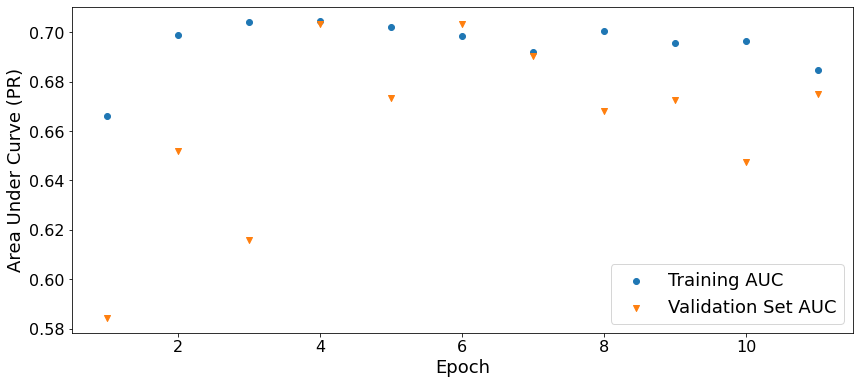

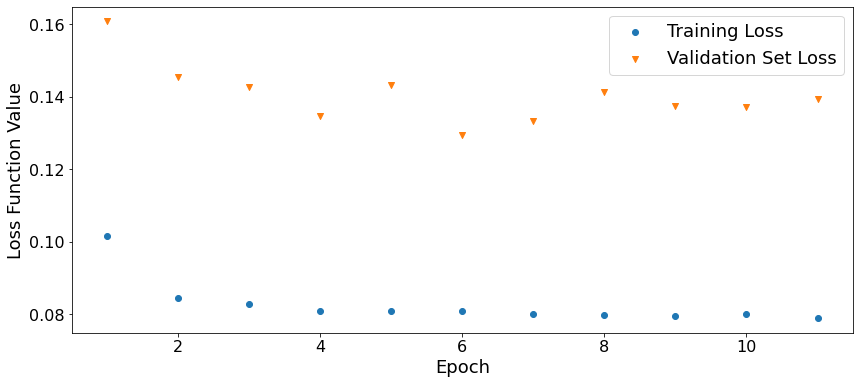

In [ ]:
length = len(history_dict['loss'])+1

plt.figure(figsize = (14,6))

plt.scatter(range(1,length), history_dict['auc'], label = "Training AUC")
plt.scatter(range(1,length), history_dict['val_auc'], marker='v', label = "Validation Set AUC")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Area Under Curve (PR)", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()


plt.figure(figsize = (14,6))

plt.scatter(range(1,length), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,length), history_dict['val_loss'], marker='v', label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss Function Value", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

# 5. Metrics: Precision, Recall, AUC (PR)

Import the confusion matrix so we can get the actual fires and predicted fires

In [ ]:
## now we can import the confusion matrix
from sklearn.metrics import confusion_matrix

TF Datasets are loaded lazily, so materialize the first batch of inputs (11 environmental features) and labels (fire mask).



In [ ]:
inputs, labels, weights = next(iter(dataset))

inputs_val, labels_val, _ = next(iter(valset))

inputs_test, labels_test, _ = next(iter(testset))

Reshape the data in the next two cells for predictions and to remove "no data" files

In [ ]:
X = inputs
y = tf.reshape(labels, [-1]).numpy() #len(labels)*32*32

y_val = tf.reshape(labels_val, [-1]).numpy() 

y_test = tf.reshape(labels_test, [-1]).numpy() 

In [ ]:
#Leave these commented if you want the training accuracy
#Uncomment one or the other if you want the val/test data
# X, y = inputs_val, y_val
# X, y = inputs_test, y_test

#Don't bother learning where no-data is during training.
#makes training quicker and binary (thank fuck)
y_pred = model.predict(X).reshape(-1)
y_pred = y_pred[np.where(y >= 0)]
y = y[np.where(y >= 0)]

53/53 [==============================] - 1s 17ms/step


Get the actual fire and predicted fire values

In [ ]:
## just like mse, actual then prediction
cum = confusion_matrix(y, np.round(y_pred))
cum

array([[1622656,     276],
       [  59323,     380]])

Get the True Negative (TN), False Positive (FP), False Negative (FN), and True Positive (TP)



In [ ]:
## Calculate the confusion matrix here

TN = cum[0,0]
FP = cum[0,1] 
FN = cum[1,0] 
TP = cum[1,1]

Get the baseline precision and recall


The baseline precision is with a cutoff of 0.5 (>0.5 means fire and <0.5 means no fire).

This isn't always ideal, as the model regularly predictions regions are on fire with, say 30% confidence.

In [ ]:
## calculate recall and precision here
print("The baseline precision is", 
         np.round(TP/(FP + TP), 4))

print("The baseline recall is", 
         np.round(TP/(FN + TP), 4))

The baseline precision is 0.5793
The baseline recall is 0.0064


So we sweep through all the cutoffs to see which combination of precision/recall is best.

In [ ]:
 ## Now plot how the accuracy (sensitivity/specificity) changes with the cutoff
cutoffs = np.arange(0.001,.975,.001)
precs = []
recs = []
y = y.astype(int)

for cutoff in cutoffs:
    TP = (1*(y_pred >= cutoff) & y).sum()
    PP = 1*(y_pred >= cutoff).sum() #predicted positives = # Denominator for precision
    AP = y.sum() #Actual positives # Denominator for recall
    precs.append(TP/PP)
    recs.append(TP/AP)

<ipython-input-50-5bbb3b50798d>:11: RuntimeWarning: invalid value encountered in long_scalars
  precs.append(TP/PP)


In [ ]:
prec, rec = get_metrics(precs, recs)

auc = tf.keras.metrics.AUC(curve = 'PR')
auc.update_state(y, y_pred)

print("The best precision is", prec)
print("The best recall is", rec)
print("The auc is", auc.result().numpy())

The best precision is 0.3038015083098891
The best recall is 0.430480880357771
The auc is 0.27974048


<ipython-input-8-37b4cf7522e5>:2: RuntimeWarning: invalid value encountered in true_divide
  f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))


# 6. Plot of Precision/Recall curves

Nothing fancy. Just seeing how they each change as the cutoff changes.

In [ ]:
plt.figure(figsize=(12,8))

plt.scatter(cutoffs,precs)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("Training Precision",fontsize=16)

plt.show()

In [ ]:
plt.figure(figsize=(12,8))

plt.scatter(cutoffs,recs)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("Training Recall",fontsize=16)

plt.show()

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(recs, precs)

plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

Remember, we report precision and recall that maximize the F1-score, which usually involves a relatively low threshold for fire.

In [ ]:
plt.figure(figsize=(12,8))

f1s = np.nan_to_num(2*np.nan_to_num(precs)*recs/(np.nan_to_num(precs) + recs))
plt.scatter(cutoffs,f1s)

plt.xlabel("Cutoff",fontsize=16)
plt.ylabel("F1-Score",fontsize=16)

plt.show()

# 7. Plotting function

Visualize the predicions on a few new inputs

In [ ]:
n_rows = 10
n_features = inputs.shape[3]
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
keys = INPUT_FEATURES

53/53 [==============================] - 0s 7ms/step


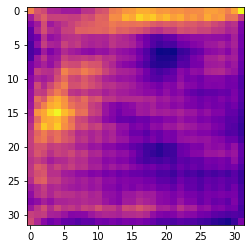

In [ ]:
pred = model.predict(inputs_test).reshape((len(inputs_test),32,32))
plt.imshow(pred[0], cmap='plasma') 

Plot the Last fire, Actual fire, and Predicted fire for comparison to see how well this model did in predicting fire

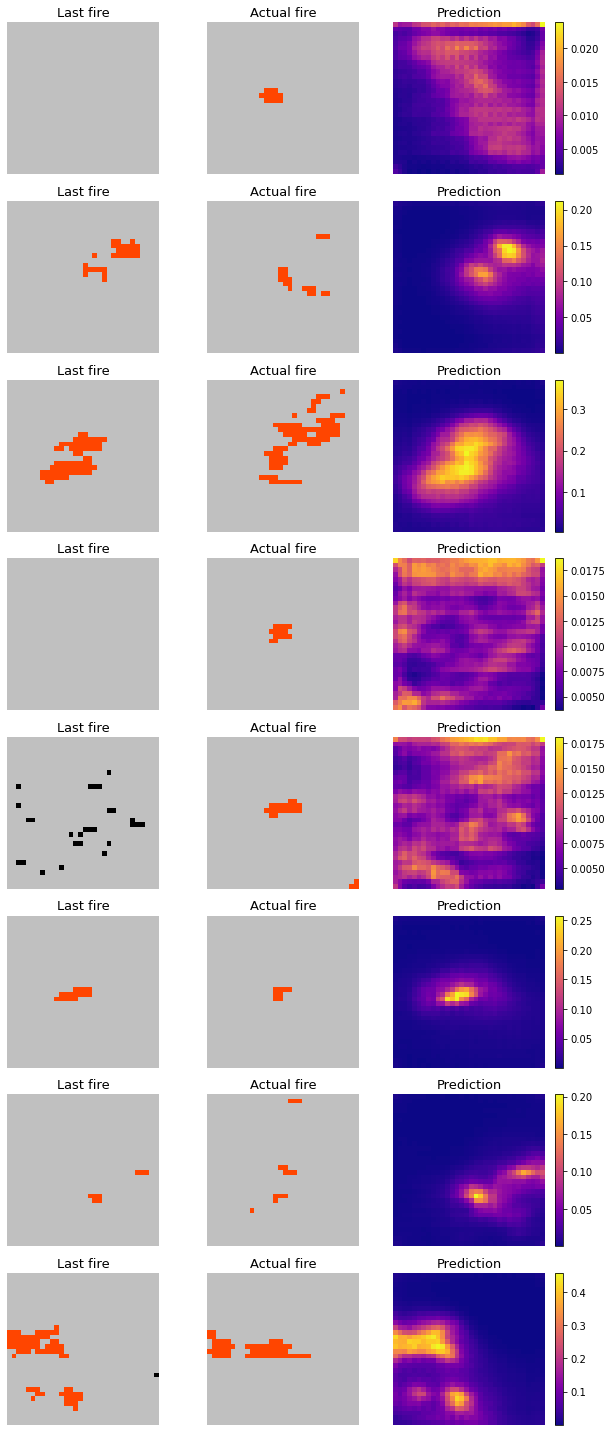

In [ ]:
fig = plt.figure(figsize=(9,20))
n_rows = 8

for i in range(n_rows):
  fire_index = i +1000
  plt.subplot(n_rows,3, 3*i + 1)
  plt.title("Last fire", fontsize=13)
  plt.imshow(inputs_test[fire_index, :, :, -1], cmap=CMAP, norm=NORM)
  plt.axis('off')
  plt.subplot(n_rows,3, 3*i + 2)
  plt.title("Actual fire", fontsize=13)
  plt.imshow(labels_test[fire_index, :, :, 0], cmap=CMAP, norm=NORM)
  plt.axis('off')
  plt.subplot(n_rows,3, 3*i + 3)
  plt.title("Prediction", fontsize=13)
  plt.imshow(pred[fire_index], cmap='plasma') 
  plt.colorbar()
  plt.axis('off')
plt.tight_layout()